In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


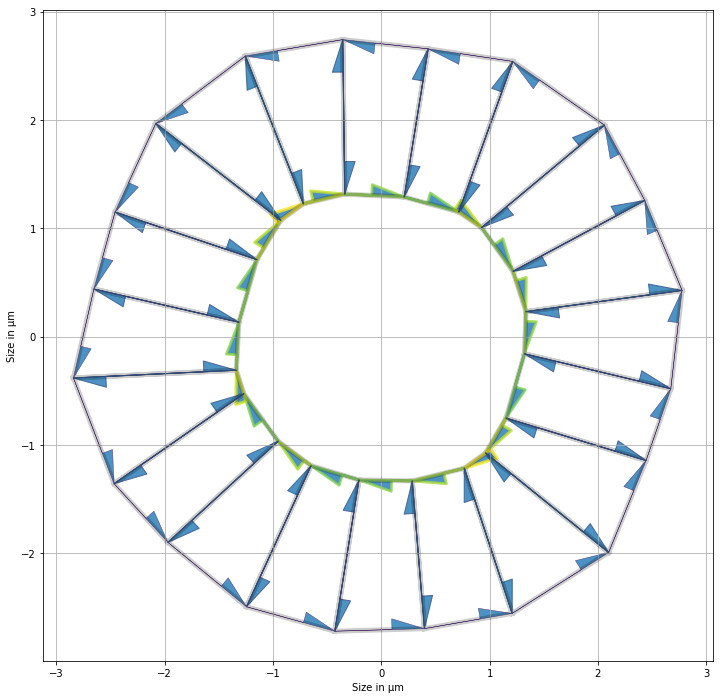

In [3]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [4]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo3.Nf),[1000]*(3*organo3.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_eq_cst_per_cell.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

In [5]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.101
1     0.115
2     0.126
3     0.110
4     0.105
5     0.102
6     0.112
7     0.102
8     0.118
9     0.105
10    0.104
11    0.115
12    0.127
13    0.116
14    0.106
15    0.103
16    0.117
17    0.105
18    0.111
19    0.107
20    0.010
21    0.011
22    0.012
23    0.011
24    0.010
25    0.010
26    0.011
27    0.010
28    0.011
29    0.010
      ...  
50    0.030
51    0.035
52    0.040
53    0.035
54    0.030
55    0.030
56    0.035
57    0.030
58    0.035
59    0.030
60    0.030
61    0.035
62    0.040
63    0.035
64    0.030
65    0.030
66    0.035
67    0.030
68    0.035
69    0.030
70    0.030
71    0.035
72    0.040
73    0.035
74    0.030
75    0.030
76    0.035
77    0.030
78    0.035
79    0.030
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.037466
1     0.042980
2     0.047452
3     0.041083
4     0.039120
5     0.037130
6     0.042399
7     0.037119
8     0.043188
9     0.038093
10    0.038654
11    0.042510
12    0.047137
13    0.042130

Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [6]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  78 
Dimension of A:  81


## Matrice avec somme des tensions constantes dans chaque cellule

Apical tensions:  [0.03524854 0.03650179 0.03641272 0.03502757 0.03542176 0.03490987
 0.03527486 0.03452823 0.03667495 0.03531082 0.03556319 0.03613776
 0.03655514 0.03579492 0.0357893  0.03560227 0.03640817 0.03497867
 0.03565726 0.03556201] 
Basal tensions:  [0.00353475 0.00172818 0.         0.00192974 0.00310843 0.00349176
 0.00213824 0.00347466 0.00174971 0.00276861 0.00347059 0.00195277
 0.00028229 0.00135652 0.00292715 0.00339932 0.00161665 0.00306005
 0.00226058 0.00225231] 
Lateral tensions:  [0.01868472 0.01923866 0.02107574 0.02052038 0.01893618 0.01907079
 0.02005646 0.01947582 0.01904847 0.01939401 0.01844088 0.01938533
 0.02063734 0.02032294 0.01875883 0.01846946 0.0194497  0.01943542
 0.01955518 0.01966106] 
Area elasticity:  [0.0246198  0.0238063  0.02240446 0.02304533 0.02438847 0.02398819
 0.02376746 0.0232915  0.0231276  0.02291203 0.0245688  0.02330514
 0.0219183  0.02207185 0.02373762 0.02359576 0.02296847 0.02321493
 0.02362371 0.02351119] 
Lumen area elasticity:  

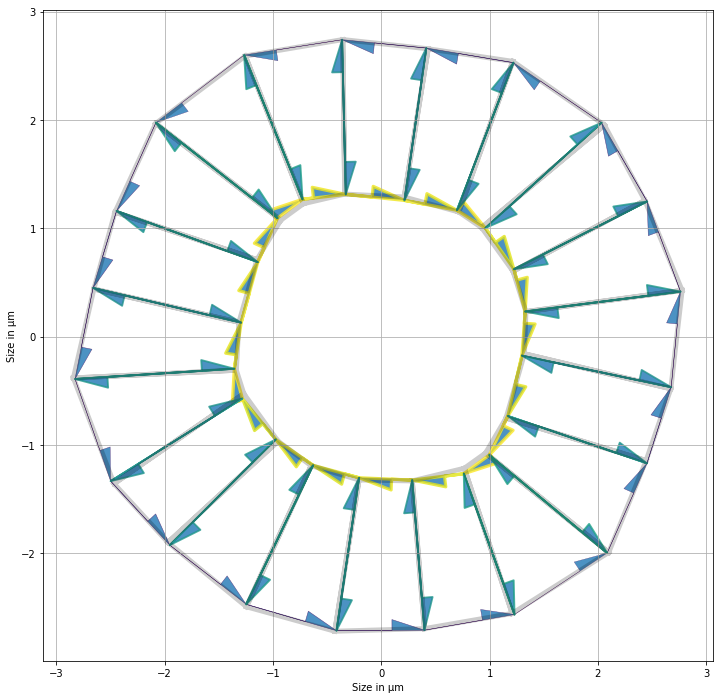

In [7]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
avg_cste = [4*(organo3.edge_df.line_tension.mean() /
               (organo3.face_df.area_elasticity.mean() *
                organo3.face_df.prefered_area.mean()**1.5))]*organo3.Nf
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i)[:-1])
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = organo3_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

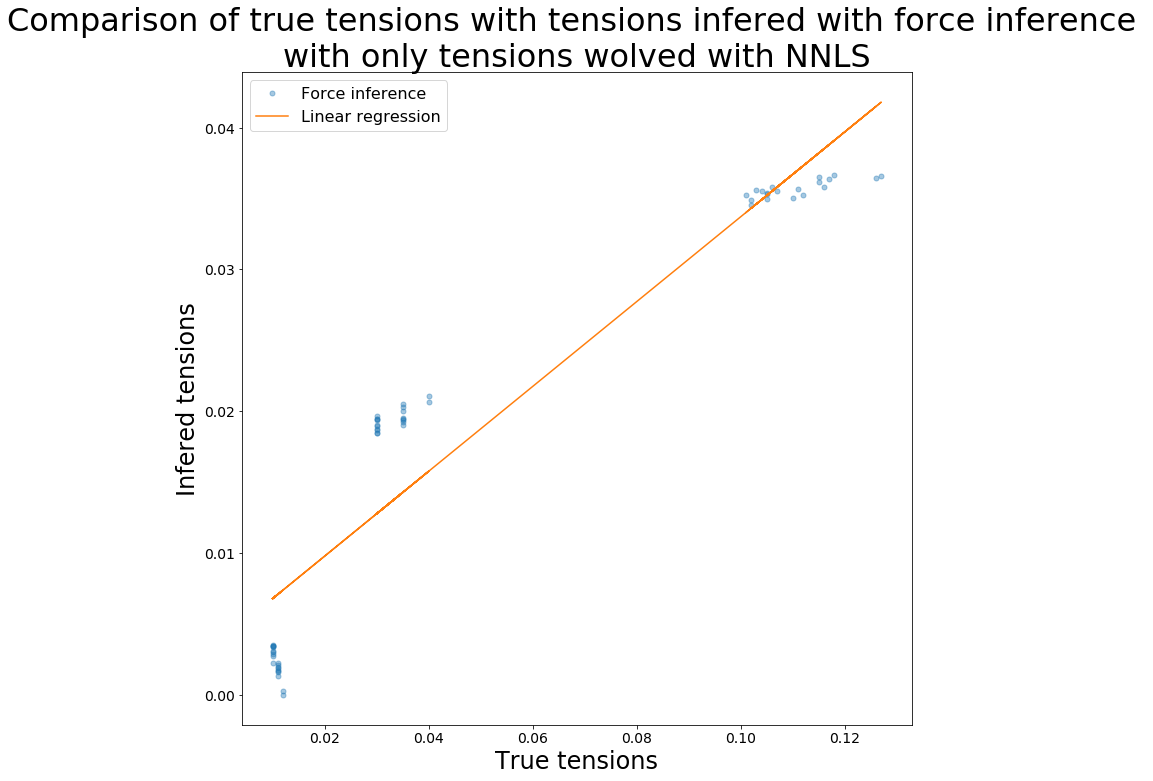

R value : 0.9430378069268928 
Standard error : 0.003929028643601277


In [8]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

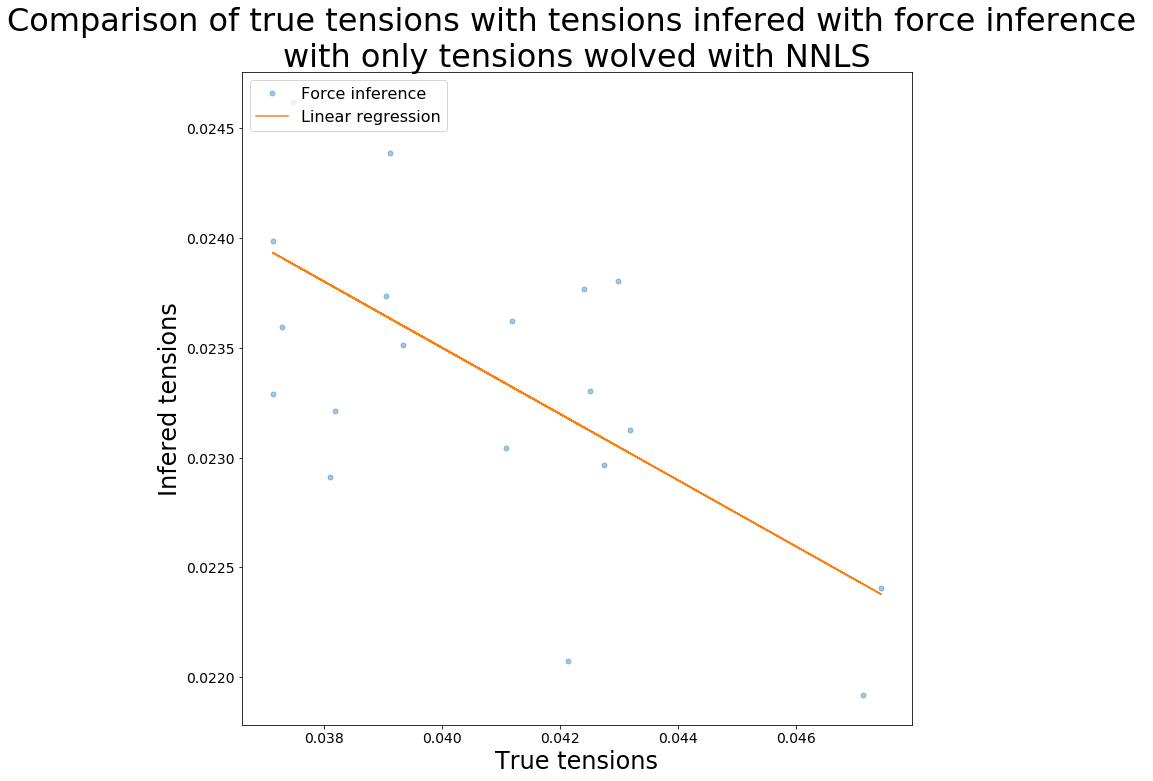

R value : -0.6348621451740538 
Standard error : 0.00027751215827968075


In [9]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  mat_eq_cst[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Minimize the distance wrt tensions and areas

In [10]:
iprint_file = "../../assets/dist_at_each_f_ev/4_03_eq_t_per_cell_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    **lm_opt)

0.933057851886661 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.9330578901276956 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.03746191
 0.02309852 0.00280725 0.01477558 0.02794084 0.01477686 0.0247186
 0.01621683 0.01526114 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.9330578462998415 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802827 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901504 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.9330579192631955 [0.0266626  0.0271711  0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931828 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931138 0.02832387 0.02544747 0.03746191
 0.02309852 0.00280725 0.01477558 0.02794084 0.01477686 0.0247186
 0.01621683 0.01526114 0.02044741 0.03013171 0.03901505 0.01631175
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234213 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.9330578511824997 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.933057851271076 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802827 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901504 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.9330578538606953 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.9330578523051507 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.933057857380147 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963282 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.0247186
 0.01621683 0.01526114 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.9330578635647531 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.9330578486295992 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802827 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963282 0.04556063 0.00931137 0.02832387 0.02544747 0.03746191
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901504 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.933057851886661 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.933057851886661 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.933057851886661 [0.0266626  0.02717109 0.04326579 0.05357451 0.00454865 0.01642377
 0.0169841  0.02802828 0.04931827 0.02678686 0.01812843 0.02278595
 0.03963283 0.04556063 0.00931137 0.02832387 0.02544747 0.0374619
 0.02309852 0.00280724 0.01477558 0.02794083 0.01477686 0.02471859
 0.01621683 0.01526113 0.02044741 0.0301317  0.03901505 0.01631174
 0.01396626 0.01657048 0.00929403 0.01538469 0.00749953 0.01843961
 0.01234212 0.0343131  0.02412103 0.01620913 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.9330590953878355 [0.02666262 0.02717113 0.04326577 0.05357457 0.00454863 0.01642381
 0.01698414 0.02802832 0.04931834 0.02678683 0.01812843 0.02278595
 0.03963283 0.04556064 0.00931136 0.0283239  0.02544748 0.03746194
 0.02309857 0.00280731 0.01477562 0.02794089 0.01477687 0.02471863
 0.01621685 0.01526117 0.02044747 0.03013178 0.03901513 0.01631178
 0.01396629 0.01657051 0.00929403 0.01538472 0.00749954 0.01843964
 0.01234214 0.03431318 0.02412109 0.01620918 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9330557186848732 [0.02666254 0.02717102 0.04326581 0.05357439 0.00454867 0.01642371
 0.01698405 0.0280282  0.04931816 0.0267869  0.01812843 0.02278595
 0.03963281 0.04556061 0.00931138 0.02832383 0.02544744 0.03746182
 0.02309843 0.00280714 0.01477553 0.02794075 0.01477684 0.02471853
 0.01621678 0.01526107 0.02044731 0.03013157 0.0390149  0.01631167
 0.01396621 0.01657043 0.00929402 0.01538464 0.00749953 0.01843955
 0.01234209 0.034313   0.02412095 0.01620905 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9330537213759139 [0.02666251 0.02717094 0.04326584 0.0535743  0.0045487  0.01642365
 0.01698398 0.02802811 0.04931805 0.02678694 0.01812843 0.02278593
 0.03963281 0.0455606  0.00931138 0.0283238  0.0254474  0.03746172
 0.02309833 0.00280704 0.01477548 0.02794067 0.0147768  0.02471845
 0.01621674 0.01526099 0.02044722 0.03013146 0.03901478 0.01631163
 0.01396617 0.01657039 0.00929401 0.01538459 0.00749954 0.01843949
 0.01234208 0.03431291 0.02412089 0.01620896 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.9330598822988853 [0.02666263 0.02717116 0.04326575 0.0535746  0.00454862 0.01642383
 0.01698417 0.02802836 0.04931838 0.02678681 0.01812843 0.02278595
 0.03963283 0.04556064 0.00931136 0.02832391 0.02544749 0.03746198
 0.02309862 0.00280735 0.01477564 0.02794093 0.0147769  0.02471867
 0.01621687 0.01526121 0.0204475  0.03013183 0.03901518 0.01631181
 0.01396631 0.01657053 0.00929403 0.01538474 0.00749953 0.01843967
 0.01234215 0.03431321 0.02412111 0.01620921 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5806940758643944 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466477
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940729497418 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333162 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940762979222 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940774792994 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594968 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940790660139 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940786040424 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940782095551 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839296 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940755783692 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940804444285 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.00905091 0.01209831 0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940786384409 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940785424597 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940785424597 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940785424597 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940938774013 [0.0128503  0.0135756  0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.02209161 0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.01209831 0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839296 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806940838035162 [0.0128503  0.01357561 0.0241649  0.03014956 0.01197234 0.00287349
 0.01132692 0.00557563 0.0220916  0.03106168 0.01207689 0.02317402
 0.03090525 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594968 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418297 0.00675015 0.00501828 0.01333163 0.0042065
 0.0090509  0.0120983  0.0117971  0.01420231 0.01090084 0.01101623
 0.00587883 0.00788881 0.00336812 0.00839296 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806941515103858 [0.0128503  0.01357561 0.0241649  0.03014957 0.01197234 0.00287349
 0.01132692 0.00557563 0.02209161 0.03106168 0.01207689 0.02317403
 0.03090526 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594969 0.02368746 0.03168884 0.01466478
 0.01600622 0.00418298 0.00675015 0.00501828 0.01333163 0.0042065
 0.00905091 0.0120983  0.0117971  0.01420231 0.01090084 0.01101624
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5806941726192296 [0.01285031 0.01357561 0.0241649  0.03014957 0.01197235 0.00287349
 0.01132692 0.00557563 0.02209161 0.03106168 0.01207689 0.02317403
 0.03090526 0.03916438 0.00775015 0.01224906 0.02153675 0.02227785
 0.01230695 0.01352983 0.00594968 0.02368747 0.03168884 0.01466478
 0.01600622 0.00418298 0.00675015 0.00501828 0.01333163 0.0042065
 0.00905091 0.01209831 0.0117971  0.01420231 0.01090084 0.01101624
 0.00587883 0.00788881 0.00336812 0.00839297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842670517211 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215678 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842522813107 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631675 0.00438854 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.562684259171724 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5626842641041253 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842616473282 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842618656047 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842619540795 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842552659691 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842618198604 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155798 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842589775205 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842618893948 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842618893948 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842618893948 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842618893948 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155797 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.02107169 0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443105
 0.01552581 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626842944552959 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155798 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.0210717  0.0216457
 0.01198055 0.01380347 0.00516412 0.02215677 0.02969098 0.01443106
 0.01552582 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158535 0.01178522 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626843436862543 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155798 0.03030046 0.01171781 0.02221215
 0.03068571 0.03859007 0.00761248 0.01200005 0.0210717  0.0216457
 0.01198055 0.01380347 0.00516412 0.02215678 0.02969098 0.01443106
 0.01552582 0.00404325 0.00631676 0.00438855 0.01285487 0.00408472
 0.00837314 0.01158536 0.01178523 0.01379812 0.01070456 0.01035714
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5626844126831445 [0.01230986 0.01286712 0.02476859 0.02957053 0.01130868 0.00256665
 0.01108631 0.00515965 0.02155798 0.03030046 0.01171781 0.02221216
 0.03068572 0.03859007 0.00761248 0.01200006 0.0210717  0.0216457
 0.01198055 0.01380347 0.00516412 0.02215678 0.02969099 0.01443106
 0.01552582 0.00404325 0.00631676 0.00438855 0.01285488 0.00408472
 0.00837315 0.01158536 0.01178523 0.01379813 0.01070456 0.01035715
 0.00573769 0.00772415 0.00345554 0.00769096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5539942012372054 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119142 0.02838267 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941865623461 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941933798983 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377297 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941976839521 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941962426627 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941963600306 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941965122457 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941890087667 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838267 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941953122454 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941933311828 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941965272608 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941965272608 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941965272608 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539941965272608 [0.01223052 0.01214071 0.02638891 0.02916873 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.02149099
 0.03074403 0.03813474 0.00695519 0.01269553 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119141 0.02838268 0.01507791
 0.01571799 0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045553
 0.00516803 0.00798337 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5539942828680792 [0.01223052 0.01214071 0.02638891 0.02916874 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184005 0.02905619 0.01198452 0.021491
 0.03074403 0.03813474 0.00695519 0.01269554 0.02052537 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119142 0.02838268 0.01507791
 0.015718   0.00434654 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102831 0.0122638  0.01377298 0.01107863 0.01045554
 0.00516803 0.00798338 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5539943827768299 [0.01223052 0.01214071 0.02638891 0.02916874 0.0107721  0.00241933
 0.01054328 0.00503071 0.02184006 0.02905619 0.01198453 0.021491
 0.03074403 0.03813474 0.00695519 0.01269554 0.02052538 0.02114115
 0.01209195 0.01374138 0.0042061  0.02119143 0.02838269 0.01507791
 0.015718   0.00434655 0.0056402  0.00319862 0.01262131 0.00400097
 0.00868031 0.01102832 0.0122638  0.01377298 0.01107863 0.01045554
 0.00516803 0.00798338 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5539945679195541 [0.01223053 0.01214071 0.02638892 0.02916875 0.01077211 0.00241934
 0.01054328 0.00503071 0.02184007 0.02905619 0.01198453 0.02149101
 0.03074404 0.03813475 0.00695519 0.01269555 0.02052538 0.02114116
 0.01209196 0.01374137 0.00420611 0.02119144 0.02838271 0.01507792
 0.01571801 0.00434656 0.00564021 0.00319862 0.01262132 0.00400097
 0.00868033 0.01102832 0.01226381 0.01377299 0.01107864 0.01045555
 0.00516803 0.00798338 0.00349135 0.00659277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5281506931138453 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575626 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506802055479 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.00386119 0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506868330843 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506910422986 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483775 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506877661943 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506880004281 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506880798811 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506824325142 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483775 0.00302007 0.0185958  0.0244292  0.01470034
 0.0145794  0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664622 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506886833163 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.0286943  0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483775 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506865079818 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483775 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506879926816 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506879926816 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506879926816 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506879926816 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575627 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281506895307864 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483776 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575626 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281507056898398 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012244
 0.03098971 0.03784036 0.00771238 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483775 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392626 0.00511868 0.00285756 0.01168056 0.00446368
 0.00664622 0.0105053  0.01214004 0.01326887 0.01046807 0.00875998
 0.00540689 0.00756599 0.00365175 0.00575626 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5281507065930492 [0.0111565  0.01127109 0.02776173 0.0286023  0.00969357 0.00187363
 0.01051734 0.0038612  0.02071602 0.02869429 0.01125244 0.02012245
 0.03098971 0.03784036 0.00771237 0.01206225 0.02016132 0.0202157
 0.01126773 0.01483775 0.00302007 0.0185958  0.0244292  0.01470034
 0.01457941 0.00392627 0.00511868 0.00285756 0.01168056 0.00446367
 0.00664623 0.0105053  0.01214003 0.01326887 0.01046807 0.00875999
 0.00540689 0.00756599 0.00365175 0.00575626 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5065458069278941 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065457964947185 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335044 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.506545801717762 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

0.5065458054073143 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458023510767 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458025436747 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.506545802649898 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

0.5065457976326714 [0.01030734 0.01038855 0.02895316 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458032907457 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335044 0.0200209  0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458016901194 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458025808335 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458025808335 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458025808335 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458025808335 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.02002089 0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458055869542 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335045 0.0200209  0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384882 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458199304801 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335044 0.0200209  0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.019226
 0.01075575 0.01519406 0.00226302 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572733 0.00998968 0.01222858 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.5065458239102856 [0.01030734 0.01038855 0.02895315 0.02778245 0.00873265 0.00153631
 0.01019623 0.00335044 0.0200209  0.02748209 0.01080255 0.0186941
 0.03076157 0.03691956 0.00769709 0.01177861 0.01940443 0.01922599
 0.01075575 0.01519406 0.00226303 0.01676665 0.02159527 0.01484956
 0.01394295 0.00384883 0.00441365 0.00251379 0.01109512 0.00488525
 0.00572734 0.00998968 0.01222857 0.01298252 0.01038816 0.00800102
 0.00517202 0.00744784 0.00380316 0.00464759 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.47806412631537476 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.47806412147265626 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332173 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4780641241779564 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.0124786  0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641256279989 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410056 0.00301528 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641239326875 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641240206507 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.47806412419819877 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4780641203877154 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641242326042 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641244520618 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641241677697 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641241677697 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641241677697 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641241677697 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.0169744  0.01544774
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4780641291757116 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705652 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.01697441 0.01544775
 0.01291499 0.003807   0.00302425 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.47806414032064304 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329436 0.01423036 0.01697441 0.01544775
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440754 0.00954458 0.01247861 0.01293211 0.01047581 0.00692611
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4780641511882716 [0.00871738 0.00904615 0.03098137 0.02640239 0.00705653 0.00102707
 0.00985398 0.00294315 0.01882328 0.02544796 0.01005048 0.01624948
 0.03045823 0.03524867 0.00774732 0.01127308 0.01808123 0.01748932
 0.00983646 0.0158103  0.00329437 0.01423036 0.01697441 0.01544775
 0.01291499 0.00380701 0.00302424 0.00332172 0.01030986 0.00600565
 0.00440755 0.00954458 0.0124786  0.01293211 0.01047581 0.00692612
 0.00485473 0.00745462 0.00410055 0.00301527 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4529658501104851 [7.61236632e-03 7.33156036e-03 3.29367211e-02 2.50877810e-02
 4.68231015e-03 5.56742713e-04 9.50043104e-03 3.99637436e-03
 1.75929904e-02 2.33477627e-02 8.98408825e-03 1.29200117e-02
 3.02516356e-02 3.30141685e-02 7.60867497e-03 1.04217774e-02
 1.63742574e-02 1.52728078e-02 8.36646802e-03 1.65905335e-02
 6.06843847e-03 1.09738866e-02 1.18873790e-02 1.54966706e-02
 1.10300511e-02 3.78303314e-03 1.66435192e-03 5.36481347e-03
 1.02785227e-02 7.41415647e-03 4.02139158e-03 9.28489603e-03
 1.27713826e-02 1.33072126e-02 1.04899339e-02 6.05128408e-03
 4.63850710e-03 7.67636333e-03 4.80811572e-03 3.50598985e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.45296585186319765 [7.61236547e-03 7.33155816e-03 3.29367212e-02 2.50877811e-02
 4.68231229e-03 5.56744599e-04 9.50043097e-03 3.99637446e-03
 1.75929905e-02 2.33477627e-02 8.98408826e-03 1.29200117e-02
 3.02516356e-02 3.30141685e-02 7.60867498e-03 1.04217774e-02
 1.63742574e-02 1.52728078e-02 8.36646800e-03 1.65905335e-02
 6.06844027e-03 1.09738849e-02 1.18873795e-02 1.54966700e-02
 1.10300528e-02 3.78303147e-03 1.66435131e-03 5.36481331e-03
 1.02785227e-02 7.41415649e-03 4.02139158e-03 9.28489604e-03
 1.27713826e-02 1.33072127e-02 1.04899340e-02 6.05128407e-03
 4.63850714e-03 7.67636342e-03 4.80811589e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4529658521280229 [7.61236564e-03 7.33155832e-03 3.29367215e-02 2.50877813e-02
 4.68231026e-03 5.56742733e-04 9.50043115e-03 3.99637414e-03
 1.75929898e-02 2.33477620e-02 8.98408826e-03 1.29200119e-02
 3.02516359e-02 3.30141688e-02 7.60867508e-03 1.04217776e-02
 1.63742575e-02 1.52728079e-02 8.36646802e-03 1.65905336e-02
 6.06844036e-03 1.09738850e-02 1.18873797e-02 1.54966708e-02
 1.10300511e-02 3.78303321e-03 1.66435182e-03 5.36481359e-03
 1.02785228e-02 7.41415661e-03 4.02139242e-03 9.28489605e-03
 1.27713827e-02 1.33072128e-02 1.04899340e-02 6.05128421e-03
 4.63850714e-03 7.67636346e-03 4.80811590e-03 3.50599039e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658519487672 [7.61236568e-03 7.33155834e-03 3.29367216e-02 2.50877814e-02
 4.68231026e-03 5.56742813e-04 9.50043109e-03 3.99637436e-03
 1.75929906e-02 2.33477630e-02 8.98408846e-03 1.29200118e-02
 3.02516348e-02 3.30141679e-02 7.60867469e-03 1.04217776e-02
 1.63742576e-02 1.52728080e-02 8.36646803e-03 1.65905336e-02
 6.06844037e-03 1.09738850e-02 1.18873797e-02 1.54966709e-02
 1.10300512e-02 3.78303324e-03 1.66435192e-03 5.36481352e-03
 1.02785228e-02 7.41415646e-03 4.02139181e-03 9.28489680e-03
 1.27713820e-02 1.33072124e-02 1.04899344e-02 6.05128444e-03
 4.63850706e-03 7.67636346e-03 4.80811590e-03 3.50599039e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658507564267 [7.61236554e-03 7.33155829e-03 3.29367215e-02 2.50877813e-02
 4.68231022e-03 5.56742774e-04 9.50043109e-03 3.99637438e-03
 1.75929906e-02 2.33477629e-02 8.98408837e-03 1.29200118e-02
 3.02516358e-02 3.30141688e-02 7.60867521e-03 1.04217774e-02
 1.63742566e-02 1.52728071e-02 8.36646796e-03 1.65905336e-02
 6.06844029e-03 1.09738849e-02 1.18873797e-02 1.54966708e-02
 1.10300511e-02 3.78303317e-03 1.66435197e-03 5.36481351e-03
 1.02785228e-02 7.41415656e-03 4.02139161e-03 9.28489612e-03
 1.27713827e-02 1.33072127e-02 1.04899338e-02 6.05128451e-03
 4.63850715e-03 7.67636372e-03 4.80811543e-03 3.50599045e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658504077911 [7.61236563e-03 7.33155806e-03 3.29367214e-02 2.50877812e-02
 4.68231021e-03 5.56742793e-04 9.50043101e-03 3.99637432e-03
 1.75929905e-02 2.33477628e-02 8.98408839e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646796e-03 1.65905335e-02
 6.06844063e-03 1.09738846e-02 1.18873795e-02 1.54966707e-02
 1.10300511e-02 3.78303319e-03 1.66435190e-03 5.36481348e-03
 1.02785227e-02 7.41415648e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128416e-03
 4.63850710e-03 7.67636340e-03 4.80811585e-03 3.50599033e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658501984513 [7.61236561e-03 7.33155827e-03 3.29367213e-02 2.50877812e-02
 4.68231004e-03 5.56742715e-04 9.50043102e-03 3.99637432e-03
 1.75929905e-02 2.33477627e-02 8.98408839e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646795e-03 1.65905335e-02
 6.06844032e-03 1.09738849e-02 1.18873796e-02 1.54966707e-02
 1.10300509e-02 3.78303336e-03 1.66435189e-03 5.36481347e-03
 1.02785227e-02 7.41415648e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128416e-03
 4.63850710e-03 7.67636340e-03 4.80811587e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658503848432 [7.61236560e-03 7.33155827e-03 3.29367213e-02 2.50877811e-02
 4.68231021e-03 5.56742794e-04 9.50043101e-03 3.99637432e-03
 1.75929904e-02 2.33477627e-02 8.98408838e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646795e-03 1.65905335e-02
 6.06844031e-03 1.09738849e-02 1.18873796e-02 1.54966707e-02
 1.10300511e-02 3.78303318e-03 1.66435190e-03 5.36481348e-03
 1.02785228e-02 7.41415650e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128415e-03
 4.63850710e-03 7.67636340e-03 4.80811586e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.45296585043309795 [7.61236561e-03 7.33155828e-03 3.29367213e-02 2.50877811e-02
 4.68231021e-03 5.56742797e-04 9.50043101e-03 3.99637432e-03
 1.75929905e-02 2.33477627e-02 8.98408839e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646795e-03 1.65905335e-02
 6.06844031e-03 1.09738849e-02 1.18873796e-02 1.54966707e-02
 1.10300511e-02 3.78303319e-03 1.66435190e-03 5.36481348e-03
 1.02785227e-02 7.41415648e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128416e-03
 4.63850710e-03 7.67636340e-03 4.80811586e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.45296585039558895 [7.61236560e-03 7.33155827e-03 3.29367213e-02 2.50877811e-02
 4.68231021e-03 5.56742795e-04 9.50043101e-03 3.99637432e-03
 1.75929905e-02 2.33477627e-02 8.98408839e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646795e-03 1.65905335e-02
 6.06844031e-03 1.09738849e-02 1.18873796e-02 1.54966707e-02
 1.10300511e-02 3.78303319e-03 1.66435191e-03 5.36481348e-03
 1.02785227e-02 7.41415648e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128415e-03
 4.63850713e-03 7.67636342e-03 4.80811586e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.45296585218297214 [7.61236336e-03 7.33155769e-03 3.29367212e-02 2.50877811e-02
 4.68231026e-03 5.56742908e-04 9.50043091e-03 3.99637421e-03
 1.75929904e-02 2.33477627e-02 8.98408858e-03 1.29200120e-02
 3.02516357e-02 3.30141686e-02 7.60867507e-03 1.04217778e-02
 1.63742573e-02 1.52728077e-02 8.36646771e-03 1.65905332e-02
 6.06844133e-03 1.09738861e-02 1.18873801e-02 1.54966708e-02
 1.10300511e-02 3.78303324e-03 1.66435185e-03 5.36481347e-03
 1.02785227e-02 7.41415645e-03 4.02139174e-03 9.28489615e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128425e-03
 4.63850709e-03 7.67636352e-03 4.80811624e-03 3.50599156e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4529658515498351 [7.61236582e-03 7.33155847e-03 3.29367213e-02 2.50877809e-02
 4.68231050e-03 5.56742432e-04 9.50043079e-03 3.99637410e-03
 1.75929904e-02 2.33477627e-02 8.98408859e-03 1.29200121e-02
 3.02516357e-02 3.30141686e-02 7.60867508e-03 1.04217778e-02
 1.63742573e-02 1.52728078e-02 8.36646784e-03 1.65905334e-02
 6.06844033e-03 1.09738849e-02 1.18873797e-02 1.54966722e-02
 1.10300511e-02 3.78303192e-03 1.66435231e-03 5.36481364e-03
 1.02785228e-02 7.41415646e-03 4.02139174e-03 9.28489615e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128426e-03
 4.63850705e-03 7.67636337e-03 4.80811582e-03 3.50599035e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.45296585018215996 [7.61236566e-03 7.33155829e-03 3.29367212e-02 2.50877810e-02
 4.68231015e-03 5.56742960e-04 9.50043076e-03 3.99637451e-03
 1.75929927e-02 2.33477631e-02 8.98408863e-03 1.29200119e-02
 3.02516355e-02 3.30141685e-02 7.60867501e-03 1.04217776e-02
 1.63742573e-02 1.52728077e-02 8.36646786e-03 1.65905334e-02
 6.06844031e-03 1.09738848e-02 1.18873795e-02 1.54966707e-02
 1.10300511e-02 3.78303319e-03 1.66435208e-03 5.36481329e-03
 1.02785203e-02 7.41415730e-03 4.02139126e-03 9.28489614e-03
 1.27713827e-02 1.33072126e-02 1.04899339e-02 6.05128416e-03
 4.63850707e-03 7.67636336e-03 4.80811583e-03 3.50599035e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.45296584790422234 [7.61236559e-03 7.33155824e-03 3.29367210e-02 2.50877809e-02
 4.68231017e-03 5.56742814e-04 9.50043091e-03 3.99637426e-03
 1.75929903e-02 2.33477625e-02 8.98408839e-03 1.29200124e-02
 3.02516380e-02 3.30141688e-02 7.60867522e-03 1.04217776e-02
 1.63742572e-02 1.52728077e-02 8.36646785e-03 1.65905333e-02
 6.06844027e-03 1.09738848e-02 1.18873795e-02 1.54966706e-02
 1.10300510e-02 3.78303316e-03 1.66435189e-03 5.36481343e-03
 1.02785227e-02 7.41415659e-03 4.02139139e-03 9.28489488e-03
 1.27713806e-02 1.33072132e-02 1.04899337e-02 6.05128397e-03
 4.63850712e-03 7.67636335e-03 4.80811582e-03 3.50599034e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4529658498997589 [7.61236568e-03 7.33155827e-03 3.29367212e-02 2.50877810e-02
 4.68231019e-03 5.56742845e-04 9.50043092e-03 3.99637425e-03
 1.75929903e-02 2.33477626e-02 8.98408843e-03 1.29200119e-02
 3.02516355e-02 3.30141684e-02 7.60867468e-03 1.04217780e-02
 1.63742598e-02 1.52728080e-02 8.36646779e-03 1.65905333e-02
 6.06844033e-03 1.09738849e-02 1.18873795e-02 1.54966706e-02
 1.10300510e-02 3.78303319e-03 1.66435188e-03 5.36481345e-03
 1.02785227e-02 7.41415644e-03 4.02139166e-03 9.28489605e-03
 1.27713826e-02 1.33072128e-02 1.04899343e-02 6.05128356e-03
 4.63850456e-03 7.67636433e-03 4.80811609e-03 3.50599031e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658504304575 [7.61236561e-03 7.33155828e-03 3.29367213e-02 2.50877811e-02
 4.68231021e-03 5.56742797e-04 9.50043101e-03 3.99637432e-03
 1.75929905e-02 2.33477627e-02 8.98408839e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646795e-03 1.65905335e-02
 6.06844032e-03 1.09738849e-02 1.18873796e-02 1.54966707e-02
 1.10300511e-02 3.78303319e-03 1.66435190e-03 5.36481348e-03
 1.02785227e-02 7.41415648e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128416e-03
 4.63850710e-03 7.67636340e-03 4.80811586e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658504304575 [7.61236561e-03 7.33155828e-03 3.29367213e-02 2.50877811e-02
 4.68231021e-03 5.56742797e-04 9.50043101e-03 3.99637432e-03
 1.75929905e-02 2.33477627e-02 8.98408839e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646795e-03 1.65905335e-02
 6.06844032e-03 1.09738849e-02 1.18873796e-02 1.54966707e-02
 1.10300511e-02 3.78303319e-03 1.66435190e-03 5.36481348e-03
 1.02785227e-02 7.41415648e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128416e-03
 4.63850710e-03 7.67636340e-03 4.80811586e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658504304575 [7.61236561e-03 7.33155828e-03 3.29367213e-02 2.50877811e-02
 4.68231021e-03 5.56742797e-04 9.50043101e-03 3.99637432e-03
 1.75929905e-02 2.33477627e-02 8.98408839e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646795e-03 1.65905335e-02
 6.06844032e-03 1.09738849e-02 1.18873796e-02 1.54966707e-02
 1.10300511e-02 3.78303319e-03 1.66435190e-03 5.36481348e-03
 1.02785227e-02 7.41415648e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128416e-03
 4.63850710e-03 7.67636340e-03 4.80811586e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658504304575 [7.61236561e-03 7.33155828e-03 3.29367213e-02 2.50877811e-02
 4.68231021e-03 5.56742797e-04 9.50043101e-03 3.99637432e-03
 1.75929905e-02 2.33477627e-02 8.98408839e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646795e-03 1.65905335e-02
 6.06844032e-03 1.09738849e-02 1.18873796e-02 1.54966707e-02
 1.10300511e-02 3.78303319e-03 1.66435190e-03 5.36481348e-03
 1.02785227e-02 7.41415648e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128416e-03
 4.63850710e-03 7.67636340e-03 4.80811586e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658504304575 [7.61236561e-03 7.33155828e-03 3.29367213e-02 2.50877811e-02
 4.68231021e-03 5.56742797e-04 9.50043101e-03 3.99637432e-03
 1.75929905e-02 2.33477627e-02 8.98408839e-03 1.29200119e-02
 3.02516357e-02 3.30141686e-02 7.60867502e-03 1.04217776e-02
 1.63742574e-02 1.52728078e-02 8.36646795e-03 1.65905335e-02
 6.06844032e-03 1.09738849e-02 1.18873796e-02 1.54966707e-02
 1.10300511e-02 3.78303319e-03 1.66435190e-03 5.36481348e-03
 1.02785227e-02 7.41415648e-03 4.02139165e-03 9.28489609e-03
 1.27713827e-02 1.33072127e-02 1.04899340e-02 6.05128416e-03
 4.63850710e-03 7.67636340e-03 4.80811586e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4529658526278485 [7.61236639e-03 7.33155470e-03 3.29367199e-02 2.50877812e-02
 4.68231061e-03 5.56743311e-04 9.50043116e-03 3.99637520e-03
 1.75929907e-02 2.33477623e-02 8.98408718e-03 1.29200102e-02
 3.02516352e-02 3.30141680e-02 7.60867461e-03 1.04217764e-02
 1.63742573e-02 1.52728079e-02 8.36646853e-03 1.65905321e-02
 6.06843607e-03 1.09738893e-02 1.18873819e-02 1.54966715e-02
 1.10300502e-02 3.78303325e-03 1.66435348e-03 5.36481338e-03
 1.02785235e-02 7.41415734e-03 4.02139083e-03 9.28489611e-03
 1.27713828e-02 1.33072134e-02 1.04899338e-02 6.05128340e-03
 4.63850803e-03 7.67636457e-03 4.80811710e-03 3.50599296e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.452965850212965 [7.61236580e-03 7.33155977e-03 3.29367216e-02 2.50877810e-02
 4.68230679e-03 5.56741882e-04 9.50043104e-03 3.99637435e-03
 1.75929906e-02 2.33477632e-02 8.98408848e-03 1.29200120e-02
 3.02516361e-02 3.30141691e-02 7.60867479e-03 1.04217778e-02
 1.63742577e-02 1.52728080e-02 8.36646803e-03 1.65905336e-02
 6.06844120e-03 1.09738836e-02 1.18873799e-02 1.54966724e-02
 1.10300537e-02 3.78302902e-03 1.66435285e-03 5.36481355e-03
 1.02785229e-02 7.41415575e-03 4.02139235e-03 9.28489658e-03
 1.27713823e-02 1.33072122e-02 1.04899344e-02 6.05128456e-03
 4.63850633e-03 7.67636293e-03 4.80811528e-03 3.50599037e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.45296586666558253 [7.61236652e-03 7.33155859e-03 3.29367226e-02 2.50877821e-02
 4.68231068e-03 5.56743648e-04 9.50043083e-03 3.99637489e-03
 1.75929889e-02 2.33477614e-02 8.98409030e-03 1.29200134e-02
 3.02516365e-02 3.30141700e-02 7.60867460e-03 1.04217788e-02
 1.63742578e-02 1.52728082e-02 8.36646787e-03 1.65905339e-02
 6.06844071e-03 1.09738854e-02 1.18873793e-02 1.54966710e-02
 1.10300514e-02 3.78303431e-03 1.66435129e-03 5.36481222e-03
 1.02785257e-02 7.41415962e-03 4.02139103e-03 9.28489635e-03
 1.27713835e-02 1.33072123e-02 1.04899352e-02 6.05128489e-03
 4.63850613e-03 7.67636301e-03 4.80811530e-03 3.50598982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.45296586296632374 [7.61236653e-03 7.33155890e-03 3.29367222e-02 2.50877823e-02
 4.68231015e-03 5.56742963e-04 9.50043056e-03 3.99637368e-03
 1.75929912e-02 2.33477629e-02 8.98408979e-03 1.29200138e-02
 3.02516351e-02 3.30141678e-02 7.60867688e-03 1.04217790e-02
 1.63742573e-02 1.52728083e-02 8.36646790e-03 1.65905335e-02
 6.06844132e-03 1.09738849e-02 1.18873797e-02 1.54966709e-02
 1.10300519e-02 3.78303391e-03 1.66435074e-03 5.36481397e-03
 1.02785223e-02 7.41415661e-03 4.02139241e-03 9.28489450e-03
 1.27713845e-02 1.33072156e-02 1.04899325e-02 6.05128526e-03
 4.63850689e-03 7.67636277e-03 4.80811537e-03 3.50598973e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.45296587783801706 [7.61236848e-03 7.33155971e-03 3.29367236e-02 2.50877831e-02
 4.68231125e-03 5.56743431e-04 9.50043010e-03 3.99637291e-03
 1.75929917e-02 2.33477639e-02 8.98409124e-03 1.29200149e-02
 3.02516380e-02 3.30141711e-02 7.60867517e-03 1.04217815e-02
 1.63742557e-02 1.52728060e-02 8.36646762e-03 1.65905336e-02
 6.06844273e-03 1.09738850e-02 1.18873786e-02 1.54966707e-02
 1.10300519e-02 3.78303560e-03 1.66434817e-03 5.36481340e-03
 1.02785211e-02 7.41415400e-03 4.02139545e-03 9.28489844e-03
 1.27713818e-02 1.33072121e-02 1.04899359e-02 6.05128743e-03
 4.63850736e-03 7.67636543e-03 4.80811407e-03 3.50598898e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.452965969284689 [7.61235702e-03 7.33155561e-03 3.29367323e-02 2.50877912e-02
 4.68231191e-03 5.56735842e-04 9.50044084e-03 3.99638163e-03
 1.75930003e-02 2.33477734e-02 8.98408095e-03 1.29200057e-02
 3.02516462e-02 3.30141796e-02 7.60867445e-03 1.04217692e-02
 1.63742675e-02 1.52728178e-02 8.36647711e-03 1.65905437e-02
 6.06843883e-03 1.09738882e-02 1.18873832e-02 1.54966753e-02
 1.10300521e-02 3.78303104e-03 1.66435486e-03 5.36481601e-03
 1.02785264e-02 7.41416009e-03 4.02138867e-03 9.28489644e-03
 1.27713865e-02 1.33072162e-02 1.04899368e-02 6.05128093e-03
 4.63851058e-03 7.67636699e-03 4.80811927e-03 3.50599222e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4317662792954925 [7.02881659e-03 5.81713621e-03 3.11155645e-02 2.51906910e-02
 3.53431593e-03 1.51114017e-03 1.02412465e-02 3.56766159e-03
 1.84729530e-02 2.34211146e-02 8.11249034e-03 1.28212718e-02
 2.87028212e-02 3.22297040e-02 6.56064305e-03 9.60746669e-03
 1.64757042e-02 1.50461730e-02 8.31814002e-03 1.52241251e-02
 3.60101379e-03 1.05320824e-02 1.24156108e-02 1.34002483e-02
 9.75096086e-03 3.70762636e-03 1.67564243e-03 4.75625488e-03
 1.09185682e-02 7.44071978e-03 3.49277497e-03 7.18216069e-03
 1.27028796e-02 1.14573079e-02 9.22581425e-03 5.58965623e-03
 5.23709278e-03 7.39005546e-03 6.00166328e-03 2.28895673e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.43176627671214707 [7.02881645e-03 5.81713650e-03 3.11155654e-02 2.51906919e-02
 3.53431643e-03 1.51113965e-03 1.02412457e-02 3.56766105e-03
 1.84729529e-02 2.34211145e-02 8.11249015e-03 1.28212716e-02
 2.87028211e-02 3.22297038e-02 6.56064298e-03 9.60746654e-03
 1.64757041e-02 1.50461729e-02 8.31813998e-03 1.52241250e-02
 3.60101343e-03 1.05320823e-02 1.24156111e-02 1.34002486e-02
 9.75096042e-03 3.70762596e-03 1.67564095e-03 4.75625610e-03
 1.09185675e-02 7.44071968e-03 3.49277489e-03 7.18216064e-03
 1.27028795e-02 1.14573078e-02 9.22581423e-03 5.58965608e-03
 5.23709280e-03 7.39005547e-03 6.00166330e-03 2.28895686e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4317662807610695 [7.02881643e-03 5.81713647e-03 3.11155653e-02 2.51906918e-02
 3.53431630e-03 1.51114003e-03 1.02412465e-02 3.56766163e-03
 1.84729529e-02 2.34211143e-02 8.11249187e-03 1.28212728e-02
 2.87028209e-02 3.22297037e-02 6.56064288e-03 9.60746648e-03
 1.64757040e-02 1.50461729e-02 8.31813997e-03 1.52241249e-02
 3.60101346e-03 1.05320822e-02 1.24156111e-02 1.34002487e-02
 9.75096057e-03 3.70762610e-03 1.67564251e-03 4.75625487e-03
 1.09185681e-02 7.44071915e-03 3.49277404e-03 7.18216239e-03
 1.27028789e-02 1.14573077e-02 9.22581421e-03 5.58965610e-03
 5.23709276e-03 7.39005544e-03 6.00166327e-03 2.28895686e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.43176628043879456 [7.02881641e-03 5.81713649e-03 3.11155653e-02 2.51906918e-02
 3.53431631e-03 1.51114002e-03 1.02412465e-02 3.56766160e-03
 1.84729529e-02 2.34211144e-02 8.11249016e-03 1.28212715e-02
 2.87028210e-02 3.22297037e-02 6.56064510e-03 9.60746747e-03
 1.64757041e-02 1.50461729e-02 8.31813998e-03 1.52241250e-02
 3.60101342e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096057e-03 3.70762607e-03 1.67564249e-03 4.75625492e-03
 1.09185681e-02 7.44071974e-03 3.49277482e-03 7.18216069e-03
 1.27028795e-02 1.14573071e-02 9.22581599e-03 5.58965448e-03
 5.23709221e-03 7.39005538e-03 6.00166326e-03 2.28895688e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4317662794417184 [7.02881636e-03 5.81713663e-03 3.11155655e-02 2.51906920e-02
 3.53431635e-03 1.51114003e-03 1.02412465e-02 3.56766158e-03
 1.84729530e-02 2.34211145e-02 8.11249026e-03 1.28212717e-02
 2.87028211e-02 3.22297039e-02 6.56064303e-03 9.60746656e-03
 1.64757041e-02 1.50461729e-02 8.31813975e-03 1.52241242e-02
 3.60101356e-03 1.05320821e-02 1.24156111e-02 1.34002488e-02
 9.75096063e-03 3.70762612e-03 1.67564249e-03 4.75625492e-03
 1.09185682e-02 7.44071976e-03 3.49277489e-03 7.18216067e-03
 1.27028796e-02 1.14573078e-02 9.22581422e-03 5.58965613e-03
 5.23709275e-03 7.39005484e-03 6.00166425e-03 2.28895644e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.43176627981558047 [7.02881655e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431635e-03 1.51114004e-03 1.02412464e-02 3.56766153e-03
 1.84729529e-02 2.34211144e-02 8.11249030e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064301e-03 9.60746665e-03
 1.64757041e-02 1.50461729e-02 8.31813993e-03 1.52241250e-02
 3.60101350e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096061e-03 3.70762613e-03 1.67564249e-03 4.75625488e-03
 1.09185682e-02 7.44071972e-03 3.49277492e-03 7.18216066e-03
 1.27028795e-02 1.14573078e-02 9.22581421e-03 5.58965615e-03
 5.23709276e-03 7.39005544e-03 6.00166327e-03 2.28895682e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4317662798492567 [7.02881655e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431636e-03 1.51114003e-03 1.02412464e-02 3.56766150e-03
 1.84729529e-02 2.34211144e-02 8.11249029e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064301e-03 9.60746665e-03
 1.64757041e-02 1.50461729e-02 8.31813993e-03 1.52241250e-02
 3.60101350e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096060e-03 3.70762612e-03 1.67564261e-03 4.75625485e-03
 1.09185681e-02 7.44071972e-03 3.49277492e-03 7.18216066e-03
 1.27028795e-02 1.14573078e-02 9.22581421e-03 5.58965615e-03
 5.23709276e-03 7.39005544e-03 6.00166327e-03 2.28895682e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4317662795715551 [7.02881655e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431635e-03 1.51114004e-03 1.02412464e-02 3.56766153e-03
 1.84729529e-02 2.34211145e-02 8.11249022e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064301e-03 9.60746665e-03
 1.64757041e-02 1.50461729e-02 8.31813993e-03 1.52241250e-02
 3.60101350e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096061e-03 3.70762613e-03 1.67564249e-03 4.75625488e-03
 1.09185681e-02 7.44071969e-03 3.49277494e-03 7.18216039e-03
 1.27028795e-02 1.14573078e-02 9.22581422e-03 5.58965616e-03
 5.23709276e-03 7.39005544e-03 6.00166327e-03 2.28895683e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.431766279668671 [7.02881655e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431635e-03 1.51114004e-03 1.02412464e-02 3.56766153e-03
 1.84729529e-02 2.34211144e-02 8.11249030e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064287e-03 9.60746665e-03
 1.64757041e-02 1.50461729e-02 8.31813993e-03 1.52241250e-02
 3.60101350e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096061e-03 3.70762613e-03 1.67564249e-03 4.75625488e-03
 1.09185682e-02 7.44071973e-03 3.49277492e-03 7.18216066e-03
 1.27028795e-02 1.14573078e-02 9.22581402e-03 5.58965627e-03
 5.23709273e-03 7.39005543e-03 6.00166327e-03 2.28895683e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4317662797164272 [7.02881654e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431635e-03 1.51114004e-03 1.02412464e-02 3.56766153e-03
 1.84729529e-02 2.34211144e-02 8.11249029e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064301e-03 9.60746664e-03
 1.64757041e-02 1.50461729e-02 8.31813987e-03 1.52241249e-02
 3.60101349e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096061e-03 3.70762613e-03 1.67564249e-03 4.75625488e-03
 1.09185682e-02 7.44071972e-03 3.49277492e-03 7.18216065e-03
 1.27028795e-02 1.14573078e-02 9.22581421e-03 5.58965615e-03
 5.23709275e-03 7.39005542e-03 6.00166325e-03 2.28895691e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4317662784116559 [7.02881653e-03 5.81713722e-03 3.11155676e-02 2.51906922e-02
 3.53431659e-03 1.51113994e-03 1.02412463e-02 3.56766147e-03
 1.84729527e-02 2.34211143e-02 8.11249029e-03 1.28212717e-02
 2.87028209e-02 3.22297036e-02 6.56064299e-03 9.60746664e-03
 1.64757039e-02 1.50461727e-02 8.31813982e-03 1.52241247e-02
 3.60101305e-03 1.05320821e-02 1.24156089e-02 1.34002492e-02
 9.75096040e-03 3.70762599e-03 1.67564252e-03 4.75625485e-03
 1.09185681e-02 7.44071967e-03 3.49277492e-03 7.18216061e-03
 1.27028795e-02 1.14573077e-02 9.22581415e-03 5.58965615e-03
 5.23709271e-03 7.39005540e-03 6.00166327e-03 2.28895697e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.43176628435930753 [7.02881664e-03 5.81713659e-03 3.11155653e-02 2.51906918e-02
 3.53431612e-03 1.51114086e-03 1.02412490e-02 3.56766140e-03
 1.84729526e-02 2.34211143e-02 8.11249042e-03 1.28212718e-02
 2.87028210e-02 3.22297037e-02 6.56064305e-03 9.60746676e-03
 1.64757040e-02 1.50461728e-02 8.31813984e-03 1.52241249e-02
 3.60101354e-03 1.05320822e-02 1.24156111e-02 1.34002489e-02
 9.75096102e-03 3.70762646e-03 1.67564222e-03 4.75625618e-03
 1.09185686e-02 7.44071974e-03 3.49277494e-03 7.18216066e-03
 1.27028795e-02 1.14573078e-02 9.22581418e-03 5.58965620e-03
 5.23709271e-03 7.39005540e-03 6.00166322e-03 2.28895678e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4317662836187225 [7.02881672e-03 5.81713662e-03 3.11155654e-02 2.51906919e-02
 3.53431641e-03 1.51114008e-03 1.02412463e-02 3.56766135e-03
 1.84729528e-02 2.34211142e-02 8.11248856e-03 1.28212718e-02
 2.87028209e-02 3.22297038e-02 6.56064313e-03 9.60746687e-03
 1.64757040e-02 1.50461728e-02 8.31813983e-03 1.52241249e-02
 3.60101358e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096062e-03 3.70762620e-03 1.67564246e-03 4.75625490e-03
 1.09185683e-02 7.44072102e-03 3.49277774e-03 7.18216161e-03
 1.27028800e-02 1.14573078e-02 9.22581420e-03 5.58965623e-03
 5.23709272e-03 7.39005541e-03 6.00166323e-03 2.28895676e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.43176627849153654 [7.02881667e-03 5.81713660e-03 3.11155654e-02 2.51906919e-02
 3.53431640e-03 1.51114005e-03 1.02412464e-02 3.56766142e-03
 1.84729528e-02 2.34211144e-02 8.11249042e-03 1.28212719e-02
 2.87028211e-02 3.22297038e-02 6.56064252e-03 9.60746688e-03
 1.64757038e-02 1.50461728e-02 8.31813982e-03 1.52241249e-02
 3.60101355e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096060e-03 3.70762616e-03 1.67564248e-03 4.75625485e-03
 1.09185681e-02 7.44071972e-03 3.49277494e-03 7.18216058e-03
 1.27028796e-02 1.14573091e-02 9.22581309e-03 5.58965494e-03
 5.23709318e-03 7.39005548e-03 6.00166327e-03 2.28895679e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43176628114103416 [7.02881689e-03 5.81713650e-03 3.11155653e-02 2.51906918e-02
 3.53431640e-03 1.51114004e-03 1.02412464e-02 3.56766141e-03
 1.84729528e-02 2.34211144e-02 8.11249040e-03 1.28212718e-02
 2.87028210e-02 3.22297038e-02 6.56064302e-03 9.60746685e-03
 1.64757040e-02 1.50461726e-02 8.31814230e-03 1.52241250e-02
 3.60101353e-03 1.05320824e-02 1.24156111e-02 1.34002487e-02
 9.75096058e-03 3.70762614e-03 1.67564247e-03 4.75625485e-03
 1.09185681e-02 7.44071969e-03 3.49277496e-03 7.18216065e-03
 1.27028795e-02 1.14573078e-02 9.22581424e-03 5.58965616e-03
 5.23709279e-03 7.39005672e-03 6.00166054e-03 2.28895733e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43176627980356463 [7.02881655e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431635e-03 1.51114004e-03 1.02412464e-02 3.56766153e-03
 1.84729529e-02 2.34211144e-02 8.11249030e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064301e-03 9.60746665e-03
 1.64757041e-02 1.50461729e-02 8.31813993e-03 1.52241250e-02
 3.60101350e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096061e-03 3.70762613e-03 1.67564249e-03 4.75625488e-03
 1.09185682e-02 7.44071972e-03 3.49277492e-03 7.18216066e-03
 1.27028795e-02 1.14573078e-02 9.22581421e-03 5.58965615e-03
 5.23709276e-03 7.39005544e-03 6.00166327e-03 2.28895682e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43176627980356463 [7.02881655e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431635e-03 1.51114004e-03 1.02412464e-02 3.56766153e-03
 1.84729529e-02 2.34211144e-02 8.11249030e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064301e-03 9.60746665e-03
 1.64757041e-02 1.50461729e-02 8.31813993e-03 1.52241250e-02
 3.60101350e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096061e-03 3.70762613e-03 1.67564249e-03 4.75625488e-03
 1.09185682e-02 7.44071972e-03 3.49277492e-03 7.18216066e-03
 1.27028795e-02 1.14573078e-02 9.22581421e-03 5.58965615e-03
 5.23709276e-03 7.39005544e-03 6.00166327e-03 2.28895682e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43176627980356463 [7.02881655e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431635e-03 1.51114004e-03 1.02412464e-02 3.56766153e-03
 1.84729529e-02 2.34211144e-02 8.11249030e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064301e-03 9.60746665e-03
 1.64757041e-02 1.50461729e-02 8.31813993e-03 1.52241250e-02
 3.60101350e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096061e-03 3.70762613e-03 1.67564249e-03 4.75625488e-03
 1.09185682e-02 7.44071972e-03 3.49277492e-03 7.18216066e-03
 1.27028795e-02 1.14573078e-02 9.22581421e-03 5.58965615e-03
 5.23709276e-03 7.39005544e-03 6.00166327e-03 2.28895682e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43176627980356463 [7.02881655e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431635e-03 1.51114004e-03 1.02412464e-02 3.56766153e-03
 1.84729529e-02 2.34211144e-02 8.11249030e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064301e-03 9.60746665e-03
 1.64757041e-02 1.50461729e-02 8.31813993e-03 1.52241250e-02
 3.60101350e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096061e-03 3.70762613e-03 1.67564249e-03 4.75625488e-03
 1.09185682e-02 7.44071972e-03 3.49277492e-03 7.18216066e-03
 1.27028795e-02 1.14573078e-02 9.22581421e-03 5.58965615e-03
 5.23709276e-03 7.39005544e-03 6.00166327e-03 2.28895682e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43176627980356463 [7.02881655e-03 5.81713654e-03 3.11155654e-02 2.51906919e-02
 3.53431635e-03 1.51114004e-03 1.02412464e-02 3.56766153e-03
 1.84729529e-02 2.34211144e-02 8.11249030e-03 1.28212717e-02
 2.87028211e-02 3.22297038e-02 6.56064301e-03 9.60746665e-03
 1.64757041e-02 1.50461729e-02 8.31813993e-03 1.52241250e-02
 3.60101350e-03 1.05320823e-02 1.24156111e-02 1.34002487e-02
 9.75096061e-03 3.70762613e-03 1.67564249e-03 4.75625488e-03
 1.09185682e-02 7.44071972e-03 3.49277492e-03 7.18216066e-03
 1.27028795e-02 1.14573078e-02 9.22581421e-03 5.58965615e-03
 5.23709276e-03 7.39005544e-03 6.00166327e-03 2.28895682e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4317662698498999 [7.02881567e-03 5.81713784e-03 3.11155647e-02 2.51906884e-02
 3.53431983e-03 1.51114077e-03 1.02412481e-02 3.56766109e-03
 1.84729514e-02 2.34211159e-02 8.11248889e-03 1.28212718e-02
 2.87028214e-02 3.22297045e-02 6.56064241e-03 9.60746505e-03
 1.64757052e-02 1.50461722e-02 8.31813928e-03 1.52241271e-02
 3.60101077e-03 1.05320815e-02 1.24156116e-02 1.34002504e-02
 9.75095715e-03 3.70762524e-03 1.67564309e-03 4.75625537e-03
 1.09185673e-02 7.44071902e-03 3.49277277e-03 7.18216101e-03
 1.27028784e-02 1.14573059e-02 9.22581515e-03 5.58965295e-03
 5.23709314e-03 7.39005596e-03 6.00166311e-03 2.28895824e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4317662966861682 [7.02881778e-03 5.81713660e-03 3.11155652e-02 2.51906930e-02
 3.53431674e-03 1.51114260e-03 1.02412431e-02 3.56765932e-03
 1.84729538e-02 2.34211134e-02 8.11249238e-03 1.28212715e-02
 2.87028214e-02 3.22297039e-02 6.56064272e-03 9.60746759e-03
 1.64757038e-02 1.50461735e-02 8.31814081e-03 1.52241235e-02
 3.60101583e-03 1.05320818e-02 1.24156120e-02 1.34002502e-02
 9.75096067e-03 3.70762934e-03 1.67564074e-03 4.75625923e-03
 1.09185702e-02 7.44072086e-03 3.49277653e-03 7.18216042e-03
 1.27028797e-02 1.14573083e-02 9.22581405e-03 5.58965825e-03
 5.23709173e-03 7.39005490e-03 6.00166255e-03 2.28895641e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4317662719488504 [7.02881509e-03 5.81713665e-03 3.11155660e-02 2.51906909e-02
 3.53431642e-03 1.51113816e-03 1.02412482e-02 3.56766108e-03
 1.84729517e-02 2.34211145e-02 8.11248911e-03 1.28212720e-02
 2.87028206e-02 3.22297041e-02 6.56064420e-03 9.60746507e-03
 1.64757052e-02 1.50461728e-02 8.31813958e-03 1.52241268e-02
 3.60101135e-03 1.05320827e-02 1.24156102e-02 1.34002482e-02
 9.75096067e-03 3.70762378e-03 1.67564132e-03 4.75625568e-03
 1.09185691e-02 7.44072149e-03 3.49276860e-03 7.18216478e-03
 1.27028808e-02 1.14573079e-02 9.22581379e-03 5.58965412e-03
 5.23709283e-03 7.39005558e-03 6.00166356e-03 2.28895700e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.43176627997805467 [7.02881710e-03 5.81713607e-03 3.11155656e-02 2.51906931e-02
 3.53431563e-03 1.51113973e-03 1.02412457e-02 3.56766163e-03
 1.84729539e-02 2.34211145e-02 8.11249090e-03 1.28212733e-02
 2.87028209e-02 3.22297036e-02 6.56063953e-03 9.60746946e-03
 1.64757032e-02 1.50461730e-02 8.31814020e-03 1.52241243e-02
 3.60101485e-03 1.05320823e-02 1.24156106e-02 1.34002480e-02
 9.75096123e-03 3.70762686e-03 1.67564202e-03 4.75625371e-03
 1.09185670e-02 7.44071844e-03 3.49277750e-03 7.18215874e-03
 1.27028806e-02 1.14573095e-02 9.22581894e-03 5.58965251e-03
 5.23709291e-03 7.39005518e-03 6.00166236e-03 2.28895510e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.43176630681256245 [7.02881865e-03 5.81713807e-03 3.11155659e-02 2.51906938e-02
 3.53431610e-03 1.51114031e-03 1.02412457e-02 3.56766158e-03
 1.84729542e-02 2.34211149e-02 8.11249135e-03 1.28212723e-02
 2.87028226e-02 3.22297052e-02 6.56064266e-03 9.60746894e-03
 1.64757037e-02 1.50461734e-02 8.31813708e-03 1.52241225e-02
 3.60101643e-03 1.05320818e-02 1.24156130e-02 1.34002491e-02
 9.75096148e-03 3.70762722e-03 1.67564289e-03 4.75625398e-03
 1.09185685e-02 7.44071934e-03 3.49277669e-03 7.18216170e-03
 1.27028793e-02 1.14573076e-02 9.22581470e-03 5.58965842e-03
 5.23709309e-03 7.39005644e-03 6.00166782e-03 2.28895812e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42359108414066104 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298605e-03 9.40780550e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332556e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989727e-03
 1.53872918e-02 1.43769640e-02 8.54369379e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825543e-03 2.96939637e-03 1.85405521e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4235910815937281 [7.14282434e-03 5.43672826e-03 3.05707928e-02 2.44300071e-02
 3.29404164e-03 1.01298638e-03 9.40780561e-03 4.21931392e-03
 1.71752753e-02 2.21174234e-02 8.22332549e-03 1.16679273e-02
 2.82468983e-02 3.14387947e-02 6.34827590e-03 9.34989721e-03
 1.53872918e-02 1.43769641e-02 8.54369383e-03 1.50248314e-02
 3.63952241e-03 9.83821247e-03 1.31290985e-02 1.42889292e-02
 9.37825382e-03 2.96939691e-03 1.85405502e-03 4.70984626e-03
 1.04621613e-02 7.80834348e-03 3.30386556e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860343e-03 5.20132560e-03
 5.48905448e-03 7.42396491e-03 5.33110924e-03 3.01325980e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42359108238060833 [7.14282437e-03 5.43672833e-03 3.05707930e-02 2.44300074e-02
 3.29404385e-03 1.01298596e-03 9.40780542e-03 4.21931273e-03
 1.71752751e-02 2.21174231e-02 8.22332546e-03 1.16679273e-02
 2.82468983e-02 3.14387947e-02 6.34827590e-03 9.34989724e-03
 1.53872918e-02 1.43769641e-02 8.54369383e-03 1.50248313e-02
 3.63952237e-03 9.83821243e-03 1.31290989e-02 1.42889279e-02
 9.37825538e-03 2.96939635e-03 1.85405499e-03 4.70984541e-03
 1.04621625e-02 7.80834312e-03 3.30386572e-03 7.68821488e-03
 1.28908562e-02 1.25478759e-02 9.20860343e-03 5.20132564e-03
 5.48905448e-03 7.42396492e-03 5.33110925e-03 3.01325982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4235910823594011 [7.14282431e-03 5.43672832e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298601e-03 9.40780556e-03 4.21931389e-03
 1.71752753e-02 2.21174234e-02 8.22332566e-03 1.16679266e-02
 2.82468981e-02 3.14387943e-02 6.34827580e-03 9.34989715e-03
 1.53872918e-02 1.43769641e-02 8.54369384e-03 1.50248313e-02
 3.63952233e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825542e-03 2.96939633e-03 1.85405521e-03 4.70984635e-03
 1.04621613e-02 7.80834328e-03 3.30386593e-03 7.68821301e-03
 1.28908577e-02 1.25478756e-02 9.20860349e-03 5.20132567e-03
 5.48905446e-03 7.42396491e-03 5.33110926e-03 3.01325983e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4235910841178344 [7.14282432e-03 5.43672832e-03 3.05707930e-02 2.44300074e-02
 3.29404380e-03 1.01298602e-03 9.40780554e-03 4.21931387e-03
 1.71752753e-02 2.21174234e-02 8.22332549e-03 1.16679273e-02
 2.82468982e-02 3.14387947e-02 6.34827625e-03 9.34989719e-03
 1.53872917e-02 1.43769638e-02 8.54369384e-03 1.50248313e-02
 3.63952234e-03 9.83821241e-03 1.31290988e-02 1.42889279e-02
 9.37825541e-03 2.96939635e-03 1.85405519e-03 4.70984634e-03
 1.04621613e-02 7.80834347e-03 3.30386556e-03 7.68821493e-03
 1.28908562e-02 1.25478757e-02 9.20860296e-03 5.20132590e-03
 5.48905572e-03 7.42396446e-03 5.33110913e-03 3.01325980e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42359108488659136 [7.14282393e-03 5.43672869e-03 3.05707931e-02 2.44300074e-02
 3.29404377e-03 1.01298605e-03 9.40780554e-03 4.21931390e-03
 1.71752753e-02 2.21174234e-02 8.22332548e-03 1.16679272e-02
 2.82468982e-02 3.14387946e-02 6.34827590e-03 9.34989717e-03
 1.53872918e-02 1.43769641e-02 8.54369384e-03 1.50248310e-02
 3.63952350e-03 9.83821184e-03 1.31290987e-02 1.42889279e-02
 9.37825545e-03 2.96939637e-03 1.85405524e-03 4.70984634e-03
 1.04621614e-02 7.80834351e-03 3.30386553e-03 7.68821492e-03
 1.28908562e-02 1.25478760e-02 9.20860341e-03 5.20132562e-03
 5.48905447e-03 7.42396473e-03 5.33110857e-03 3.01326131e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4235910843584608 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300073e-02
 3.29404393e-03 1.01298607e-03 9.40780551e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332555e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989727e-03
 1.53872918e-02 1.43769640e-02 8.54369379e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889278e-02
 9.37825561e-03 2.96939639e-03 1.85405520e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325981e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.423591084206707 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300074e-02
 3.29404380e-03 1.01298604e-03 9.40780553e-03 4.21931386e-03
 1.71752752e-02 2.21174234e-02 8.22332554e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989726e-03
 1.53872918e-02 1.43769640e-02 8.54369379e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825542e-03 2.96939637e-03 1.85405521e-03 4.70984662e-03
 1.04621612e-02 7.80834349e-03 3.30386558e-03 7.68821492e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4235910842141284 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298605e-03 9.40780551e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332555e-03 1.16679274e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989727e-03
 1.53872918e-02 1.43769640e-02 8.54369379e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825543e-03 2.96939637e-03 1.85405520e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821504e-03
 1.28908561e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42359108383754085 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298605e-03 9.40780551e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332556e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827595e-03 9.34989737e-03
 1.53872917e-02 1.43769641e-02 8.54369380e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825543e-03 2.96939637e-03 1.85405520e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860339e-03 5.20132547e-03
 5.48905430e-03 7.42396491e-03 5.33110924e-03 3.01325981e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4235910839735969 [7.14282447e-03 5.43672835e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298606e-03 9.40780550e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332556e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989727e-03
 1.53872918e-02 1.43769640e-02 8.54369380e-03 1.50248313e-02
 3.63952225e-03 9.83821241e-03 1.31290988e-02 1.42889279e-02
 9.37825543e-03 2.96939637e-03 1.85405521e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325972e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4235910828348883 [7.14282443e-03 5.43672857e-03 3.05707933e-02 2.44300097e-02
 3.29404455e-03 1.01298580e-03 9.40780535e-03 4.21931373e-03
 1.71752751e-02 2.21174232e-02 8.22332557e-03 1.16679273e-02
 2.82468981e-02 3.14387944e-02 6.34827590e-03 9.34989728e-03
 1.53872917e-02 1.43769639e-02 8.54369369e-03 1.50248312e-02
 3.63952221e-03 9.83821223e-03 1.31290995e-02 1.42889256e-02
 9.37825476e-03 2.96939593e-03 1.85405536e-03 4.70984636e-03
 1.04621613e-02 7.80834344e-03 3.30386556e-03 7.68821489e-03
 1.28908561e-02 1.25478759e-02 9.20860337e-03 5.20132562e-03
 5.48905444e-03 7.42396487e-03 5.33110922e-03 3.01325985e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42359108681600177 [7.14282455e-03 5.43672840e-03 3.05707930e-02 2.44300073e-02
 3.29404366e-03 1.01298641e-03 9.40780543e-03 4.21931611e-03
 1.71752750e-02 2.21174233e-02 8.22332581e-03 1.16679275e-02
 2.82468982e-02 3.14387946e-02 6.34827596e-03 9.34989745e-03
 1.53872917e-02 1.43769640e-02 8.54369369e-03 1.50248312e-02
 3.63952241e-03 9.83821241e-03 1.31290988e-02 1.42889279e-02
 9.37825557e-03 2.96939653e-03 1.85405559e-03 4.70984432e-03
 1.04621626e-02 7.80834369e-03 3.30386549e-03 7.68821498e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132571e-03
 5.48905443e-03 7.42396488e-03 5.33110921e-03 3.01325977e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4235910852798711 [7.14282462e-03 5.43672843e-03 3.05707931e-02 2.44300074e-02
 3.29404379e-03 1.01298613e-03 9.40780540e-03 4.21931370e-03
 1.71752752e-02 2.21174232e-02 8.22332558e-03 1.16679255e-02
 2.82468982e-02 3.14387947e-02 6.34827610e-03 9.34989755e-03
 1.53872917e-02 1.43769640e-02 8.54369370e-03 1.50248313e-02
 3.63952245e-03 9.83821244e-03 1.31290989e-02 1.42889279e-02
 9.37825548e-03 2.96939645e-03 1.85405515e-03 4.70984632e-03
 1.04621614e-02 7.80834394e-03 3.30386495e-03 7.68821576e-03
 1.28908576e-02 1.25478761e-02 9.20860338e-03 5.20132572e-03
 5.48905445e-03 7.42396489e-03 5.33110921e-03 3.01325976e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4235910870382219 [7.14282462e-03 5.43672841e-03 3.05707931e-02 2.44300074e-02
 3.29404379e-03 1.01298612e-03 9.40780540e-03 4.21931371e-03
 1.71752752e-02 2.21174234e-02 8.22332576e-03 1.16679276e-02
 2.82468983e-02 3.14387946e-02 6.34827514e-03 9.34989500e-03
 1.53872914e-02 1.43769639e-02 8.54369365e-03 1.50248312e-02
 3.63952245e-03 9.83821244e-03 1.31290989e-02 1.42889279e-02
 9.37825546e-03 2.96939645e-03 1.85405514e-03 4.70984630e-03
 1.04621613e-02 7.80834346e-03 3.30386567e-03 7.68821494e-03
 1.28908562e-02 1.25478764e-02 9.20860450e-03 5.20132832e-03
 5.48905577e-03 7.42396514e-03 5.33110929e-03 3.01325977e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4235910846470129 [7.14282481e-03 5.43672806e-03 3.05707928e-02 2.44300072e-02
 3.29404377e-03 1.01298607e-03 9.40780540e-03 4.21931377e-03
 1.71752751e-02 2.21174232e-02 8.22332558e-03 1.16679274e-02
 2.82468981e-02 3.14387945e-02 6.34827589e-03 9.34989733e-03
 1.53872916e-02 1.43769638e-02 8.54369356e-03 1.50248337e-02
 3.63952246e-03 9.83821281e-03 1.31290989e-02 1.42889278e-02
 9.37825538e-03 2.96939638e-03 1.85405518e-03 4.70984629e-03
 1.04621613e-02 7.80834343e-03 3.30386558e-03 7.68821490e-03
 1.28908561e-02 1.25478759e-02 9.20860338e-03 5.20132563e-03
 5.48905450e-03 7.42396530e-03 5.33111048e-03 3.01325766e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42359108414066104 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298605e-03 9.40780550e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332556e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989727e-03
 1.53872918e-02 1.43769640e-02 8.54369379e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825543e-03 2.96939637e-03 1.85405521e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42359108414066104 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298605e-03 9.40780550e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332556e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989727e-03
 1.53872918e-02 1.43769640e-02 8.54369379e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825543e-03 2.96939637e-03 1.85405521e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42359108414066104 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298605e-03 9.40780550e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332556e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989727e-03
 1.53872918e-02 1.43769640e-02 8.54369379e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825543e-03 2.96939637e-03 1.85405521e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42359108414066104 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298605e-03 9.40780550e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332556e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989727e-03
 1.53872918e-02 1.43769640e-02 8.54369379e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825543e-03 2.96939637e-03 1.85405521e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42359108414066104 [7.14282440e-03 5.43672834e-03 3.05707930e-02 2.44300074e-02
 3.29404379e-03 1.01298605e-03 9.40780550e-03 4.21931384e-03
 1.71752753e-02 2.21174234e-02 8.22332556e-03 1.16679273e-02
 2.82468982e-02 3.14387946e-02 6.34827592e-03 9.34989727e-03
 1.53872918e-02 1.43769640e-02 8.54369379e-03 1.50248313e-02
 3.63952236e-03 9.83821242e-03 1.31290988e-02 1.42889279e-02
 9.37825543e-03 2.96939637e-03 1.85405521e-03 4.70984633e-03
 1.04621613e-02 7.80834348e-03 3.30386557e-03 7.68821493e-03
 1.28908562e-02 1.25478759e-02 9.20860342e-03 5.20132564e-03
 5.48905447e-03 7.42396491e-03 5.33110924e-03 3.01325982e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42359108363050035 [7.14282340e-03 5.43672664e-03 3.05707919e-02 2.44300053e-02
 3.29404549e-03 1.01298479e-03 9.40780487e-03 4.21931452e-03
 1.71752759e-02 2.21174220e-02 8.22332499e-03 1.16679255e-02
 2.82468973e-02 3.14387933e-02 6.34827626e-03 9.34989612e-03
 1.53872912e-02 1.43769643e-02 8.54369469e-03 1.50248301e-02
 3.63952184e-03 9.83821293e-03 1.31291000e-02 1.42889335e-02
 9.37825435e-03 2.96939449e-03 1.85405678e-03 4.70984734e-03
 1.04621621e-02 7.80834497e-03 3.30386458e-03 7.68821428e-03
 1.28908570e-02 1.25478776e-02 9.20860231e-03 5.20132606e-03
 5.48905522e-03 7.42396557e-03 5.33110993e-03 3.01326070e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4235910845497195 [7.14282349e-03 5.43672838e-03 3.05707930e-02 2.44300072e-02
 3.29404269e-03 1.01298499e-03 9.40780598e-03 4.21931330e-03
 1.71752728e-02 2.21174239e-02 8.22332414e-03 1.16679262e-02
 2.82468983e-02 3.14387945e-02 6.34827664e-03 9.34989635e-03
 1.53872921e-02 1.43769643e-02 8.54369395e-03 1.50248320e-02
 3.63952147e-03 9.83821251e-03 1.31290991e-02 1.42889279e-02
 9.37825653e-03 2.96939501e-03 1.85405515e-03 4.70984706e-03
 1.04621668e-02 7.80834377e-03 3.30386460e-03 7.68821589e-03
 1.28908562e-02 1.25478765e-02 9.20860276e-03 5.20132491e-03
 5.48905518e-03 7.42396532e-03 5.33110993e-03 3.01326015e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42359108509879084 [7.14282376e-03 5.43672789e-03 3.05707924e-02 2.44300074e-02
 3.29404370e-03 1.01298704e-03 9.40780555e-03 4.21931478e-03
 1.71752753e-02 2.21174230e-02 8.22332377e-03 1.16679303e-02
 2.82468946e-02 3.14387944e-02 6.34827480e-03 9.34989636e-03
 1.53872917e-02 1.43769642e-02 8.54369435e-03 1.50248310e-02
 3.63952239e-03 9.83821230e-03 1.31290992e-02 1.42889280e-02
 9.37825528e-03 2.96939691e-03 1.85405652e-03 4.70984591e-03
 1.04621618e-02 7.80834439e-03 3.30386517e-03 7.68821057e-03
 1.28908620e-02 1.25478761e-02 9.20860374e-03 5.20132444e-03
 5.48905485e-03 7.42396559e-03 5.33110950e-03 3.01326052e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42359109307135784 [7.14282253e-03 5.43672805e-03 3.05707921e-02 2.44300071e-02
 3.29404327e-03 1.01298634e-03 9.40780628e-03 4.21931543e-03
 1.71752753e-02 2.21174229e-02 8.22332390e-03 1.16679247e-02
 2.82468977e-02 3.14387936e-02 6.34827400e-03 9.34989822e-03
 1.53872889e-02 1.43769644e-02 8.54369454e-03 1.50248315e-02
 3.63952133e-03 9.83821235e-03 1.31291007e-02 1.42889288e-02
 9.37825565e-03 2.96939547e-03 1.85405800e-03 4.70984688e-03
 1.04621631e-02 7.80834587e-03 3.30386265e-03 7.68821398e-03
 1.28908571e-02 1.25478780e-02 9.20860480e-03 5.20132157e-03
 5.48906212e-03 7.42396678e-03 5.33111188e-03 3.01326188e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4235910901058159 [7.14282755e-03 5.43672703e-03 3.05707942e-02 2.44300066e-02
 3.29404496e-03 1.01298464e-03 9.40780700e-03 4.21931326e-03
 1.71752749e-02 2.21174249e-02 8.22332535e-03 1.16679281e-02
 2.82468989e-02 3.14387956e-02 6.34827638e-03 9.34989668e-03
 1.53872929e-02 1.43769641e-02 8.54369315e-03 1.50248305e-02
 3.63952106e-03 9.83821483e-03 1.31290982e-02 1.42889275e-02
 9.37825451e-03 2.96939500e-03 1.85405446e-03 4.70984726e-03
 1.04621606e-02 7.80834304e-03 3.30386487e-03 7.68821443e-03
 1.28908558e-02 1.25478749e-02 9.20860354e-03 5.20132425e-03
 5.48905463e-03 7.42396552e-03 5.33111076e-03 3.01326473e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41300878127841284 [6.95696819e-03 5.04259904e-03 3.01919389e-02 2.41350321e-02
 2.83676647e-03 1.28354430e-03 9.33772892e-03 4.12695709e-03
 1.70890751e-02 2.18928391e-02 7.90613332e-03 1.14443068e-02
 2.79472887e-02 3.11263062e-02 5.95189788e-03 8.94226360e-03
 1.53020655e-02 1.42173596e-02 8.44628830e-03 1.49142881e-02
 3.46351239e-03 9.64019216e-03 1.23733073e-02 1.38858287e-02
 8.87492112e-03 2.73585397e-03 1.79029891e-03 4.82359148e-03
 1.02046130e-02 7.48070169e-03 2.87682921e-03 6.88145976e-03
 1.23929731e-02 1.19590821e-02 8.75272362e-03 4.72707447e-03
 5.21377878e-03 7.31421510e-03 5.54310418e-03 2.98303689e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300878248693473 [6.95696803e-03 5.04260111e-03 3.01919393e-02 2.41350324e-02
 2.83676691e-03 1.28354229e-03 9.33772841e-03 4.12695712e-03
 1.70890752e-02 2.18928390e-02 7.90613330e-03 1.14443068e-02
 2.79472887e-02 3.11263062e-02 5.95189787e-03 8.94226360e-03
 1.53020655e-02 1.42173596e-02 8.44628826e-03 1.49142880e-02
 3.46351183e-03 9.64019334e-03 1.23733060e-02 1.38858288e-02
 8.87492053e-03 2.73585517e-03 1.79030038e-03 4.82359080e-03
 1.02046128e-02 7.48070165e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590821e-02 8.75272360e-03 4.72707447e-03
 5.21377878e-03 7.31421511e-03 5.54310424e-03 2.98303709e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300878093814813 [6.95696801e-03 5.04260111e-03 3.01919393e-02 2.41350323e-02
 2.83676656e-03 1.28354418e-03 9.33772894e-03 4.12695708e-03
 1.70890749e-02 2.18928388e-02 7.90613240e-03 1.14443070e-02
 2.79472887e-02 3.11263062e-02 5.95189785e-03 8.94226358e-03
 1.53020655e-02 1.42173596e-02 8.44628824e-03 1.49142881e-02
 3.46351177e-03 9.64019336e-03 1.23733060e-02 1.38858290e-02
 8.87492102e-03 2.73585384e-03 1.79029891e-03 4.82359147e-03
 1.02046126e-02 7.48070280e-03 2.87682812e-03 6.88145942e-03
 1.23929729e-02 1.19590820e-02 8.75272362e-03 4.72707443e-03
 5.21377878e-03 7.31421512e-03 5.54310425e-03 2.98303708e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4130087815224985 [6.95696806e-03 5.04260112e-03 3.01919394e-02 2.41350324e-02
 2.83676653e-03 1.28354422e-03 9.33772889e-03 4.12695707e-03
 1.70890752e-02 2.18928391e-02 7.90613337e-03 1.14443068e-02
 2.79472884e-02 3.11263058e-02 5.95189585e-03 8.94226372e-03
 1.53020656e-02 1.42173596e-02 8.44628826e-03 1.49142880e-02
 3.46351184e-03 9.64019336e-03 1.23733061e-02 1.38858290e-02
 8.87492107e-03 2.73585390e-03 1.79029889e-03 4.82359149e-03
 1.02046130e-02 7.48070166e-03 2.87682928e-03 6.88145988e-03
 1.23929729e-02 1.19590834e-02 8.75272218e-03 4.72707518e-03
 5.21377856e-03 7.31421506e-03 5.54310422e-03 2.98303706e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41300878265343377 [6.95696800e-03 5.04260118e-03 3.01919394e-02 2.41350324e-02
 2.83676656e-03 1.28354422e-03 9.33772890e-03 4.12695706e-03
 1.70890751e-02 2.18928391e-02 7.90613335e-03 1.14443069e-02
 2.79472887e-02 3.11263062e-02 5.95189795e-03 8.94226359e-03
 1.53020653e-02 1.42173592e-02 8.44628737e-03 1.49142879e-02
 3.46351179e-03 9.64019329e-03 1.23733060e-02 1.38858290e-02
 8.87492105e-03 2.73585389e-03 1.79029889e-03 4.82359148e-03
 1.02046130e-02 7.48070167e-03 2.87682925e-03 6.88145979e-03
 1.23929731e-02 1.19590820e-02 8.75272355e-03 4.72707456e-03
 5.21377843e-03 7.31421606e-03 5.54310438e-03 2.98303691e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300878320065254 [6.95696808e-03 5.04260124e-03 3.01919393e-02 2.41350324e-02
 2.83676654e-03 1.28354423e-03 9.33772886e-03 4.12695703e-03
 1.70890751e-02 2.18928390e-02 7.90613337e-03 1.14443069e-02
 2.79472886e-02 3.11263062e-02 5.95189789e-03 8.94226367e-03
 1.53020655e-02 1.42173596e-02 8.44628821e-03 1.49142880e-02
 3.46351184e-03 9.64019346e-03 1.23733060e-02 1.38858290e-02
 8.87492104e-03 2.73585389e-03 1.79029890e-03 4.82359148e-03
 1.02046129e-02 7.48070167e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590820e-02 8.75272360e-03 4.72707449e-03
 5.21377877e-03 7.31421510e-03 5.54310423e-03 2.98303706e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4130087827790525 [6.95696808e-03 5.04260113e-03 3.01919393e-02 2.41350324e-02
 2.83676657e-03 1.28354446e-03 9.33772879e-03 4.12695706e-03
 1.70890751e-02 2.18928390e-02 7.90613336e-03 1.14443069e-02
 2.79472886e-02 3.11263062e-02 5.95189789e-03 8.94226366e-03
 1.53020655e-02 1.42173596e-02 8.44628821e-03 1.49142880e-02
 3.46351183e-03 9.64019334e-03 1.23733060e-02 1.38858290e-02
 8.87492102e-03 2.73585361e-03 1.79029870e-03 4.82359146e-03
 1.02046129e-02 7.48070167e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590820e-02 8.75272360e-03 4.72707449e-03
 5.21377877e-03 7.31421510e-03 5.54310423e-03 2.98303707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4130087829852018 [6.95696808e-03 5.04260113e-03 3.01919393e-02 2.41350323e-02
 2.83676654e-03 1.28354423e-03 9.33772886e-03 4.12695703e-03
 1.70890751e-02 2.18928389e-02 7.90613352e-03 1.14443069e-02
 2.79472886e-02 3.11263062e-02 5.95189789e-03 8.94226366e-03
 1.53020655e-02 1.42173596e-02 8.44628821e-03 1.49142880e-02
 3.46351182e-03 9.64019335e-03 1.23733060e-02 1.38858290e-02
 8.87492104e-03 2.73585389e-03 1.79029890e-03 4.82359148e-03
 1.02046130e-02 7.48070152e-03 2.87682923e-03 6.88145973e-03
 1.23929731e-02 1.19590820e-02 8.75272360e-03 4.72707449e-03
 5.21377877e-03 7.31421510e-03 5.54310423e-03 2.98303707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4130087831604658 [6.95696809e-03 5.04260113e-03 3.01919393e-02 2.41350323e-02
 2.83676654e-03 1.28354423e-03 9.33772886e-03 4.12695703e-03
 1.70890751e-02 2.18928390e-02 7.90613337e-03 1.14443069e-02
 2.79472886e-02 3.11263061e-02 5.95189796e-03 8.94226366e-03
 1.53020655e-02 1.42173596e-02 8.44628821e-03 1.49142880e-02
 3.46351183e-03 9.64019335e-03 1.23733060e-02 1.38858290e-02
 8.87492104e-03 2.73585389e-03 1.79029890e-03 4.82359148e-03
 1.02046129e-02 7.48070167e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590820e-02 8.75272367e-03 4.72707449e-03
 5.21377876e-03 7.31421510e-03 5.54310423e-03 2.98303707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.413008783001704 [6.95696807e-03 5.04260113e-03 3.01919393e-02 2.41350323e-02
 2.83676654e-03 1.28354423e-03 9.33772886e-03 4.12695703e-03
 1.70890751e-02 2.18928390e-02 7.90613336e-03 1.14443069e-02
 2.79472886e-02 3.11263062e-02 5.95189789e-03 8.94226366e-03
 1.53020655e-02 1.42173595e-02 8.44628819e-03 1.49142880e-02
 3.46351182e-03 9.64019334e-03 1.23733060e-02 1.38858290e-02
 8.87492104e-03 2.73585389e-03 1.79029890e-03 4.82359148e-03
 1.02046129e-02 7.48070167e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590820e-02 8.75272359e-03 4.72707449e-03
 5.21377877e-03 7.31421498e-03 5.54310433e-03 2.98303707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4130087826064499 [6.95696813e-03 5.04260088e-03 3.01919393e-02 2.41350323e-02
 2.83676664e-03 1.28354423e-03 9.33772876e-03 4.12695691e-03
 1.70890750e-02 2.18928390e-02 7.90613353e-03 1.14443071e-02
 2.79472887e-02 3.11263062e-02 5.95189795e-03 8.94226387e-03
 1.53020654e-02 1.42173595e-02 8.44628803e-03 1.49142878e-02
 3.46351070e-03 9.64019214e-03 1.23733074e-02 1.38858292e-02
 8.87492098e-03 2.73585389e-03 1.79029887e-03 4.82359146e-03
 1.02046129e-02 7.48070164e-03 2.87682931e-03 6.88145978e-03
 1.23929731e-02 1.19590820e-02 8.75272360e-03 4.72707457e-03
 5.21377874e-03 7.31421513e-03 5.54310435e-03 2.98303749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41300878587596374 [6.95696823e-03 5.04260121e-03 3.01919393e-02 2.41350322e-02
 2.83676572e-03 1.28354380e-03 9.33772863e-03 4.12695673e-03
 1.70890750e-02 2.18928390e-02 7.90613352e-03 1.14443070e-02
 2.79472886e-02 3.11263061e-02 5.95189794e-03 8.94226383e-03
 1.53020654e-02 1.42173595e-02 8.44628811e-03 1.49142879e-02
 3.46351186e-03 9.64019332e-03 1.23733061e-02 1.38858295e-02
 8.87492213e-03 2.73585511e-03 1.79030019e-03 4.82359190e-03
 1.02046131e-02 7.48070167e-03 2.87682928e-03 6.88145977e-03
 1.23929731e-02 1.19590820e-02 8.75272358e-03 4.72707457e-03
 5.21377872e-03 7.31421506e-03 5.54310419e-03 2.98303703e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300878162802795 [6.95696809e-03 5.04260112e-03 3.01919391e-02 2.41350322e-02
 2.83676650e-03 1.28354427e-03 9.33772873e-03 4.12695695e-03
 1.70890754e-02 2.18928412e-02 7.90613389e-03 1.14443069e-02
 2.79472884e-02 3.11263060e-02 5.95189789e-03 8.94226367e-03
 1.53020654e-02 1.42173595e-02 8.44628813e-03 1.49142879e-02
 3.46351182e-03 9.64019329e-03 1.23733060e-02 1.38858289e-02
 8.87492101e-03 2.73585389e-03 1.79029891e-03 4.82359148e-03
 1.02046135e-02 7.48069936e-03 2.87682806e-03 6.88146000e-03
 1.23929732e-02 1.19590820e-02 8.75272354e-03 4.72707448e-03
 5.21377873e-03 7.31421505e-03 5.54310419e-03 2.98303704e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.413008780714274 [6.95696806e-03 5.04260110e-03 3.01919390e-02 2.41350321e-02
 2.83676651e-03 1.28354422e-03 9.33772876e-03 4.12695697e-03
 1.70890749e-02 2.18928388e-02 7.90613331e-03 1.14443070e-02
 2.79472889e-02 3.11263083e-02 5.95189861e-03 8.94226371e-03
 1.53020653e-02 1.42173594e-02 8.44628811e-03 1.49142879e-02
 3.46351180e-03 9.64019326e-03 1.23733059e-02 1.38858289e-02
 8.87492097e-03 2.73585386e-03 1.79029889e-03 4.82359144e-03
 1.02046129e-02 7.48070166e-03 2.87682914e-03 6.88145938e-03
 1.23929734e-02 1.19590798e-02 8.75272320e-03 4.72707402e-03
 5.21377889e-03 7.31421507e-03 5.54310419e-03 2.98303705e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.41300878390044105 [6.95696824e-03 5.04260112e-03 3.01919392e-02 2.41350322e-02
 2.83676653e-03 1.28354424e-03 9.33772877e-03 4.12695695e-03
 1.70890750e-02 2.18928389e-02 7.90613343e-03 1.14443069e-02
 2.79472885e-02 3.11263060e-02 5.95189779e-03 8.94226392e-03
 1.53020658e-02 1.42173618e-02 8.44628810e-03 1.49142879e-02
 3.46351188e-03 9.64019336e-03 1.23733060e-02 1.38858290e-02
 8.87492101e-03 2.73585389e-03 1.79029888e-03 4.82359145e-03
 1.02046129e-02 7.48070164e-03 2.87682925e-03 6.88145973e-03
 1.23929731e-02 1.19590821e-02 8.75272371e-03 4.72707438e-03
 5.21377935e-03 7.31421269e-03 5.54310502e-03 2.98303709e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300878308280753 [6.95696809e-03 5.04260113e-03 3.01919393e-02 2.41350323e-02
 2.83676654e-03 1.28354423e-03 9.33772886e-03 4.12695703e-03
 1.70890751e-02 2.18928390e-02 7.90613337e-03 1.14443069e-02
 2.79472886e-02 3.11263062e-02 5.95189789e-03 8.94226367e-03
 1.53020655e-02 1.42173596e-02 8.44628821e-03 1.49142880e-02
 3.46351183e-03 9.64019335e-03 1.23733060e-02 1.38858290e-02
 8.87492104e-03 2.73585389e-03 1.79029890e-03 4.82359148e-03
 1.02046129e-02 7.48070167e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590820e-02 8.75272360e-03 4.72707449e-03
 5.21377877e-03 7.31421510e-03 5.54310423e-03 2.98303707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300878308280753 [6.95696809e-03 5.04260113e-03 3.01919393e-02 2.41350323e-02
 2.83676654e-03 1.28354423e-03 9.33772886e-03 4.12695703e-03
 1.70890751e-02 2.18928390e-02 7.90613337e-03 1.14443069e-02
 2.79472886e-02 3.11263062e-02 5.95189789e-03 8.94226367e-03
 1.53020655e-02 1.42173596e-02 8.44628821e-03 1.49142880e-02
 3.46351183e-03 9.64019335e-03 1.23733060e-02 1.38858290e-02
 8.87492104e-03 2.73585389e-03 1.79029890e-03 4.82359148e-03
 1.02046129e-02 7.48070167e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590820e-02 8.75272360e-03 4.72707449e-03
 5.21377877e-03 7.31421510e-03 5.54310423e-03 2.98303707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300878308280753 [6.95696809e-03 5.04260113e-03 3.01919393e-02 2.41350323e-02
 2.83676654e-03 1.28354423e-03 9.33772886e-03 4.12695703e-03
 1.70890751e-02 2.18928390e-02 7.90613337e-03 1.14443069e-02
 2.79472886e-02 3.11263062e-02 5.95189789e-03 8.94226367e-03
 1.53020655e-02 1.42173596e-02 8.44628821e-03 1.49142880e-02
 3.46351183e-03 9.64019335e-03 1.23733060e-02 1.38858290e-02
 8.87492104e-03 2.73585389e-03 1.79029890e-03 4.82359148e-03
 1.02046129e-02 7.48070167e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590820e-02 8.75272360e-03 4.72707449e-03
 5.21377877e-03 7.31421510e-03 5.54310423e-03 2.98303707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300878308280753 [6.95696809e-03 5.04260113e-03 3.01919393e-02 2.41350323e-02
 2.83676654e-03 1.28354423e-03 9.33772886e-03 4.12695703e-03
 1.70890751e-02 2.18928390e-02 7.90613337e-03 1.14443069e-02
 2.79472886e-02 3.11263062e-02 5.95189789e-03 8.94226367e-03
 1.53020655e-02 1.42173596e-02 8.44628821e-03 1.49142880e-02
 3.46351183e-03 9.64019335e-03 1.23733060e-02 1.38858290e-02
 8.87492104e-03 2.73585389e-03 1.79029890e-03 4.82359148e-03
 1.02046129e-02 7.48070167e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590820e-02 8.75272360e-03 4.72707449e-03
 5.21377877e-03 7.31421510e-03 5.54310423e-03 2.98303707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300878308280753 [6.95696809e-03 5.04260113e-03 3.01919393e-02 2.41350323e-02
 2.83676654e-03 1.28354423e-03 9.33772886e-03 4.12695703e-03
 1.70890751e-02 2.18928390e-02 7.90613337e-03 1.14443069e-02
 2.79472886e-02 3.11263062e-02 5.95189789e-03 8.94226367e-03
 1.53020655e-02 1.42173596e-02 8.44628821e-03 1.49142880e-02
 3.46351183e-03 9.64019335e-03 1.23733060e-02 1.38858290e-02
 8.87492104e-03 2.73585389e-03 1.79029890e-03 4.82359148e-03
 1.02046129e-02 7.48070167e-03 2.87682923e-03 6.88145975e-03
 1.23929731e-02 1.19590820e-02 8.75272360e-03 4.72707449e-03
 5.21377877e-03 7.31421510e-03 5.54310423e-03 2.98303707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4130087816102832 [6.95696692e-03 5.04260582e-03 3.01919363e-02 2.41350328e-02
 2.83676513e-03 1.28354206e-03 9.33772928e-03 4.12695727e-03
 1.70890751e-02 2.18928389e-02 7.90613307e-03 1.14443064e-02
 2.79472884e-02 3.11263059e-02 5.95189814e-03 8.94226337e-03
 1.53020653e-02 1.42173598e-02 8.44628797e-03 1.49142881e-02
 3.46351002e-03 9.64019223e-03 1.23733119e-02 1.38858286e-02
 8.87492217e-03 2.73585185e-03 1.79029838e-03 4.82359160e-03
 1.02046132e-02 7.48070183e-03 2.87682885e-03 6.88145943e-03
 1.23929732e-02 1.19590821e-02 8.75272312e-03 4.72707453e-03
 5.21377934e-03 7.31421482e-03 5.54310519e-03 2.98303725e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41300880260945955 [6.95696739e-03 5.04260019e-03 3.01919407e-02 2.41350323e-02
 2.83676540e-03 1.28354843e-03 9.33772730e-03 4.12695650e-03
 1.70890751e-02 2.18928403e-02 7.90613287e-03 1.14443074e-02
 2.79472893e-02 3.11263072e-02 5.95189795e-03 8.94226329e-03
 1.53020663e-02 1.42173600e-02 8.44628825e-03 1.49142895e-02
 3.46351011e-03 9.64019483e-03 1.23733056e-02 1.38858297e-02
 8.87492298e-03 2.73585436e-03 1.79030470e-03 4.82359427e-03
 1.02046135e-02 7.48070215e-03 2.87682861e-03 6.88145922e-03
 1.23929738e-02 1.19590820e-02 8.75272417e-03 4.72707323e-03
 5.21377962e-03 7.31421568e-03 5.54310501e-03 2.98303729e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41300880134696477 [6.95696869e-03 5.04260078e-03 3.01919390e-02 2.41350338e-02
 2.83676592e-03 1.28354518e-03 9.33772782e-03 4.12695746e-03
 1.70890765e-02 2.18928356e-02 7.90613776e-03 1.14443053e-02
 2.79472888e-02 3.11263061e-02 5.95189842e-03 8.94226423e-03
 1.53020649e-02 1.42173602e-02 8.44628916e-03 1.49142865e-02
 3.46351376e-03 9.64019300e-03 1.23733074e-02 1.38858300e-02
 8.87492159e-03 2.73585524e-03 1.79029907e-03 4.82359203e-03
 1.02046135e-02 7.48070761e-03 2.87682516e-03 6.88146188e-03
 1.23929741e-02 1.19590836e-02 8.75272269e-03 4.72707650e-03
 5.21377915e-03 7.31421518e-03 5.54310412e-03 2.98303758e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4130087848835198 [6.95696668e-03 5.04260068e-03 3.01919392e-02 2.41350312e-02
 2.83676759e-03 1.28354431e-03 9.33773014e-03 4.12695784e-03
 1.70890744e-02 2.18928396e-02 7.90613109e-03 1.14443048e-02
 2.79472890e-02 3.11263031e-02 5.95190193e-03 8.94226146e-03
 1.53020660e-02 1.42173594e-02 8.44628856e-03 1.49142891e-02
 3.46351019e-03 9.64019395e-03 1.23733060e-02 1.38858295e-02
 8.87492011e-03 2.73585307e-03 1.79030043e-03 4.82359183e-03
 1.02046141e-02 7.48070221e-03 2.87682716e-03 6.88146069e-03
 1.23929722e-02 1.19590877e-02 8.75272229e-03 4.72707070e-03
 5.21378055e-03 7.31421655e-03 5.54310523e-03 2.98303850e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41300878657467094 [6.95696679e-03 5.04259875e-03 3.01919380e-02 2.41350324e-02
 2.83676547e-03 1.28354456e-03 9.33772876e-03 4.12695835e-03
 1.70890754e-02 2.18928380e-02 7.90613222e-03 1.14443053e-02
 2.79472872e-02 3.11263048e-02 5.95189699e-03 8.94226176e-03
 1.53020656e-02 1.42173575e-02 8.44628766e-03 1.49142873e-02
 3.46351120e-03 9.64019489e-03 1.23733072e-02 1.38858297e-02
 8.87492171e-03 2.73585372e-03 1.79030061e-03 4.82359182e-03
 1.02046142e-02 7.48070328e-03 2.87682782e-03 6.88145795e-03
 1.23929750e-02 1.19590839e-02 8.75272394e-03 4.72707319e-03
 5.21377967e-03 7.31422148e-03 5.54310857e-03 2.98303784e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.412442249091483 [7.45907445e-03 3.92265992e-03 2.92025618e-02 2.47604784e-02
 2.14979950e-03 1.71210289e-03 7.92095683e-03 4.18242440e-03
 1.75668960e-02 2.06090437e-02 8.27885874e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716043e-03 1.30727189e-02
 4.07857864e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030176e-03 3.16567164e-03 1.03220247e-03 4.97441292e-03
 1.05192172e-02 7.80778813e-03 3.86445954e-03 7.42441453e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244734e-03
 5.08307962e-03 7.42341673e-03 5.36937089e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.41244224645142386 [7.45907440e-03 3.92265983e-03 2.92025614e-02 2.47604780e-02
 2.14979701e-03 1.71210318e-03 7.92095694e-03 4.18242448e-03
 1.75668960e-02 2.06090437e-02 8.27885870e-03 1.06663870e-02
 2.74843327e-02 3.07274410e-02 4.47767896e-03 9.78098091e-03
 1.42499605e-02 1.40787357e-02 8.94716049e-03 1.30727190e-02
 4.07857870e-03 9.56075452e-03 1.38360121e-02 1.51474911e-02
 8.78029992e-03 3.16567237e-03 1.03220222e-03 4.97441289e-03
 1.05192172e-02 7.80778816e-03 3.86445953e-03 7.42441452e-03
 1.26711396e-02 1.28206483e-02 8.94689766e-03 5.88244734e-03
 5.08307964e-03 7.42341675e-03 5.36937090e-03 2.80356524e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4124422474675589 [7.45907442e-03 3.92265992e-03 2.92025619e-02 2.47604784e-02
 2.14979954e-03 1.71210276e-03 7.92095661e-03 4.18242349e-03
 1.75668958e-02 2.06090434e-02 8.27885865e-03 1.06663870e-02
 2.74843327e-02 3.07274410e-02 4.47767899e-03 9.78098093e-03
 1.42499605e-02 1.40787357e-02 8.94716048e-03 1.30727190e-02
 4.07857864e-03 9.56075443e-03 1.38360126e-02 1.51474896e-02
 8.78030174e-03 3.16567162e-03 1.03220231e-03 4.97441172e-03
 1.05192185e-02 7.80778761e-03 3.86445973e-03 7.42441454e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244735e-03
 5.08307964e-03 7.42341674e-03 5.36937091e-03 2.80356528e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41244224698580556 [7.45907436e-03 3.92265991e-03 2.92025618e-02 2.47604784e-02
 2.14979955e-03 1.71210282e-03 7.92095689e-03 4.18242447e-03
 1.75668960e-02 2.06090438e-02 8.27885890e-03 1.06663864e-02
 2.74843323e-02 3.07274405e-02 4.47767882e-03 9.78098082e-03
 1.42499605e-02 1.40787357e-02 8.94716048e-03 1.30727190e-02
 4.07857860e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030172e-03 3.16567162e-03 1.03220250e-03 4.97441295e-03
 1.05192172e-02 7.80778789e-03 3.86446005e-03 7.42441227e-03
 1.26711412e-02 1.28206477e-02 8.94689780e-03 5.88244735e-03
 5.08307960e-03 7.42341674e-03 5.36937090e-03 2.80356529e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41244224934815754 [7.45907438e-03 3.92265994e-03 2.92025618e-02 2.47604784e-02
 2.14979950e-03 1.71210284e-03 7.92095688e-03 4.18242445e-03
 1.75668960e-02 2.06090437e-02 8.27885870e-03 1.06663870e-02
 2.74843327e-02 3.07274410e-02 4.47767933e-03 9.78098079e-03
 1.42499604e-02 1.40787353e-02 8.94716046e-03 1.30727190e-02
 4.07857864e-03 9.56075439e-03 1.38360126e-02 1.51474896e-02
 8.78030177e-03 3.16567162e-03 1.03220248e-03 4.97441294e-03
 1.05192172e-02 7.80778816e-03 3.86445951e-03 7.42441456e-03
 1.26711395e-02 1.28206481e-02 8.94689717e-03 5.88244743e-03
 5.08308112e-03 7.42341617e-03 5.36937077e-03 2.80356529e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4124422490351199 [7.45907376e-03 3.92266034e-03 2.92025618e-02 2.47604783e-02
 2.14979950e-03 1.71210280e-03 7.92095690e-03 4.18242447e-03
 1.75668960e-02 2.06090437e-02 8.27885863e-03 1.06663869e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098080e-03
 1.42499605e-02 1.40787357e-02 8.94716038e-03 1.30727188e-02
 4.07857953e-03 9.56075373e-03 1.38360123e-02 1.51474895e-02
 8.78030176e-03 3.16567159e-03 1.03220249e-03 4.97441294e-03
 1.05192172e-02 7.80778815e-03 3.86445947e-03 7.42441449e-03
 1.26711395e-02 1.28206483e-02 8.94689761e-03 5.88244728e-03
 5.08307961e-03 7.42341650e-03 5.36937008e-03 2.80356718e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4124422493428411 [7.45907445e-03 3.92265992e-03 2.92025618e-02 2.47604783e-02
 2.14979965e-03 1.71210288e-03 7.92095684e-03 4.18242441e-03
 1.75668960e-02 2.06090437e-02 8.27885874e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716043e-03 1.30727189e-02
 4.07857865e-03 9.56075441e-03 1.38360126e-02 1.51474895e-02
 8.78030196e-03 3.16567166e-03 1.03220245e-03 4.97441292e-03
 1.05192172e-02 7.80778813e-03 3.86445954e-03 7.42441453e-03
 1.26711395e-02 1.28206483e-02 8.94689765e-03 5.88244734e-03
 5.08307962e-03 7.42341673e-03 5.36937089e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41244224919918887 [7.45907444e-03 3.92265992e-03 2.92025618e-02 2.47604784e-02
 2.14979951e-03 1.71210286e-03 7.92095687e-03 4.18242439e-03
 1.75668959e-02 2.06090437e-02 8.27885872e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716043e-03 1.30727189e-02
 4.07857864e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030175e-03 3.16567164e-03 1.03220248e-03 4.97441328e-03
 1.05192170e-02 7.80778814e-03 3.86445955e-03 7.42441453e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244734e-03
 5.08307962e-03 7.42341673e-03 5.36937089e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4124422492018849 [7.45907445e-03 3.92265992e-03 2.92025618e-02 2.47604784e-02
 2.14979951e-03 1.71210289e-03 7.92095683e-03 4.18242440e-03
 1.75668960e-02 2.06090437e-02 8.27885873e-03 1.06663871e-02
 2.74843326e-02 3.07274409e-02 4.47767896e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716043e-03 1.30727189e-02
 4.07857864e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030176e-03 3.16567164e-03 1.03220247e-03 4.97441293e-03
 1.05192172e-02 7.80778812e-03 3.86445954e-03 7.42441466e-03
 1.26711394e-02 1.28206483e-02 8.94689765e-03 5.88244734e-03
 5.08307962e-03 7.42341673e-03 5.36937089e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41244224891242837 [7.45907445e-03 3.92265993e-03 2.92025618e-02 2.47604784e-02
 2.14979950e-03 1.71210289e-03 7.92095683e-03 4.18242440e-03
 1.75668960e-02 2.06090437e-02 8.27885874e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767900e-03 9.78098108e-03
 1.42499604e-02 1.40787357e-02 8.94716043e-03 1.30727189e-02
 4.07857865e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030176e-03 3.16567164e-03 1.03220247e-03 4.97441293e-03
 1.05192172e-02 7.80778813e-03 3.86445954e-03 7.42441454e-03
 1.26711395e-02 1.28206483e-02 8.94689761e-03 5.88244716e-03
 5.08307941e-03 7.42341674e-03 5.36937088e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4124422488813381 [7.45907454e-03 3.92265994e-03 2.92025618e-02 2.47604784e-02
 2.14979950e-03 1.71210288e-03 7.92095683e-03 4.18242440e-03
 1.75668960e-02 2.06090437e-02 8.27885874e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716044e-03 1.30727189e-02
 4.07857852e-03 9.56075440e-03 1.38360126e-02 1.51474896e-02
 8.78030176e-03 3.16567164e-03 1.03220247e-03 4.97441292e-03
 1.05192172e-02 7.80778813e-03 3.86445954e-03 7.42441453e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244734e-03
 5.08307962e-03 7.42341672e-03 5.36937089e-03 2.80356513e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.412442246815039 [7.45907446e-03 3.92266012e-03 2.92025622e-02 2.47604806e-02
 2.14980035e-03 1.71210281e-03 7.92095665e-03 4.18242428e-03
 1.75668958e-02 2.06090435e-02 8.27885873e-03 1.06663870e-02
 2.74843324e-02 3.07274407e-02 4.47767894e-03 9.78098094e-03
 1.42499603e-02 1.40787355e-02 8.94716030e-03 1.30727188e-02
 4.07857844e-03 9.56075417e-03 1.38360134e-02 1.51474869e-02
 8.78030094e-03 3.16567108e-03 1.03220267e-03 4.97441296e-03
 1.05192172e-02 7.80778807e-03 3.86445951e-03 7.42441447e-03
 1.26711394e-02 1.28206482e-02 8.94689758e-03 5.88244729e-03
 5.08307957e-03 7.42341668e-03 5.36937086e-03 2.80356532e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4124422517212077 [7.45907461e-03 3.92265994e-03 2.92025617e-02 2.47604783e-02
 2.14979933e-03 1.71210328e-03 7.92095701e-03 4.18242679e-03
 1.75668958e-02 2.06090436e-02 8.27885900e-03 1.06663872e-02
 2.74843326e-02 3.07274409e-02 4.47767899e-03 9.78098114e-03
 1.42499604e-02 1.40787355e-02 8.94716031e-03 1.30727188e-02
 4.07857871e-03 9.56075439e-03 1.38360126e-02 1.51474896e-02
 8.78030192e-03 3.16567170e-03 1.03220261e-03 4.97441088e-03
 1.05192187e-02 7.80778839e-03 3.86445943e-03 7.42441459e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244743e-03
 5.08307956e-03 7.42341669e-03 5.36937084e-03 2.80356523e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41244225128659523 [7.45907471e-03 3.92265996e-03 2.92025619e-02 2.47604784e-02
 2.14979947e-03 1.71210308e-03 7.92095669e-03 4.18242425e-03
 1.75668959e-02 2.06090435e-02 8.27885870e-03 1.06663851e-02
 2.74843327e-02 3.07274411e-02 4.47767913e-03 9.78098128e-03
 1.42499604e-02 1.40787356e-02 8.94716033e-03 1.30727188e-02
 4.07857877e-03 9.56075444e-03 1.38360126e-02 1.51474896e-02
 8.78030182e-03 3.16567177e-03 1.03220241e-03 4.97441289e-03
 1.05192173e-02 7.80778864e-03 3.86445880e-03 7.42441599e-03
 1.26711412e-02 1.28206486e-02 8.94689759e-03 5.88244746e-03
 5.08307958e-03 7.42341671e-03 5.36937085e-03 2.80356521e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41244225308657023 [7.45907471e-03 3.92265995e-03 2.92025619e-02 2.47604784e-02
 2.14979946e-03 1.71210306e-03 7.92095669e-03 4.18242425e-03
 1.75668959e-02 2.06090437e-02 8.27885899e-03 1.06663873e-02
 2.74843327e-02 3.07274409e-02 4.47767805e-03 9.78097867e-03
 1.42499603e-02 1.40787355e-02 8.94716030e-03 1.30727188e-02
 4.07857877e-03 9.56075443e-03 1.38360126e-02 1.51474896e-02
 8.78030180e-03 3.16567175e-03 1.03220240e-03 4.97441291e-03
 1.05192172e-02 7.80778810e-03 3.86445967e-03 7.42441455e-03
 1.26711396e-02 1.28206489e-02 8.94689880e-03 5.88245052e-03
 5.08308108e-03 7.42341698e-03 5.36937095e-03 2.80356521e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.41244224937995766 [7.45907475e-03 3.92265957e-03 2.92025616e-02 2.47604782e-02
 2.14979949e-03 1.71210293e-03 7.92095673e-03 4.18242430e-03
 1.75668958e-02 2.06090435e-02 8.27885878e-03 1.06663871e-02
 2.74843324e-02 3.07274407e-02 4.47767895e-03 9.78098103e-03
 1.42499603e-02 1.40787354e-02 8.94716026e-03 1.30727213e-02
 4.07857844e-03 9.56075487e-03 1.38360127e-02 1.51474895e-02
 8.78030170e-03 3.16567164e-03 1.03220244e-03 4.97441289e-03
 1.05192172e-02 7.80778807e-03 3.86445955e-03 7.42441450e-03
 1.26711395e-02 1.28206482e-02 8.94689761e-03 5.88244732e-03
 5.08307965e-03 7.42341718e-03 5.36937227e-03 2.80356318e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.412442249091483 [7.45907445e-03 3.92265992e-03 2.92025618e-02 2.47604784e-02
 2.14979950e-03 1.71210289e-03 7.92095683e-03 4.18242440e-03
 1.75668960e-02 2.06090437e-02 8.27885874e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716043e-03 1.30727189e-02
 4.07857864e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030176e-03 3.16567164e-03 1.03220247e-03 4.97441292e-03
 1.05192172e-02 7.80778813e-03 3.86445954e-03 7.42441453e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244734e-03
 5.08307962e-03 7.42341673e-03 5.36937089e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.412442249091483 [7.45907445e-03 3.92265992e-03 2.92025618e-02 2.47604784e-02
 2.14979950e-03 1.71210289e-03 7.92095683e-03 4.18242440e-03
 1.75668960e-02 2.06090437e-02 8.27885874e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716043e-03 1.30727189e-02
 4.07857864e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030176e-03 3.16567164e-03 1.03220247e-03 4.97441292e-03
 1.05192172e-02 7.80778813e-03 3.86445954e-03 7.42441453e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244734e-03
 5.08307962e-03 7.42341673e-03 5.36937089e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.412442249091483 [7.45907445e-03 3.92265992e-03 2.92025618e-02 2.47604784e-02
 2.14979950e-03 1.71210289e-03 7.92095683e-03 4.18242440e-03
 1.75668960e-02 2.06090437e-02 8.27885874e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716043e-03 1.30727189e-02
 4.07857864e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030176e-03 3.16567164e-03 1.03220247e-03 4.97441292e-03
 1.05192172e-02 7.80778813e-03 3.86445954e-03 7.42441453e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244734e-03
 5.08307962e-03 7.42341673e-03 5.36937089e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.412442249091483 [7.45907445e-03 3.92265992e-03 2.92025618e-02 2.47604784e-02
 2.14979950e-03 1.71210289e-03 7.92095683e-03 4.18242440e-03
 1.75668960e-02 2.06090437e-02 8.27885874e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716043e-03 1.30727189e-02
 4.07857864e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030176e-03 3.16567164e-03 1.03220247e-03 4.97441292e-03
 1.05192172e-02 7.80778813e-03 3.86445954e-03 7.42441453e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244734e-03
 5.08307962e-03 7.42341673e-03 5.36937089e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.412442249091483 [7.45907445e-03 3.92265992e-03 2.92025618e-02 2.47604784e-02
 2.14979950e-03 1.71210289e-03 7.92095683e-03 4.18242440e-03
 1.75668960e-02 2.06090437e-02 8.27885874e-03 1.06663870e-02
 2.74843326e-02 3.07274409e-02 4.47767897e-03 9.78098095e-03
 1.42499605e-02 1.40787356e-02 8.94716043e-03 1.30727189e-02
 4.07857864e-03 9.56075441e-03 1.38360126e-02 1.51474896e-02
 8.78030176e-03 3.16567164e-03 1.03220247e-03 4.97441292e-03
 1.05192172e-02 7.80778813e-03 3.86445954e-03 7.42441453e-03
 1.26711395e-02 1.28206483e-02 8.94689764e-03 5.88244734e-03
 5.08307962e-03 7.42341673e-03 5.36937089e-03 2.80356527e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4124422381588432 [7.45907360e-03 3.92266113e-03 2.92025605e-02 2.47604749e-02
 2.14980305e-03 1.71210267e-03 7.92095692e-03 4.18242529e-03
 1.75668950e-02 2.06090437e-02 8.27885664e-03 1.06663854e-02
 2.74843318e-02 3.07274397e-02 4.47767892e-03 9.78097921e-03
 1.42499606e-02 1.40787354e-02 8.94716050e-03 1.30727189e-02
 4.07857791e-03 9.56075294e-03 1.38360129e-02 1.51474941e-02
 8.78029859e-03 3.16566971e-03 1.03220552e-03 4.97441115e-03
 1.05192184e-02 7.80778751e-03 3.86445876e-03 7.42441480e-03
 1.26711387e-02 1.28206478e-02 8.94689722e-03 5.88244592e-03
 5.08307993e-03 7.42341677e-03 5.36937119e-03 2.80356654e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.41244225136669455 [7.45907388e-03 3.92265977e-03 2.92025616e-02 2.47604781e-02
 2.14980155e-03 1.71210407e-03 7.92095649e-03 4.18242333e-03
 1.75668941e-02 2.06090429e-02 8.27885989e-03 1.06663873e-02
 2.74843320e-02 3.07274409e-02 4.47767698e-03 9.78098018e-03
 1.42499608e-02 1.40787358e-02 8.94716088e-03 1.30727190e-02
 4.07857839e-03 9.56075443e-03 1.38360126e-02 1.51474908e-02
 8.78029986e-03 3.16567292e-03 1.03220299e-03 4.97441320e-03
 1.05192219e-02 7.80779007e-03 3.86445769e-03 7.42441232e-03
 1.26711409e-02 1.28206476e-02 8.94689917e-03 5.88244638e-03
 5.08307923e-03 7.42341706e-03 5.36937090e-03 2.80356548e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4124422426366184 [7.45907322e-03 3.92265993e-03 2.92025610e-02 2.47604782e-02
 2.14979784e-03 1.71210131e-03 7.92095749e-03 4.18242504e-03
 1.75668959e-02 2.06090427e-02 8.27885812e-03 1.06663891e-02
 2.74843295e-02 3.07274398e-02 4.47768157e-03 9.78097965e-03
 1.42499602e-02 1.40787357e-02 8.94716052e-03 1.30727190e-02
 4.07857815e-03 9.56075408e-03 1.38360130e-02 1.51474890e-02
 8.78030320e-03 3.16566988e-03 1.03220247e-03 4.97441236e-03
 1.05192184e-02 7.80778997e-03 3.86445718e-03 7.42441016e-03
 1.26711447e-02 1.28206503e-02 8.94689463e-03 5.88244710e-03
 5.08308098e-03 7.42341642e-03 5.36937156e-03 2.80356547e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4124421851288957 [7.45906993e-03 3.92265759e-03 2.92025570e-02 2.47604738e-02
 2.14980116e-03 1.71210036e-03 7.92095795e-03 4.18242590e-03
 1.75668935e-02 2.06090417e-02 8.27885314e-03 1.06663833e-02
 2.74843279e-02 3.07274354e-02 4.47767812e-03 9.78097845e-03
 1.42499573e-02 1.40787340e-02 8.94716051e-03 1.30727189e-02
 4.07857450e-03 9.56075472e-03 1.38360103e-02 1.51474881e-02
 8.78029885e-03 3.16566945e-03 1.03220424e-03 4.97441245e-03
 1.05192169e-02 7.80778747e-03 3.86445678e-03 7.42441077e-03
 1.26711393e-02 1.28206485e-02 8.94689665e-03 5.88244063e-03
 5.08308523e-03 7.42341800e-03 5.36937236e-03 2.80356624e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4124422802997685 [7.45907884e-03 3.92265965e-03 2.92025626e-02 2.47604799e-02
 2.14980000e-03 1.71210359e-03 7.92095677e-03 4.18242496e-03
 1.75668971e-02 2.06090444e-02 8.27885909e-03 1.06663868e-02
 2.74843340e-02 3.07274423e-02 4.47767779e-03 9.78098165e-03
 1.42499609e-02 1.40787363e-02 8.94716071e-03 1.30727159e-02
 4.07857901e-03 9.56075572e-03 1.38360150e-02 1.51474909e-02
 8.78030169e-03 3.16567232e-03 1.03220310e-03 4.97441285e-03
 1.05192177e-02 7.80778866e-03 3.86445993e-03 7.42441555e-03
 1.26711399e-02 1.28206488e-02 8.94689902e-03 5.88244761e-03
 5.08308004e-03 7.42341816e-03 5.36937257e-03 2.80357064e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.39373453304524575 [6.77034279e-03 4.47829780e-03 2.88824762e-02 2.35884662e-02
 2.50591662e-03 1.68315489e-03 8.82295764e-03 4.47508083e-03
 1.68929990e-02 2.09762397e-02 7.68307258e-03 1.09509396e-02
 2.72776010e-02 3.02976032e-02 5.51847645e-03 8.36158493e-03
 1.48698541e-02 1.37914813e-02 8.70111991e-03 1.41958458e-02
 2.80669057e-03 9.19143302e-03 1.17363135e-02 1.28386881e-02
 8.29587215e-03 1.99851360e-03 2.14072340e-03 4.95045675e-03
 9.45891265e-03 7.36570088e-03 1.78795416e-03 5.86524122e-03
 1.12500656e-02 1.10097705e-02 7.96574845e-03 3.29459005e-03
 5.30956331e-03 6.92830998e-03 5.57131518e-03 3.24510648e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3937345343752923 [6.77034262e-03 4.47829993e-03 2.88824766e-02 2.35884666e-02
 2.50591704e-03 1.68315284e-03 8.82295722e-03 4.47508088e-03
 1.68929990e-02 2.09762397e-02 7.68307256e-03 1.09509396e-02
 2.72776009e-02 3.02976032e-02 5.51847644e-03 8.36158493e-03
 1.48698541e-02 1.37914813e-02 8.70111987e-03 1.41958457e-02
 2.80669016e-03 9.19143400e-03 1.17363123e-02 1.28386882e-02
 8.29587154e-03 1.99851505e-03 2.14072472e-03 4.95045608e-03
 9.45891245e-03 7.36570084e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097705e-02 7.96574843e-03 3.29459006e-03
 5.30956331e-03 6.92830999e-03 5.57131524e-03 3.24510667e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345318303592 [6.77034257e-03 4.47829993e-03 2.88824765e-02 2.35884665e-02
 2.50591671e-03 1.68315476e-03 8.82295767e-03 4.47508082e-03
 1.68929987e-02 2.09762395e-02 7.68307144e-03 1.09509397e-02
 2.72776010e-02 3.02976032e-02 5.51847641e-03 8.36158488e-03
 1.48698541e-02 1.37914813e-02 8.70111985e-03 1.41958458e-02
 2.80669010e-03 9.19143402e-03 1.17363122e-02 1.28386884e-02
 8.29587209e-03 1.99851347e-03 2.14072341e-03 4.95045672e-03
 9.45891227e-03 7.36570198e-03 1.78795263e-03 5.86524077e-03
 1.12500654e-02 1.10097704e-02 7.96574845e-03 3.29459000e-03
 5.30956332e-03 6.92831000e-03 5.57131526e-03 3.24510668e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345334136803 [6.77034265e-03 4.47829994e-03 2.88824766e-02 2.35884666e-02
 2.50591667e-03 1.68315480e-03 8.82295761e-03 4.47508081e-03
 1.68929990e-02 2.09762397e-02 7.68307264e-03 1.09509396e-02
 2.72776007e-02 3.02976028e-02 5.51847443e-03 8.36158508e-03
 1.48698542e-02 1.37914813e-02 8.70111988e-03 1.41958457e-02
 2.80669016e-03 9.19143401e-03 1.17363123e-02 1.28386884e-02
 8.29587213e-03 1.99851353e-03 2.14072339e-03 4.95045675e-03
 9.45891264e-03 7.36570085e-03 1.78795418e-03 5.86524129e-03
 1.12500654e-02 1.10097718e-02 7.96574723e-03 3.29459076e-03
 5.30956309e-03 6.92830993e-03 5.57131522e-03 3.24510665e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345341502118 [6.77034257e-03 4.47830000e-03 2.88824766e-02 2.35884665e-02
 2.50591670e-03 1.68315481e-03 8.82295763e-03 4.47508080e-03
 1.68929990e-02 2.09762397e-02 7.68307260e-03 1.09509396e-02
 2.72776010e-02 3.02976032e-02 5.51847652e-03 8.36158490e-03
 1.48698539e-02 1.37914809e-02 8.70111894e-03 1.41958456e-02
 2.80669005e-03 9.19143394e-03 1.17363123e-02 1.28386884e-02
 8.29587211e-03 1.99851352e-03 2.14072340e-03 4.95045675e-03
 9.45891265e-03 7.36570086e-03 1.78795418e-03 5.86524124e-03
 1.12500656e-02 1.10097704e-02 7.96574837e-03 3.29459011e-03
 5.30956298e-03 6.92831093e-03 5.57131547e-03 3.24510648e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345349150906 [6.77034266e-03 4.47830005e-03 2.88824765e-02 2.35884665e-02
 2.50591668e-03 1.68315481e-03 8.82295758e-03 4.47508077e-03
 1.68929990e-02 2.09762397e-02 7.68307262e-03 1.09509397e-02
 2.72776009e-02 3.02976032e-02 5.51847646e-03 8.36158500e-03
 1.48698541e-02 1.37914813e-02 8.70111982e-03 1.41958457e-02
 2.80669016e-03 9.19143412e-03 1.17363122e-02 1.28386884e-02
 8.29587210e-03 1.99851353e-03 2.14072340e-03 4.95045674e-03
 9.45891264e-03 7.36570086e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097705e-02 7.96574842e-03 3.29459008e-03
 5.30956330e-03 6.92830998e-03 5.57131523e-03 3.24510665e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345345216307 [6.77034267e-03 4.47829994e-03 2.88824765e-02 2.35884665e-02
 2.50591671e-03 1.68315504e-03 8.82295750e-03 4.47508079e-03
 1.68929990e-02 2.09762397e-02 7.68307262e-03 1.09509397e-02
 2.72776009e-02 3.02976032e-02 5.51847646e-03 8.36158500e-03
 1.48698541e-02 1.37914813e-02 8.70111983e-03 1.41958457e-02
 2.80669015e-03 9.19143400e-03 1.17363123e-02 1.28386884e-02
 8.29587208e-03 1.99851323e-03 2.14072322e-03 4.95045673e-03
 9.45891263e-03 7.36570086e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097705e-02 7.96574842e-03 3.29459008e-03
 5.30956330e-03 6.92830998e-03 5.57131523e-03 3.24510666e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.39373453478309406 [6.77034266e-03 4.47829994e-03 2.88824765e-02 2.35884665e-02
 2.50591668e-03 1.68315481e-03 8.82295758e-03 4.47508077e-03
 1.68929990e-02 2.09762396e-02 7.68307279e-03 1.09509396e-02
 2.72776009e-02 3.02976032e-02 5.51847646e-03 8.36158499e-03
 1.48698541e-02 1.37914813e-02 8.70111982e-03 1.41958457e-02
 2.80669014e-03 9.19143400e-03 1.17363123e-02 1.28386884e-02
 8.29587210e-03 1.99851352e-03 2.14072340e-03 4.95045674e-03
 9.45891265e-03 7.36570070e-03 1.78795426e-03 5.86524118e-03
 1.12500656e-02 1.10097705e-02 7.96574843e-03 3.29459007e-03
 5.30956330e-03 6.92830998e-03 5.57131523e-03 3.24510666e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3937345348720443 [6.77034267e-03 4.47829994e-03 2.88824765e-02 2.35884665e-02
 2.50591668e-03 1.68315481e-03 8.82295758e-03 4.47508077e-03
 1.68929990e-02 2.09762397e-02 7.68307263e-03 1.09509397e-02
 2.72776009e-02 3.02976031e-02 5.51847652e-03 8.36158499e-03
 1.48698541e-02 1.37914813e-02 8.70111982e-03 1.41958457e-02
 2.80669015e-03 9.19143400e-03 1.17363123e-02 1.28386884e-02
 8.29587210e-03 1.99851352e-03 2.14072340e-03 4.95045674e-03
 9.45891264e-03 7.36570086e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097704e-02 7.96574849e-03 3.29459008e-03
 5.30956329e-03 6.92830998e-03 5.57131523e-03 3.24510666e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345347052348 [6.77034266e-03 4.47829995e-03 2.88824765e-02 2.35884665e-02
 2.50591668e-03 1.68315481e-03 8.82295758e-03 4.47508077e-03
 1.68929990e-02 2.09762397e-02 7.68307262e-03 1.09509397e-02
 2.72776009e-02 3.02976032e-02 5.51847646e-03 8.36158499e-03
 1.48698541e-02 1.37914812e-02 8.70111981e-03 1.41958457e-02
 2.80669014e-03 9.19143399e-03 1.17363123e-02 1.28386884e-02
 8.29587210e-03 1.99851352e-03 2.14072340e-03 4.95045675e-03
 9.45891263e-03 7.36570086e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097705e-02 7.96574842e-03 3.29459008e-03
 5.30956330e-03 6.92830985e-03 5.57131532e-03 3.24510666e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345340111348 [6.77034266e-03 4.47829985e-03 2.88824765e-02 2.35884665e-02
 2.50591676e-03 1.68315480e-03 8.82295749e-03 4.47508066e-03
 1.68929989e-02 2.09762396e-02 7.68307276e-03 1.09509398e-02
 2.72776009e-02 3.02976032e-02 5.51847651e-03 8.36158517e-03
 1.48698540e-02 1.37914812e-02 8.70111966e-03 1.41958454e-02
 2.80668929e-03 9.19143253e-03 1.17363136e-02 1.28386885e-02
 8.29587206e-03 1.99851351e-03 2.14072337e-03 4.95045673e-03
 9.45891262e-03 7.36570083e-03 1.78795422e-03 5.86524121e-03
 1.12500656e-02 1.10097704e-02 7.96574842e-03 3.29459013e-03
 5.30956327e-03 6.92831000e-03 5.57131534e-03 3.24510707e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345368773469 [6.77034280e-03 4.47830001e-03 2.88824765e-02 2.35884663e-02
 2.50591587e-03 1.68315459e-03 8.82295732e-03 4.47508047e-03
 1.68929988e-02 2.09762396e-02 7.68307277e-03 1.09509398e-02
 2.72776009e-02 3.02976031e-02 5.51847650e-03 8.36158515e-03
 1.48698540e-02 1.37914812e-02 8.70111973e-03 1.41958456e-02
 2.80669016e-03 9.19143398e-03 1.17363123e-02 1.28386888e-02
 8.29587326e-03 1.99851402e-03 2.14072464e-03 4.95045714e-03
 9.45891276e-03 7.36570085e-03 1.78795420e-03 5.86524120e-03
 1.12500656e-02 1.10097705e-02 7.96574840e-03 3.29459015e-03
 5.30956325e-03 6.92830994e-03 5.57131519e-03 3.24510662e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345337640685 [6.77034269e-03 4.47829994e-03 2.88824764e-02 2.35884663e-02
 2.50591665e-03 1.68315484e-03 8.82295746e-03 4.47508071e-03
 1.68929993e-02 2.09762417e-02 7.68307318e-03 1.09509397e-02
 2.72776007e-02 3.02976030e-02 5.51847646e-03 8.36158501e-03
 1.48698540e-02 1.37914812e-02 8.70111974e-03 1.41958456e-02
 2.80669014e-03 9.19143395e-03 1.17363122e-02 1.28386883e-02
 8.29587208e-03 1.99851354e-03 2.14072341e-03 4.95045681e-03
 9.45891319e-03 7.36569864e-03 1.78795297e-03 5.86524153e-03
 1.12500657e-02 1.10097704e-02 7.96574837e-03 3.29459007e-03
 5.30956326e-03 6.92830994e-03 5.57131519e-03 3.24510663e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.39373453324867486 [6.77034266e-03 4.47829992e-03 2.88824763e-02 2.35884663e-02
 2.50591665e-03 1.68315480e-03 8.82295748e-03 4.47508071e-03
 1.68929988e-02 2.09762395e-02 7.68307258e-03 1.09509398e-02
 2.72776012e-02 3.02976053e-02 5.51847717e-03 8.36158505e-03
 1.48698539e-02 1.37914811e-02 8.70111973e-03 1.41958456e-02
 2.80669014e-03 9.19143393e-03 1.17363122e-02 1.28386883e-02
 8.29587205e-03 1.99851351e-03 2.14072338e-03 4.95045670e-03
 9.45891257e-03 7.36570085e-03 1.78795414e-03 5.86524094e-03
 1.12500659e-02 1.10097683e-02 7.96574826e-03 3.29458963e-03
 5.30956342e-03 6.92830996e-03 5.57131520e-03 3.24510663e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3937345359236993 [6.77034283e-03 4.47829993e-03 2.88824764e-02 2.35884664e-02
 2.50591667e-03 1.68315481e-03 8.82295750e-03 4.47508069e-03
 1.68929989e-02 2.09762396e-02 7.68307268e-03 1.09509397e-02
 2.72776008e-02 3.02976030e-02 5.51847637e-03 8.36158526e-03
 1.48698544e-02 1.37914834e-02 8.70111975e-03 1.41958456e-02
 2.80669024e-03 9.19143402e-03 1.17363122e-02 1.28386884e-02
 8.29587208e-03 1.99851353e-03 2.14072337e-03 4.95045672e-03
 9.45891260e-03 7.36570083e-03 1.78795419e-03 5.86524118e-03
 1.12500656e-02 1.10097705e-02 7.96574854e-03 3.29459004e-03
 5.30956385e-03 6.92830766e-03 5.57131604e-03 3.24510670e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.393734534801723 [6.77034267e-03 4.47829994e-03 2.88824765e-02 2.35884665e-02
 2.50591668e-03 1.68315481e-03 8.82295758e-03 4.47508077e-03
 1.68929990e-02 2.09762397e-02 7.68307263e-03 1.09509397e-02
 2.72776009e-02 3.02976032e-02 5.51847646e-03 8.36158500e-03
 1.48698541e-02 1.37914813e-02 8.70111982e-03 1.41958457e-02
 2.80669015e-03 9.19143400e-03 1.17363123e-02 1.28386884e-02
 8.29587210e-03 1.99851352e-03 2.14072340e-03 4.95045674e-03
 9.45891264e-03 7.36570086e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097705e-02 7.96574842e-03 3.29459008e-03
 5.30956330e-03 6.92830998e-03 5.57131523e-03 3.24510666e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.393734534801723 [6.77034267e-03 4.47829994e-03 2.88824765e-02 2.35884665e-02
 2.50591668e-03 1.68315481e-03 8.82295758e-03 4.47508077e-03
 1.68929990e-02 2.09762397e-02 7.68307263e-03 1.09509397e-02
 2.72776009e-02 3.02976032e-02 5.51847646e-03 8.36158500e-03
 1.48698541e-02 1.37914813e-02 8.70111982e-03 1.41958457e-02
 2.80669015e-03 9.19143400e-03 1.17363123e-02 1.28386884e-02
 8.29587210e-03 1.99851352e-03 2.14072340e-03 4.95045674e-03
 9.45891264e-03 7.36570086e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097705e-02 7.96574842e-03 3.29459008e-03
 5.30956330e-03 6.92830998e-03 5.57131523e-03 3.24510666e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.393734534801723 [6.77034267e-03 4.47829994e-03 2.88824765e-02 2.35884665e-02
 2.50591668e-03 1.68315481e-03 8.82295758e-03 4.47508077e-03
 1.68929990e-02 2.09762397e-02 7.68307263e-03 1.09509397e-02
 2.72776009e-02 3.02976032e-02 5.51847646e-03 8.36158500e-03
 1.48698541e-02 1.37914813e-02 8.70111982e-03 1.41958457e-02
 2.80669015e-03 9.19143400e-03 1.17363123e-02 1.28386884e-02
 8.29587210e-03 1.99851352e-03 2.14072340e-03 4.95045674e-03
 9.45891264e-03 7.36570086e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097705e-02 7.96574842e-03 3.29459008e-03
 5.30956330e-03 6.92830998e-03 5.57131523e-03 3.24510666e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.393734534801723 [6.77034267e-03 4.47829994e-03 2.88824765e-02 2.35884665e-02
 2.50591668e-03 1.68315481e-03 8.82295758e-03 4.47508077e-03
 1.68929990e-02 2.09762397e-02 7.68307263e-03 1.09509397e-02
 2.72776009e-02 3.02976032e-02 5.51847646e-03 8.36158500e-03
 1.48698541e-02 1.37914813e-02 8.70111982e-03 1.41958457e-02
 2.80669015e-03 9.19143400e-03 1.17363123e-02 1.28386884e-02
 8.29587210e-03 1.99851352e-03 2.14072340e-03 4.95045674e-03
 9.45891264e-03 7.36570086e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097705e-02 7.96574842e-03 3.29459008e-03
 5.30956330e-03 6.92830998e-03 5.57131523e-03 3.24510666e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.393734534801723 [6.77034267e-03 4.47829994e-03 2.88824765e-02 2.35884665e-02
 2.50591668e-03 1.68315481e-03 8.82295758e-03 4.47508077e-03
 1.68929990e-02 2.09762397e-02 7.68307263e-03 1.09509397e-02
 2.72776009e-02 3.02976032e-02 5.51847646e-03 8.36158500e-03
 1.48698541e-02 1.37914813e-02 8.70111982e-03 1.41958457e-02
 2.80669015e-03 9.19143400e-03 1.17363123e-02 1.28386884e-02
 8.29587210e-03 1.99851352e-03 2.14072340e-03 4.95045674e-03
 9.45891264e-03 7.36570086e-03 1.78795417e-03 5.86524121e-03
 1.12500656e-02 1.10097705e-02 7.96574842e-03 3.29459008e-03
 5.30956330e-03 6.92830998e-03 5.57131523e-03 3.24510666e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3937345363137072 [6.77034160e-03 4.47830480e-03 2.88824736e-02 2.35884671e-02
 2.50591507e-03 1.68315244e-03 8.82295798e-03 4.47508101e-03
 1.68929991e-02 2.09762396e-02 7.68307251e-03 1.09509393e-02
 2.72776008e-02 3.02976030e-02 5.51847680e-03 8.36158501e-03
 1.48698538e-02 1.37914816e-02 8.70111950e-03 1.41958458e-02
 2.80668854e-03 9.19143350e-03 1.17363183e-02 1.28386880e-02
 8.29587357e-03 1.99851138e-03 2.14072275e-03 4.95045687e-03
 9.45891301e-03 7.36570100e-03 1.78795387e-03 5.86524100e-03
 1.12500658e-02 1.10097707e-02 7.96574795e-03 3.29459051e-03
 5.30956389e-03 6.92830961e-03 5.57131616e-03 3.24510673e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.39373455003858016 [6.77034149e-03 4.47829888e-03 2.88824774e-02 2.35884658e-02
 2.50591552e-03 1.68315896e-03 8.82295602e-03 4.47508018e-03
 1.68929986e-02 2.09762407e-02 7.68307158e-03 1.09509398e-02
 2.72776010e-02 3.02976036e-02 5.51847638e-03 8.36158396e-03
 1.48698548e-02 1.37914815e-02 8.70111985e-03 1.41958473e-02
 2.80668858e-03 9.19143529e-03 1.17363116e-02 1.28386887e-02
 8.29587405e-03 1.99851552e-03 2.14072981e-03 4.95045951e-03
 9.45891296e-03 7.36570136e-03 1.78795355e-03 5.86524077e-03
 1.12500662e-02 1.10097701e-02 7.96574899e-03 3.29458848e-03
 5.30956433e-03 6.92831062e-03 5.57131613e-03 3.24510720e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3937345631640132 [6.77034459e-03 4.47829964e-03 2.88824772e-02 2.35884694e-02
 2.50591590e-03 1.68315610e-03 8.82295579e-03 4.47508086e-03
 1.68930011e-02 2.09762364e-02 7.68307867e-03 1.09509392e-02
 2.72776021e-02 3.02976041e-02 5.51847728e-03 8.36158729e-03
 1.48698535e-02 1.37914823e-02 8.70112083e-03 1.41958437e-02
 2.80669262e-03 9.19143379e-03 1.17363140e-02 1.28386898e-02
 8.29587275e-03 1.99851535e-03 2.14072264e-03 4.95045673e-03
 9.45891302e-03 7.36570659e-03 1.78795016e-03 5.86524326e-03
 1.12500668e-02 1.10097725e-02 7.96574747e-03 3.29459357e-03
 5.30956296e-03 6.92830954e-03 5.57131444e-03 3.24510642e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345379502573 [6.77034107e-03 4.47829960e-03 2.88824761e-02 2.35884648e-02
 2.50591796e-03 1.68315494e-03 8.82295895e-03 4.47508158e-03
 1.68929980e-02 2.09762400e-02 7.68306986e-03 1.09509374e-02
 2.72776009e-02 3.02975997e-02 5.51848063e-03 8.36158243e-03
 1.48698545e-02 1.37914810e-02 8.70112011e-03 1.41958468e-02
 2.80668920e-03 9.19143459e-03 1.17363120e-02 1.28386888e-02
 8.29587132e-03 1.99851320e-03 2.14072510e-03 4.95045740e-03
 9.45891369e-03 7.36570127e-03 1.78795322e-03 5.86524298e-03
 1.12500645e-02 1.10097761e-02 7.96574807e-03 3.29458620e-03
 5.30956507e-03 6.92831143e-03 5.57131627e-03 3.24510823e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3937345470523172 [6.77034237e-03 4.47829772e-03 2.88824761e-02 2.35884674e-02
 2.50591577e-03 1.68315507e-03 8.82295705e-03 4.47508160e-03
 1.68929997e-02 2.09762389e-02 7.68307279e-03 1.09509393e-02
 2.72776002e-02 3.02976027e-02 5.51847547e-03 8.36158436e-03
 1.48698543e-02 1.37914794e-02 8.70111931e-03 1.41958448e-02
 2.80669045e-03 9.19143573e-03 1.17363134e-02 1.28386893e-02
 8.29587295e-03 1.99851394e-03 2.14072402e-03 4.95045687e-03
 9.45891363e-03 7.36570201e-03 1.78795340e-03 5.86523965e-03
 1.12500677e-02 1.10097723e-02 7.96574944e-03 3.29458962e-03
 5.30956332e-03 6.92831604e-03 5.57131914e-03 3.24510687e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4080558624535268 [7.10622317e-03 3.39882085e-03 2.78971876e-02 2.38332738e-02
 2.25146052e-03 1.69316319e-03 7.51480374e-03 4.43820889e-03
 1.68518268e-02 1.95048454e-02 7.88201984e-03 9.63929348e-03
 2.62343738e-02 2.95296695e-02 3.93531997e-03 9.15170417e-03
 1.33724581e-02 1.33900524e-02 9.12204040e-03 1.22625175e-02
 4.16017786e-03 9.69659211e-03 1.49253237e-02 1.60350445e-02
 9.00056406e-03 2.61213132e-03 1.61462086e-03 5.12901446e-03
 1.07092511e-02 8.43826429e-03 3.75636018e-03 8.03604422e-03
 1.37397062e-02 1.40363926e-02 9.07039948e-03 6.07135689e-03
 5.60652693e-03 7.56728556e-03 5.38163387e-03 3.45968824e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34519912076707393 [3.49856025e-03 4.17632504e-03 2.19789504e-02 1.75251547e-02
 3.72000717e-03 3.01413069e-03 9.27600331e-03 5.61040939e-03
 1.31730397e-02 1.67561435e-02 3.50748490e-03 4.87685212e-03
 2.05874532e-02 2.30374688e-02 3.38884228e-03 1.84004972e-03
 1.29552786e-02 1.13194674e-02 8.58033211e-03 1.25324826e-02
 3.99085756e-03 8.15202185e-03 1.15652835e-02 1.16058164e-02
 8.19462162e-03 3.58127689e-03 5.01016956e-03 6.34921092e-03
 9.49637954e-03 8.71501025e-03 2.66429174e-03 5.33487053e-03
 1.09270098e-02 1.03574456e-02 8.22952663e-03 1.37136055e-03
 6.97715238e-03 8.21490138e-03 6.63051312e-03 6.47686879e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3451991234802119 [3.49856026e-03 4.17632523e-03 2.19789512e-02 1.75251556e-02
 3.72000716e-03 3.01413065e-03 9.27600260e-03 5.61040904e-03
 1.31730398e-02 1.67561436e-02 3.50748488e-03 4.87685220e-03
 2.05874534e-02 2.30374689e-02 3.38884227e-03 1.84004980e-03
 1.29552787e-02 1.13194675e-02 8.58033214e-03 1.25324826e-02
 3.99085763e-03 8.15202201e-03 1.15652836e-02 1.16058164e-02
 8.19462159e-03 3.58127667e-03 5.01016983e-03 6.34921166e-03
 9.49637925e-03 8.71501020e-03 2.66429172e-03 5.33487055e-03
 1.09270098e-02 1.03574457e-02 8.22952668e-03 1.37136052e-03
 6.97715240e-03 8.21490144e-03 6.63051314e-03 6.47686888e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34519912785005236 [3.49856020e-03 4.17632521e-03 2.19789512e-02 1.75251555e-02
 3.72000712e-03 3.01413062e-03 9.27600330e-03 5.61040939e-03
 1.31730397e-02 1.67561435e-02 3.50748645e-03 4.87685342e-03
 2.05874533e-02 2.30374689e-02 3.38884224e-03 1.84004976e-03
 1.29552787e-02 1.13194675e-02 8.58033212e-03 1.25324826e-02
 3.99085761e-03 8.15202204e-03 1.15652836e-02 1.16058165e-02
 8.19462170e-03 3.58127702e-03 5.01016962e-03 6.34921095e-03
 9.49637952e-03 8.71500998e-03 2.66429243e-03 5.33487159e-03
 1.09270095e-02 1.03574456e-02 8.22952670e-03 1.37136055e-03
 6.97715240e-03 8.21490144e-03 6.63051316e-03 6.47686888e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912662546204 [3.49856030e-03 4.17632526e-03 2.19789512e-02 1.75251555e-02
 3.72000709e-03 3.01413059e-03 9.27600330e-03 5.61040937e-03
 1.31730397e-02 1.67561435e-02 3.50748495e-03 4.87685217e-03
 2.05874533e-02 2.30374689e-02 3.38884313e-03 1.84005072e-03
 1.29552787e-02 1.13194675e-02 8.58033214e-03 1.25324826e-02
 3.99085765e-03 8.15202199e-03 1.15652836e-02 1.16058165e-02
 8.19462175e-03 3.58127701e-03 5.01016960e-03 6.34921095e-03
 9.49637958e-03 8.71501029e-03 2.66429172e-03 5.33487056e-03
 1.09270098e-02 1.03574453e-02 8.22952769e-03 1.37136087e-03
 6.97715207e-03 8.21490135e-03 6.63051309e-03 6.47686890e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.345199120289884 [3.49855989e-03 4.17632527e-03 2.19789510e-02 1.75251554e-02
 3.72000716e-03 3.01413067e-03 9.27600327e-03 5.61040940e-03
 1.31730396e-02 1.67561434e-02 3.50748485e-03 4.87685204e-03
 2.05874531e-02 2.30374687e-02 3.38884227e-03 1.84004962e-03
 1.29552786e-02 1.13194674e-02 8.58033191e-03 1.25324820e-02
 3.99085721e-03 8.15202188e-03 1.15652834e-02 1.16058164e-02
 8.19462163e-03 3.58127704e-03 5.01016963e-03 6.34921092e-03
 9.49637954e-03 8.71501024e-03 2.66429179e-03 5.33487055e-03
 1.09270097e-02 1.03574456e-02 8.22952663e-03 1.37136057e-03
 6.97715230e-03 8.21490106e-03 6.63051352e-03 6.47686869e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3451991234296132 [3.49856022e-03 4.17632519e-03 2.19789512e-02 1.75251555e-02
 3.72000707e-03 3.01413057e-03 9.27600327e-03 5.61040934e-03
 1.31730397e-02 1.67561435e-02 3.50748494e-03 4.87685222e-03
 2.05874533e-02 2.30374689e-02 3.38884225e-03 1.84004982e-03
 1.29552786e-02 1.13194674e-02 8.58033209e-03 1.25324826e-02
 3.99085759e-03 8.15202202e-03 1.15652836e-02 1.16058165e-02
 8.19462169e-03 3.58127699e-03 5.01016960e-03 6.34921093e-03
 9.49637958e-03 8.71501027e-03 2.66429172e-03 5.33487054e-03
 1.09270098e-02 1.03574457e-02 8.22952666e-03 1.37136052e-03
 6.97715238e-03 8.21490141e-03 6.63051313e-03 6.47686885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34519912335566827 [3.49856022e-03 4.17632520e-03 2.19789512e-02 1.75251555e-02
 3.72000707e-03 3.01413058e-03 9.27600326e-03 5.61040932e-03
 1.31730397e-02 1.67561435e-02 3.50748494e-03 4.87685222e-03
 2.05874533e-02 2.30374689e-02 3.38884225e-03 1.84004982e-03
 1.29552786e-02 1.13194674e-02 8.58033209e-03 1.25324826e-02
 3.99085759e-03 8.15202201e-03 1.15652836e-02 1.16058165e-02
 8.19462168e-03 3.58127699e-03 5.01016960e-03 6.34921090e-03
 9.49637957e-03 8.71501027e-03 2.66429172e-03 5.33487054e-03
 1.09270098e-02 1.03574457e-02 8.22952665e-03 1.37136052e-03
 6.97715238e-03 8.21490141e-03 6.63051313e-03 6.47686885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912287315235 [3.49856021e-03 4.17632519e-03 2.19789511e-02 1.75251555e-02
 3.72000708e-03 3.01413058e-03 9.27600327e-03 5.61040934e-03
 1.31730397e-02 1.67561435e-02 3.50748481e-03 4.87685214e-03
 2.05874533e-02 2.30374689e-02 3.38884225e-03 1.84004981e-03
 1.29552786e-02 1.13194674e-02 8.58033209e-03 1.25324826e-02
 3.99085759e-03 8.15202202e-03 1.15652836e-02 1.16058165e-02
 8.19462168e-03 3.58127699e-03 5.01016960e-03 6.34921093e-03
 9.49637957e-03 8.71501024e-03 2.66429167e-03 5.33487039e-03
 1.09270098e-02 1.03574456e-02 8.22952665e-03 1.37136053e-03
 6.97715238e-03 8.21490141e-03 6.63051313e-03 6.47686885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912311307366 [3.49856022e-03 4.17632520e-03 2.19789511e-02 1.75251555e-02
 3.72000708e-03 3.01413057e-03 9.27600327e-03 5.61040934e-03
 1.31730397e-02 1.67561435e-02 3.50748494e-03 4.87685221e-03
 2.05874533e-02 2.30374689e-02 3.38884216e-03 1.84004980e-03
 1.29552786e-02 1.13194674e-02 8.58033209e-03 1.25324826e-02
 3.99085760e-03 8.15202201e-03 1.15652836e-02 1.16058165e-02
 8.19462169e-03 3.58127699e-03 5.01016960e-03 6.34921093e-03
 9.49637958e-03 8.71501027e-03 2.66429172e-03 5.33487054e-03
 1.09270098e-02 1.03574456e-02 8.22952654e-03 1.37136054e-03
 6.97715237e-03 8.21490141e-03 6.63051313e-03 6.47686885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3451991232726808 [3.49856021e-03 4.17632519e-03 2.19789511e-02 1.75251555e-02
 3.72000708e-03 3.01413058e-03 9.27600326e-03 5.61040934e-03
 1.31730397e-02 1.67561435e-02 3.50748493e-03 4.87685221e-03
 2.05874533e-02 2.30374689e-02 3.38884225e-03 1.84004981e-03
 1.29552786e-02 1.13194674e-02 8.58033205e-03 1.25324826e-02
 3.99085759e-03 8.15202201e-03 1.15652836e-02 1.16058165e-02
 8.19462168e-03 3.58127699e-03 5.01016960e-03 6.34921093e-03
 9.49637958e-03 8.71501027e-03 2.66429172e-03 5.33487054e-03
 1.09270098e-02 1.03574457e-02 8.22952665e-03 1.37136052e-03
 6.97715238e-03 8.21490140e-03 6.63051315e-03 6.47686890e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34519912514197304 [3.49856015e-03 4.17632554e-03 2.19789530e-02 1.75251557e-02
 3.72000693e-03 3.01413046e-03 9.27600323e-03 5.61040928e-03
 1.31730397e-02 1.67561435e-02 3.50748500e-03 4.87685233e-03
 2.05874534e-02 2.30374689e-02 3.38884221e-03 1.84004992e-03
 1.29552786e-02 1.13194674e-02 8.58033205e-03 1.25324825e-02
 3.99085765e-03 8.15202221e-03 1.15652821e-02 1.16058170e-02
 8.19462170e-03 3.58127702e-03 5.01016960e-03 6.34921094e-03
 9.49637959e-03 8.71501028e-03 2.66429169e-03 5.33487053e-03
 1.09270098e-02 1.03574457e-02 8.22952668e-03 1.37136048e-03
 6.97715238e-03 8.21490143e-03 6.63051315e-03 6.47686894e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912426160926 [3.49856025e-03 4.17632518e-03 2.19789511e-02 1.75251554e-02
 3.72000687e-03 3.01413030e-03 9.27600507e-03 5.61040911e-03
 1.31730396e-02 1.67561435e-02 3.50748498e-03 4.87685227e-03
 2.05874533e-02 2.30374688e-02 3.38884221e-03 1.84004989e-03
 1.29552786e-02 1.13194674e-02 8.58033204e-03 1.25324825e-02
 3.99085758e-03 8.15202200e-03 1.15652836e-02 1.16058166e-02
 8.19462196e-03 3.58127763e-03 5.01016787e-03 6.34921171e-03
 9.49637982e-03 8.71501031e-03 2.66429171e-03 5.33487054e-03
 1.09270098e-02 1.03574456e-02 8.22952664e-03 1.37136050e-03
 6.97715236e-03 8.21490140e-03 6.63051311e-03 6.47686883e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912111912476 [3.49856022e-03 4.17632515e-03 2.19789511e-02 1.75251554e-02
 3.72000701e-03 3.01413050e-03 9.27600318e-03 5.61040924e-03
 1.31730396e-02 1.67561433e-02 3.50748468e-03 4.87685207e-03
 2.05874531e-02 2.30374687e-02 3.38884222e-03 1.84004987e-03
 1.29552786e-02 1.13194673e-02 8.58033201e-03 1.25324825e-02
 3.99085756e-03 8.15202198e-03 1.15652835e-02 1.16058164e-02
 8.19462164e-03 3.58127697e-03 5.01016959e-03 6.34921093e-03
 9.49637970e-03 8.71501099e-03 2.66429009e-03 5.33487128e-03
 1.09270100e-02 1.03574457e-02 8.22952662e-03 1.37136050e-03
 6.97715234e-03 8.21490137e-03 6.63051310e-03 6.47686881e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3451991238618106 [3.49856025e-03 4.17632517e-03 2.19789511e-02 1.75251554e-02
 3.72000701e-03 3.01413051e-03 9.27600320e-03 5.61040928e-03
 1.31730396e-02 1.67561434e-02 3.50748494e-03 4.87685232e-03
 2.05874532e-02 2.30374687e-02 3.38884341e-03 1.84004992e-03
 1.29552784e-02 1.13194673e-02 8.58033202e-03 1.25324825e-02
 3.99085758e-03 8.15202198e-03 1.15652835e-02 1.16058164e-02
 8.19462167e-03 3.58127696e-03 5.01016957e-03 6.34921090e-03
 9.49637955e-03 8.71501025e-03 2.66429172e-03 5.33487051e-03
 1.09270099e-02 1.03574464e-02 8.22952559e-03 1.37136111e-03
 6.97715260e-03 8.21490145e-03 6.63051313e-03 6.47686883e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3451991239643166 [3.49856044e-03 4.17632509e-03 2.19789511e-02 1.75251554e-02
 3.72000701e-03 3.01413050e-03 9.27600320e-03 5.61040927e-03
 1.31730396e-02 1.67561435e-02 3.50748495e-03 4.87685226e-03
 2.05874532e-02 2.30374688e-02 3.38884219e-03 1.84004994e-03
 1.29552785e-02 1.13194672e-02 8.58033380e-03 1.25324825e-02
 3.99085784e-03 8.15202208e-03 1.15652836e-02 1.16058165e-02
 8.19462166e-03 3.58127697e-03 5.01016958e-03 6.34921091e-03
 9.49637956e-03 8.71501024e-03 2.66429170e-03 5.33487053e-03
 1.09270098e-02 1.03574456e-02 8.22952666e-03 1.37136056e-03
 6.97715254e-03 8.21490210e-03 6.63051139e-03 6.47686923e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34519912341033065 [3.49856022e-03 4.17632519e-03 2.19789512e-02 1.75251555e-02
 3.72000707e-03 3.01413057e-03 9.27600327e-03 5.61040934e-03
 1.31730397e-02 1.67561435e-02 3.50748494e-03 4.87685222e-03
 2.05874533e-02 2.30374689e-02 3.38884225e-03 1.84004982e-03
 1.29552786e-02 1.13194674e-02 8.58033209e-03 1.25324826e-02
 3.99085759e-03 8.15202202e-03 1.15652836e-02 1.16058165e-02
 8.19462169e-03 3.58127699e-03 5.01016960e-03 6.34921093e-03
 9.49637958e-03 8.71501027e-03 2.66429172e-03 5.33487054e-03
 1.09270098e-02 1.03574457e-02 8.22952665e-03 1.37136052e-03
 6.97715238e-03 8.21490141e-03 6.63051313e-03 6.47686885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912341033065 [3.49856022e-03 4.17632519e-03 2.19789512e-02 1.75251555e-02
 3.72000707e-03 3.01413057e-03 9.27600327e-03 5.61040934e-03
 1.31730397e-02 1.67561435e-02 3.50748494e-03 4.87685222e-03
 2.05874533e-02 2.30374689e-02 3.38884225e-03 1.84004982e-03
 1.29552786e-02 1.13194674e-02 8.58033209e-03 1.25324826e-02
 3.99085759e-03 8.15202202e-03 1.15652836e-02 1.16058165e-02
 8.19462169e-03 3.58127699e-03 5.01016960e-03 6.34921093e-03
 9.49637958e-03 8.71501027e-03 2.66429172e-03 5.33487054e-03
 1.09270098e-02 1.03574457e-02 8.22952665e-03 1.37136052e-03
 6.97715238e-03 8.21490141e-03 6.63051313e-03 6.47686885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912341033065 [3.49856022e-03 4.17632519e-03 2.19789512e-02 1.75251555e-02
 3.72000707e-03 3.01413057e-03 9.27600327e-03 5.61040934e-03
 1.31730397e-02 1.67561435e-02 3.50748494e-03 4.87685222e-03
 2.05874533e-02 2.30374689e-02 3.38884225e-03 1.84004982e-03
 1.29552786e-02 1.13194674e-02 8.58033209e-03 1.25324826e-02
 3.99085759e-03 8.15202202e-03 1.15652836e-02 1.16058165e-02
 8.19462169e-03 3.58127699e-03 5.01016960e-03 6.34921093e-03
 9.49637958e-03 8.71501027e-03 2.66429172e-03 5.33487054e-03
 1.09270098e-02 1.03574457e-02 8.22952665e-03 1.37136052e-03
 6.97715238e-03 8.21490141e-03 6.63051313e-03 6.47686885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912341033065 [3.49856022e-03 4.17632519e-03 2.19789512e-02 1.75251555e-02
 3.72000707e-03 3.01413057e-03 9.27600327e-03 5.61040934e-03
 1.31730397e-02 1.67561435e-02 3.50748494e-03 4.87685222e-03
 2.05874533e-02 2.30374689e-02 3.38884225e-03 1.84004982e-03
 1.29552786e-02 1.13194674e-02 8.58033209e-03 1.25324826e-02
 3.99085759e-03 8.15202202e-03 1.15652836e-02 1.16058165e-02
 8.19462169e-03 3.58127699e-03 5.01016960e-03 6.34921093e-03
 9.49637958e-03 8.71501027e-03 2.66429172e-03 5.33487054e-03
 1.09270098e-02 1.03574457e-02 8.22952665e-03 1.37136052e-03
 6.97715238e-03 8.21490141e-03 6.63051313e-03 6.47686885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912341033065 [3.49856022e-03 4.17632519e-03 2.19789512e-02 1.75251555e-02
 3.72000707e-03 3.01413057e-03 9.27600327e-03 5.61040934e-03
 1.31730397e-02 1.67561435e-02 3.50748494e-03 4.87685222e-03
 2.05874533e-02 2.30374689e-02 3.38884225e-03 1.84004982e-03
 1.29552786e-02 1.13194674e-02 8.58033209e-03 1.25324826e-02
 3.99085759e-03 8.15202202e-03 1.15652836e-02 1.16058165e-02
 8.19462169e-03 3.58127699e-03 5.01016960e-03 6.34921093e-03
 9.49637958e-03 8.71501027e-03 2.66429172e-03 5.33487054e-03
 1.09270098e-02 1.03574457e-02 8.22952665e-03 1.37136052e-03
 6.97715238e-03 8.21490141e-03 6.63051313e-03 6.47686885e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519913202790803 [3.49855844e-03 4.17632261e-03 2.19789505e-02 1.75251546e-02
 3.72000763e-03 3.01413026e-03 9.27600316e-03 5.61040979e-03
 1.31730398e-02 1.67561441e-02 3.50748451e-03 4.87685189e-03
 2.05874539e-02 2.30374694e-02 3.38884293e-03 1.84004997e-03
 1.29552788e-02 1.13194677e-02 8.58033241e-03 1.25324831e-02
 3.99085743e-03 8.15202398e-03 1.15652854e-02 1.16058187e-02
 8.19462229e-03 3.58127828e-03 5.01017017e-03 6.34921032e-03
 9.49638047e-03 8.71501024e-03 2.66429198e-03 5.33487097e-03
 1.09270098e-02 1.03574460e-02 8.22952637e-03 1.37136069e-03
 6.97715274e-03 8.21490185e-03 6.63051354e-03 6.47686904e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34519912996106894 [3.49855654e-03 4.17632401e-03 2.19789506e-02 1.75251544e-02
 3.72000780e-03 3.01413206e-03 9.27600256e-03 5.61040693e-03
 1.31730397e-02 1.67561428e-02 3.50748637e-03 4.87685125e-03
 2.05874526e-02 2.30374680e-02 3.38884298e-03 1.84004860e-03
 1.29552785e-02 1.13194677e-02 8.58033197e-03 1.25324832e-02
 3.99085608e-03 8.15202347e-03 1.15652830e-02 1.16058180e-02
 8.19462082e-03 3.58127763e-03 5.01017437e-03 6.34921805e-03
 9.49638005e-03 8.71501172e-03 2.66429217e-03 5.33487005e-03
 1.09270099e-02 1.03574456e-02 8.22952638e-03 1.37136152e-03
 6.97715298e-03 8.21490130e-03 6.63051418e-03 6.47686787e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3451992089214046 [3.49856410e-03 4.17632684e-03 2.19789588e-02 1.75251614e-02
 3.72000558e-03 3.01412863e-03 9.27600464e-03 5.61040893e-03
 1.31730429e-02 1.67561487e-02 3.50748039e-03 4.87685334e-03
 2.05874604e-02 2.30374766e-02 3.38884391e-03 1.84005398e-03
 1.29552819e-02 1.13194700e-02 8.58033344e-03 1.25324854e-02
 3.99085790e-03 8.15202262e-03 1.15652868e-02 1.16058191e-02
 8.19462416e-03 3.58127621e-03 5.01016871e-03 6.34921079e-03
 9.49638305e-03 8.71501170e-03 2.66429656e-03 5.33487907e-03
 1.09270124e-02 1.03574497e-02 8.22952710e-03 1.37135797e-03
 6.97715315e-03 8.21490288e-03 6.63051334e-03 6.47686960e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3451991846649474 [3.49855577e-03 4.17632231e-03 2.19789567e-02 1.75251584e-02
 3.72000793e-03 3.01413094e-03 9.27600466e-03 5.61040998e-03
 1.31730419e-02 1.67561476e-02 3.50748548e-03 4.87685483e-03
 2.05874578e-02 2.30374741e-02 3.38883601e-03 1.84005203e-03
 1.29552806e-02 1.13194695e-02 8.58033262e-03 1.25324862e-02
 3.99085456e-03 8.15202625e-03 1.15652845e-02 1.16058205e-02
 8.19461985e-03 3.58127678e-03 5.01017070e-03 6.34921149e-03
 9.49638228e-03 8.71501140e-03 2.66429174e-03 5.33487108e-03
 1.09270126e-02 1.03574480e-02 8.22953499e-03 1.37136503e-03
 6.97715412e-03 8.21490376e-03 6.63051624e-03 6.47686719e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3451992575193247 [3.49856542e-03 4.17632756e-03 2.19789637e-02 1.75251652e-02
 3.72000418e-03 3.01412742e-03 9.27600561e-03 5.61040836e-03
 1.31730457e-02 1.67561522e-02 3.50748999e-03 4.87686105e-03
 2.05874650e-02 2.30374823e-02 3.38884363e-03 1.84005814e-03
 1.29552835e-02 1.13194719e-02 8.58033017e-03 1.25324855e-02
 3.99085744e-03 8.15202390e-03 1.15652896e-02 1.16058212e-02
 8.19462541e-03 3.58127473e-03 5.01016828e-03 6.34921195e-03
 9.49638258e-03 8.71501268e-03 2.66428863e-03 5.33487054e-03
 1.09270146e-02 1.03574506e-02 8.22952810e-03 1.37135685e-03
 6.97715444e-03 8.21490368e-03 6.63051838e-03 6.47687116e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.31199667411193915 [2.87572895e-03 4.36728863e-03 1.78273876e-02 1.45635603e-02
 4.82473290e-03 4.07025792e-03 8.59746253e-03 6.07024549e-03
 1.14051291e-02 1.38359434e-02 2.77148039e-03 2.07241484e-03
 1.64584214e-02 1.84760066e-02 3.76615064e-03 8.20008167e-04
 1.11271614e-02 9.93726937e-03 8.32053192e-03 1.08389255e-02
 3.01105560e-03 6.84953330e-03 1.21681176e-02 1.11914507e-02
 7.15132609e-03 3.38494746e-03 5.38976018e-03 5.63234218e-03
 9.14059716e-03 9.42110041e-03 2.04293926e-03 4.65245475e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737478e-04
 7.36678154e-03 8.09034780e-03 6.08884877e-03 7.29842816e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.31199667310636087 [2.87572805e-03 4.36728829e-03 1.78273877e-02 1.45635603e-02
 4.82473243e-03 4.07025738e-03 8.59746259e-03 6.07024551e-03
 1.14051291e-02 1.38359434e-02 2.77148040e-03 2.07241490e-03
 1.64584215e-02 1.84760067e-02 3.76615061e-03 8.20008108e-04
 1.11271615e-02 9.93726939e-03 8.32053191e-03 1.08389255e-02
 3.01105595e-03 6.84953248e-03 1.21681179e-02 1.11914505e-02
 7.15132699e-03 3.38494765e-03 5.38975989e-03 5.63234208e-03
 9.14059713e-03 9.42110043e-03 2.04293922e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455226e-03 7.82737437e-04
 7.36678154e-03 8.09034785e-03 6.08884883e-03 7.29842847e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3119966711650145 [2.87572801e-03 4.36728829e-03 1.78273876e-02 1.45635602e-02
 4.82473290e-03 4.07025795e-03 8.59746256e-03 6.07024554e-03
 1.14051286e-02 1.38359428e-02 2.77148027e-03 2.07241489e-03
 1.64584214e-02 1.84760065e-02 3.76615064e-03 8.20008184e-04
 1.11271614e-02 9.93726935e-03 8.32053188e-03 1.08389254e-02
 3.01105594e-03 6.84953247e-03 1.21681178e-02 1.11914507e-02
 7.15132608e-03 3.38494743e-03 5.38976008e-03 5.63234199e-03
 9.14059719e-03 9.42110045e-03 2.04293915e-03 4.65245463e-03
 1.12641249e-02 1.10489518e-02 6.99455221e-03 7.82737482e-04
 7.36678152e-03 8.09034781e-03 6.08884883e-03 7.29842843e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3119966703399592 [2.87572800e-03 4.36728829e-03 1.78273875e-02 1.45635602e-02
 4.82473291e-03 4.07025794e-03 8.59746251e-03 6.07024549e-03
 1.14051290e-02 1.38359433e-02 2.77148050e-03 2.07241461e-03
 1.64584208e-02 1.84760060e-02 3.76615063e-03 8.20008292e-04
 1.11271614e-02 9.93726933e-03 8.32053187e-03 1.08389254e-02
 3.01105594e-03 6.84953246e-03 1.21681178e-02 1.11914507e-02
 7.15132605e-03 3.38494746e-03 5.38976016e-03 5.63234215e-03
 9.14059709e-03 9.42110032e-03 2.04293915e-03 4.65245480e-03
 1.12641248e-02 1.10489518e-02 6.99455218e-03 7.82737405e-04
 7.36678147e-03 8.09034779e-03 6.08884881e-03 7.29842842e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.31199667086383 [2.87572801e-03 4.36728830e-03 1.78273876e-02 1.45635602e-02
 4.82473289e-03 4.07025792e-03 8.59746252e-03 6.07024548e-03
 1.14051291e-02 1.38359433e-02 2.77148042e-03 2.07241485e-03
 1.64584214e-02 1.84760065e-02 3.76615070e-03 8.20008159e-04
 1.11271608e-02 9.93726891e-03 8.32053190e-03 1.08389255e-02
 3.01105591e-03 6.84953244e-03 1.21681178e-02 1.11914507e-02
 7.15132610e-03 3.38494745e-03 5.38976015e-03 5.63234216e-03
 9.14059711e-03 9.42110039e-03 2.04293924e-03 4.65245471e-03
 1.12641250e-02 1.10489518e-02 6.99455212e-03 7.82737207e-04
 7.36678163e-03 8.09034799e-03 6.08884853e-03 7.29842838e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

0.3119966722041333 [2.87572786e-03 4.36728817e-03 1.78273877e-02 1.45635602e-02
 4.82473286e-03 4.07025789e-03 8.59746251e-03 6.07024546e-03
 1.14051291e-02 1.38359433e-02 2.77148038e-03 2.07241487e-03
 1.64584214e-02 1.84760066e-02 3.76615061e-03 8.20008127e-04
 1.11271614e-02 9.93726935e-03 8.32053187e-03 1.08389255e-02
 3.01105604e-03 6.84953237e-03 1.21681178e-02 1.11914508e-02
 7.15132609e-03 3.38494744e-03 5.38976016e-03 5.63234217e-03
 9.14059714e-03 9.42110040e-03 2.04293924e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455222e-03 7.82737455e-04
 7.36678153e-03 8.09034782e-03 6.08884882e-03 7.29842842e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.31199667241635326 [2.87572800e-03 4.36728826e-03 1.78273877e-02 1.45635603e-02
 4.82473284e-03 4.07025787e-03 8.59746252e-03 6.07024546e-03
 1.14051291e-02 1.38359434e-02 2.77148038e-03 2.07241488e-03
 1.64584214e-02 1.84760066e-02 3.76615060e-03 8.20008116e-04
 1.11271614e-02 9.93726935e-03 8.32053187e-03 1.08389254e-02
 3.01105593e-03 6.84953248e-03 1.21681179e-02 1.11914508e-02
 7.15132600e-03 3.38494744e-03 5.38976015e-03 5.63234216e-03
 9.14059714e-03 9.42110041e-03 2.04293923e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737448e-04
 7.36678153e-03 8.09034783e-03 6.08884883e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.31199667253136776 [2.87572800e-03 4.36728826e-03 1.78273877e-02 1.45635602e-02
 4.82473285e-03 4.07025788e-03 8.59746251e-03 6.07024546e-03
 1.14051291e-02 1.38359433e-02 2.77148038e-03 2.07241488e-03
 1.64584214e-02 1.84760066e-02 3.76615060e-03 8.20008117e-04
 1.11271614e-02 9.93726935e-03 8.32053187e-03 1.08389254e-02
 3.01105593e-03 6.84953248e-03 1.21681179e-02 1.11914508e-02
 7.15132609e-03 3.38494744e-03 5.38976016e-03 5.63234217e-03
 9.14059717e-03 9.42110042e-03 2.04293923e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737450e-04
 7.36678153e-03 8.09034783e-03 6.08884883e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3119966725276684 [2.87572800e-03 4.36728826e-03 1.78273877e-02 1.45635602e-02
 4.82473285e-03 4.07025788e-03 8.59746251e-03 6.07024546e-03
 1.14051291e-02 1.38359434e-02 2.77148038e-03 2.07241488e-03
 1.64584214e-02 1.84760066e-02 3.76615060e-03 8.20008116e-04
 1.11271614e-02 9.93726935e-03 8.32053187e-03 1.08389254e-02
 3.01105593e-03 6.84953248e-03 1.21681179e-02 1.11914508e-02
 7.15132609e-03 3.38494744e-03 5.38976016e-03 5.63234217e-03
 9.14059715e-03 9.42110041e-03 2.04293923e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737449e-04
 7.36678153e-03 8.09034783e-03 6.08884883e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.31199667250424196 [2.87572800e-03 4.36728826e-03 1.78273877e-02 1.45635602e-02
 4.82473285e-03 4.07025788e-03 8.59746251e-03 6.07024546e-03
 1.14051291e-02 1.38359434e-02 2.77148038e-03 2.07241488e-03
 1.64584214e-02 1.84760066e-02 3.76615060e-03 8.20008118e-04
 1.11271614e-02 9.93726934e-03 8.32053187e-03 1.08389254e-02
 3.01105593e-03 6.84953248e-03 1.21681179e-02 1.11914508e-02
 7.15132609e-03 3.38494744e-03 5.38976016e-03 5.63234217e-03
 9.14059714e-03 9.42110041e-03 2.04293923e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737448e-04
 7.36678154e-03 8.09034783e-03 6.08884883e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.31199667178567425 [2.87572871e-03 4.36728781e-03 1.78273876e-02 1.45635602e-02
 4.82473278e-03 4.07025782e-03 8.59746245e-03 6.07024539e-03
 1.14051290e-02 1.38359433e-02 2.77148034e-03 2.07241490e-03
 1.64584214e-02 1.84760065e-02 3.76615054e-03 8.20008054e-04
 1.11271614e-02 9.93726928e-03 8.32053171e-03 1.08389253e-02
 3.01105468e-03 6.84953312e-03 1.21681181e-02 1.11914508e-02
 7.15132607e-03 3.38494742e-03 5.38976014e-03 5.63234215e-03
 9.14059712e-03 9.42110039e-03 2.04293921e-03 4.65245472e-03
 1.12641250e-02 1.10489518e-02 6.99455221e-03 7.82737430e-04
 7.36678152e-03 8.09034786e-03 6.08884898e-03 7.29842908e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3119966729676939 [2.87572796e-03 4.36728820e-03 1.78273876e-02 1.45635601e-02
 4.82473434e-03 4.07025770e-03 8.59746235e-03 6.07024537e-03
 1.14051290e-02 1.38359433e-02 2.77148034e-03 2.07241490e-03
 1.64584214e-02 1.84760065e-02 3.76615054e-03 8.20008049e-04
 1.11271614e-02 9.93726929e-03 8.32053181e-03 1.08389254e-02
 3.01105592e-03 6.84953246e-03 1.21681180e-02 1.11914514e-02
 7.15132520e-03 3.38494793e-03 5.38976033e-03 5.63234221e-03
 9.14059714e-03 9.42110039e-03 2.04293921e-03 4.65245472e-03
 1.12641250e-02 1.10489518e-02 6.99455221e-03 7.82737424e-04
 7.36678150e-03 8.09034780e-03 6.08884881e-03 7.29842843e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3119966727527359 [2.87572799e-03 4.36728822e-03 1.78273876e-02 1.45635602e-02
 4.82473279e-03 4.07025780e-03 8.59746242e-03 6.07024525e-03
 1.14051305e-02 1.38359434e-02 2.77148042e-03 2.07241487e-03
 1.64584214e-02 1.84760066e-02 3.76615055e-03 8.20008057e-04
 1.11271614e-02 9.93726931e-03 8.32053182e-03 1.08389254e-02
 3.01105592e-03 6.84953247e-03 1.21681179e-02 1.11914508e-02
 7.15132611e-03 3.38494748e-03 5.38976030e-03 5.63234245e-03
 9.14059584e-03 9.42110083e-03 2.04293925e-03 4.65245478e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737429e-04
 7.36678151e-03 8.09034782e-03 6.08884882e-03 7.29842843e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3119966731372713 [2.87572800e-03 4.36728822e-03 1.78273877e-02 1.45635602e-02
 4.82473280e-03 4.07025783e-03 8.59746248e-03 6.07024541e-03
 1.14051290e-02 1.38359433e-02 2.77148017e-03 2.07241535e-03
 1.64584230e-02 1.84760067e-02 3.76615052e-03 8.20007997e-04
 1.11271614e-02 9.93726932e-03 8.32053183e-03 1.08389254e-02
 3.01105593e-03 6.84953247e-03 1.21681179e-02 1.11914508e-02
 7.15132611e-03 3.38494742e-03 5.38976015e-03 5.63234216e-03
 9.14059716e-03 9.42110048e-03 2.04293942e-03 4.65245453e-03
 1.12641237e-02 1.10489523e-02 6.99455222e-03 7.82737466e-04
 7.36678154e-03 8.09034783e-03 6.08884882e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.31199667312713203 [2.87572800e-03 4.36728821e-03 1.78273876e-02 1.45635602e-02
 4.82473280e-03 4.07025783e-03 8.59746247e-03 6.07024541e-03
 1.14051290e-02 1.38359433e-02 2.77148035e-03 2.07241491e-03
 1.64584214e-02 1.84760066e-02 3.76615042e-03 8.20008018e-04
 1.11271629e-02 9.93726934e-03 8.32053178e-03 1.08389254e-02
 3.01105594e-03 6.84953247e-03 1.21681179e-02 1.11914508e-02
 7.15132609e-03 3.38494742e-03 5.38976014e-03 5.63234216e-03
 9.14059714e-03 9.42110040e-03 2.04293921e-03 4.65245472e-03
 1.12641250e-02 1.10489519e-02 6.99455245e-03 7.82737896e-04
 7.36678014e-03 8.09034831e-03 6.08884897e-03 7.29842847e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.311996672523128 [2.87572800e-03 4.36728826e-03 1.78273877e-02 1.45635602e-02
 4.82473285e-03 4.07025788e-03 8.59746251e-03 6.07024546e-03
 1.14051291e-02 1.38359434e-02 2.77148038e-03 2.07241488e-03
 1.64584214e-02 1.84760066e-02 3.76615060e-03 8.20008116e-04
 1.11271614e-02 9.93726935e-03 8.32053187e-03 1.08389254e-02
 3.01105593e-03 6.84953248e-03 1.21681179e-02 1.11914508e-02
 7.15132609e-03 3.38494744e-03 5.38976016e-03 5.63234217e-03
 9.14059715e-03 9.42110041e-03 2.04293923e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737449e-04
 7.36678153e-03 8.09034783e-03 6.08884883e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.311996672523128 [2.87572800e-03 4.36728826e-03 1.78273877e-02 1.45635602e-02
 4.82473285e-03 4.07025788e-03 8.59746251e-03 6.07024546e-03
 1.14051291e-02 1.38359434e-02 2.77148038e-03 2.07241488e-03
 1.64584214e-02 1.84760066e-02 3.76615060e-03 8.20008116e-04
 1.11271614e-02 9.93726935e-03 8.32053187e-03 1.08389254e-02
 3.01105593e-03 6.84953248e-03 1.21681179e-02 1.11914508e-02
 7.15132609e-03 3.38494744e-03 5.38976016e-03 5.63234217e-03
 9.14059715e-03 9.42110041e-03 2.04293923e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737449e-04
 7.36678153e-03 8.09034783e-03 6.08884883e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.311996672523128 [2.87572800e-03 4.36728826e-03 1.78273877e-02 1.45635602e-02
 4.82473285e-03 4.07025788e-03 8.59746251e-03 6.07024546e-03
 1.14051291e-02 1.38359434e-02 2.77148038e-03 2.07241488e-03
 1.64584214e-02 1.84760066e-02 3.76615060e-03 8.20008116e-04
 1.11271614e-02 9.93726935e-03 8.32053187e-03 1.08389254e-02
 3.01105593e-03 6.84953248e-03 1.21681179e-02 1.11914508e-02
 7.15132609e-03 3.38494744e-03 5.38976016e-03 5.63234217e-03
 9.14059715e-03 9.42110041e-03 2.04293923e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737449e-04
 7.36678153e-03 8.09034783e-03 6.08884883e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.311996672523128 [2.87572800e-03 4.36728826e-03 1.78273877e-02 1.45635602e-02
 4.82473285e-03 4.07025788e-03 8.59746251e-03 6.07024546e-03
 1.14051291e-02 1.38359434e-02 2.77148038e-03 2.07241488e-03
 1.64584214e-02 1.84760066e-02 3.76615060e-03 8.20008116e-04
 1.11271614e-02 9.93726935e-03 8.32053187e-03 1.08389254e-02
 3.01105593e-03 6.84953248e-03 1.21681179e-02 1.11914508e-02
 7.15132609e-03 3.38494744e-03 5.38976016e-03 5.63234217e-03
 9.14059715e-03 9.42110041e-03 2.04293923e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737449e-04
 7.36678153e-03 8.09034783e-03 6.08884883e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.311996672523128 [2.87572800e-03 4.36728826e-03 1.78273877e-02 1.45635602e-02
 4.82473285e-03 4.07025788e-03 8.59746251e-03 6.07024546e-03
 1.14051291e-02 1.38359434e-02 2.77148038e-03 2.07241488e-03
 1.64584214e-02 1.84760066e-02 3.76615060e-03 8.20008116e-04
 1.11271614e-02 9.93726935e-03 8.32053187e-03 1.08389254e-02
 3.01105593e-03 6.84953248e-03 1.21681179e-02 1.11914508e-02
 7.15132609e-03 3.38494744e-03 5.38976016e-03 5.63234217e-03
 9.14059715e-03 9.42110041e-03 2.04293923e-03 4.65245473e-03
 1.12641250e-02 1.10489519e-02 6.99455223e-03 7.82737449e-04
 7.36678153e-03 8.09034783e-03 6.08884883e-03 7.29842844e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3119967178089927 [2.87572290e-03 4.36728322e-03 1.78273922e-02 1.45635640e-02
 4.82473215e-03 4.07025694e-03 8.59746357e-03 6.07024538e-03
 1.14051316e-02 1.38359467e-02 2.77148083e-03 2.07241761e-03
 1.64584258e-02 1.84760119e-02 3.76614954e-03 8.20005402e-04
 1.11271637e-02 9.93727102e-03 8.32053279e-03 1.08389270e-02
 3.01105644e-03 6.84953931e-03 1.21681218e-02 1.11914534e-02
 7.15132805e-03 3.38494648e-03 5.38975991e-03 5.63234267e-03
 9.14059841e-03 9.42110225e-03 2.04293738e-03 4.65245454e-03
 1.12641279e-02 1.10489542e-02 6.99455396e-03 7.82735538e-04
 7.36678195e-03 8.09034967e-03 6.08884966e-03 7.29843047e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.31199668125195 [2.87572611e-03 4.36728839e-03 1.78273861e-02 1.45635589e-02
 4.82473208e-03 4.07025745e-03 8.59746265e-03 6.07024577e-03
 1.14051285e-02 1.38359427e-02 2.77148047e-03 2.07241277e-03
 1.64584203e-02 1.84760049e-02 3.76615202e-03 8.20010426e-04
 1.11271611e-02 9.93726941e-03 8.32053168e-03 1.08389254e-02
 3.01105511e-03 6.84953355e-03 1.21681175e-02 1.11914514e-02
 7.15133211e-03 3.38495236e-03 5.38976163e-03 5.63234329e-03
 9.14059799e-03 9.42109999e-03 2.04294085e-03 4.65245565e-03
 1.12641239e-02 1.10489514e-02 6.99455156e-03 7.82739001e-04
 7.36678204e-03 8.09034755e-03 6.08884996e-03 7.29842779e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

0.31199670565792514 [2.87572800e-03 4.36728828e-03 1.78273904e-02 1.45635621e-02
 4.82473271e-03 4.07025733e-03 8.59746275e-03 6.07024559e-03
 1.14051281e-02 1.38359434e-02 2.77148057e-03 2.07241645e-03
 1.64584236e-02 1.84760094e-02 3.76615041e-03 8.20007207e-04
 1.11271628e-02 9.93727046e-03 8.32053250e-03 1.08389267e-02
 3.01105555e-03 6.84953310e-03 1.21681194e-02 1.11914526e-02
 7.15132585e-03 3.38494756e-03 5.38976135e-03 5.63234288e-03
 9.14060144e-03 9.42110485e-03 2.04293897e-03 4.65245497e-03
 1.12641274e-02 1.10489534e-02 6.99455287e-03 7.82736638e-04
 7.36678201e-03 8.09034856e-03 6.08884921e-03 7.29842880e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3119967192243093 [2.87572776e-03 4.36728809e-03 1.78273919e-02 1.45635634e-02
 4.82473258e-03 4.07025750e-03 8.59746362e-03 6.07024550e-03
 1.14051312e-02 1.38359462e-02 2.77148000e-03 2.07241548e-03
 1.64584235e-02 1.84760090e-02 3.76615030e-03 8.20006329e-04
 1.11271630e-02 9.93727115e-03 8.32053265e-03 1.08389273e-02
 3.01105522e-03 6.84953359e-03 1.21681203e-02 1.11914531e-02
 7.15132704e-03 3.38494691e-03 5.38976035e-03 5.63234273e-03
 9.14059889e-03 9.42110244e-03 2.04293932e-03 4.65245587e-03
 1.12641291e-02 1.10489570e-02 6.99455351e-03 7.82737122e-04
 7.36678298e-03 8.09034893e-03 6.08884980e-03 7.29842896e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.31199673077421397 [2.87572677e-03 4.36728795e-03 1.78273917e-02 1.45635629e-02
 4.82473301e-03 4.07025814e-03 8.59746381e-03 6.07024613e-03
 1.14051310e-02 1.38359465e-02 2.77147960e-03 2.07241510e-03
 1.64584251e-02 1.84760103e-02 3.76615109e-03 8.20008328e-04
 1.11271618e-02 9.93726893e-03 8.32053247e-03 1.08389273e-02
 3.01105520e-03 6.84953475e-03 1.21681202e-02 1.11914541e-02
 7.15132552e-03 3.38494755e-03 5.38976130e-03 5.63234285e-03
 9.14059958e-03 9.42110178e-03 2.04293999e-03 4.65245638e-03
 1.12641271e-02 1.10489556e-02 6.99455249e-03 7.82737669e-04
 7.36678708e-03 8.09035325e-03 6.08885154e-03 7.29842932e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3119969243695888 [2.87573221e-03 4.36729825e-03 1.78273940e-02 1.45635675e-02
 4.82474529e-03 4.07027028e-03 8.59747280e-03 6.07025690e-03
 1.14051374e-02 1.38359511e-02 2.77148747e-03 2.07240945e-03
 1.64584283e-02 1.84760127e-02 3.76616231e-03 8.20021622e-04
 1.11271704e-02 9.93727844e-03 8.32054192e-03 1.08389349e-02
 3.01106010e-03 6.84953672e-03 1.21681207e-02 1.11914542e-02
 7.15132854e-03 3.38495360e-03 5.38976588e-03 5.63234660e-03
 9.14060110e-03 9.42110453e-03 2.04294487e-03 4.65245727e-03
 1.12641280e-02 1.10489550e-02 6.99455517e-03 7.82744144e-04
 7.36678656e-03 8.09035193e-03 6.08885372e-03 7.29843295e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804047954902 [2.89636822e-03 4.44757158e-03 1.72333167e-02 1.41551521e-02
 5.01500734e-03 4.22661761e-03 8.47463108e-03 6.16065871e-03
 1.11785127e-02 1.34132509e-02 2.76820063e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033175e-03 1.15794807e-03
 1.08560799e-02 9.75724495e-03 8.29074794e-03 1.05772800e-02
 2.88295268e-03 6.62810112e-03 1.22817244e-02 1.11477890e-02
 6.97954946e-03 3.32285226e-03 5.46170681e-03 5.49186921e-03
 9.08137028e-03 9.54933049e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740503e-03 6.30830168e-04
 7.44612223e-03 8.05362356e-03 5.99107050e-03 7.42989597e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30798040575668917 [2.89636800e-03 4.44757248e-03 1.72333171e-02 1.41551522e-02
 5.01500732e-03 4.22661745e-03 8.47463085e-03 6.16065874e-03
 1.11785127e-02 1.34132509e-02 2.76820063e-03 1.71374764e-03
 1.58688570e-02 1.77976867e-02 3.87033176e-03 1.15794809e-03
 1.08560799e-02 9.75724495e-03 8.29074791e-03 1.05772800e-02
 2.88295274e-03 6.62810159e-03 1.22817238e-02 1.11477892e-02
 6.97954914e-03 3.32285259e-03 5.46170715e-03 5.49186891e-03
 9.08137019e-03 9.54933046e-03 1.91959052e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830196e-04
 7.44612225e-03 8.05362356e-03 5.99107055e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30798040471227445 [2.89636802e-03 4.44757248e-03 1.72333171e-02 1.41551522e-02
 5.01500728e-03 4.22661759e-03 8.47463109e-03 6.16065875e-03
 1.11785127e-02 1.34132506e-02 2.76819950e-03 1.71374783e-03
 1.58688570e-02 1.77976867e-02 3.87033175e-03 1.15794806e-03
 1.08560799e-02 9.75724496e-03 8.29074792e-03 1.05772800e-02
 2.88295276e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954945e-03 3.32285228e-03 5.46170680e-03 5.49186917e-03
 9.08137007e-03 9.54933093e-03 1.91959020e-03 4.47700085e-03
 1.13597125e-02 1.11985110e-02 6.78740503e-03 6.30830159e-04
 7.44612224e-03 8.05362357e-03 5.99107053e-03 7.42989608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30798040483120726 [2.89636800e-03 4.44757248e-03 1.72333171e-02 1.41551522e-02
 5.01500729e-03 4.22661761e-03 8.47463108e-03 6.16065872e-03
 1.11785127e-02 1.34132509e-02 2.76820066e-03 1.71374758e-03
 1.58688570e-02 1.77976863e-02 3.87033115e-03 1.15794818e-03
 1.08560799e-02 9.75724497e-03 8.29074792e-03 1.05772800e-02
 2.88295274e-03 6.62810159e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285229e-03 5.46170683e-03 5.49186922e-03
 9.08137029e-03 9.54933048e-03 1.91959048e-03 4.47700113e-03
 1.13597124e-02 1.11985116e-02 6.78740445e-03 6.30829931e-04
 7.44612215e-03 8.05362354e-03 5.99107054e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079804055519403 [2.89636798e-03 4.44757251e-03 1.72333171e-02 1.41551522e-02
 5.01500728e-03 4.22661760e-03 8.47463108e-03 6.16065871e-03
 1.11785127e-02 1.34132509e-02 2.76820062e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033177e-03 1.15794809e-03
 1.08560798e-02 9.75724463e-03 8.29074737e-03 1.05772800e-02
 2.88295266e-03 6.62810154e-03 1.22817239e-02 1.11477893e-02
 6.97954945e-03 3.32285229e-03 5.46170683e-03 5.49186922e-03
 9.08137030e-03 9.54933050e-03 1.91959051e-03 4.47700110e-03
 1.13597126e-02 1.11985110e-02 6.78740498e-03 6.30830091e-04
 7.44612203e-03 8.05362390e-03 5.99107076e-03 7.42989590e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30798040576041835 [2.89636801e-03 4.44757247e-03 1.72333170e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074790e-03 1.05772800e-02
 2.88295275e-03 6.62810163e-03 1.22817238e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830168e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30798040558406603 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500727e-03 4.22661753e-03 8.47463101e-03 6.16065870e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794805e-03
 1.08560798e-02 9.75724493e-03 8.29074790e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954943e-03 3.32285229e-03 5.46170680e-03 5.49186921e-03
 9.08137027e-03 9.54933048e-03 1.91959051e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830172e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.307980405811074 [2.89636801e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132508e-02 2.76820067e-03 1.71374766e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074790e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933041e-03 1.91959061e-03 4.47700107e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830168e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.30798040574099045 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033172e-03 1.15794805e-03
 1.08560798e-02 9.75724493e-03 8.29074790e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740506e-03 6.30830167e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079804057608134 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463106e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560799e-02 9.75724491e-03 8.29074789e-03 1.05772800e-02
 2.88295274e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954945e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830165e-04
 7.44612224e-03 8.05362352e-03 5.99107056e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30798040528758175 [2.89636747e-03 4.44757385e-03 1.72333170e-02 1.41551520e-02
 5.01500717e-03 4.22661751e-03 8.47463099e-03 6.16065863e-03
 1.11785126e-02 1.34132508e-02 2.76820056e-03 1.71374766e-03
 1.58688569e-02 1.77976866e-02 3.87033167e-03 1.15794798e-03
 1.08560798e-02 9.75724487e-03 8.29074780e-03 1.05772798e-02
 2.88295287e-03 6.62810062e-03 1.22817245e-02 1.11477893e-02
 6.97954942e-03 3.32285228e-03 5.46170680e-03 5.49186919e-03
 9.08137025e-03 9.54933045e-03 1.91959049e-03 4.47700108e-03
 1.13597125e-02 1.11985110e-02 6.78740500e-03 6.30830152e-04
 7.44612222e-03 8.05362355e-03 5.99107056e-03 7.42989626e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079804057640874 [2.89636797e-03 4.44757241e-03 1.72333170e-02 1.41551520e-02
 5.01500709e-03 4.22661903e-03 8.47463083e-03 6.16065855e-03
 1.11785126e-02 1.34132508e-02 2.76820057e-03 1.71374766e-03
 1.58688569e-02 1.77976866e-02 3.87033167e-03 1.15794798e-03
 1.08560798e-02 9.75724488e-03 8.29074784e-03 1.05772799e-02
 2.88295274e-03 6.62810155e-03 1.22817239e-02 1.11477894e-02
 6.97955007e-03 3.32285082e-03 5.46170736e-03 5.49186940e-03
 9.08137032e-03 9.54933047e-03 1.91959048e-03 4.47700108e-03
 1.13597125e-02 1.11985110e-02 6.78740501e-03 6.30830145e-04
 7.44612221e-03 8.05362354e-03 5.99107051e-03 7.42989605e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804061267041 [2.89636799e-03 4.44757243e-03 1.72333170e-02 1.41551521e-02
 5.01500721e-03 4.22661752e-03 8.47463101e-03 6.16065857e-03
 1.11785127e-02 1.34132523e-02 2.76820074e-03 1.71374753e-03
 1.58688569e-02 1.77976867e-02 3.87033168e-03 1.15794798e-03
 1.08560798e-02 9.75724490e-03 8.29074786e-03 1.05772799e-02
 2.88295275e-03 6.62810156e-03 1.22817239e-02 1.11477893e-02
 6.97954946e-03 3.32285228e-03 5.46170685e-03 5.49186929e-03
 9.08137067e-03 9.54932919e-03 1.91959063e-03 4.47700126e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830144e-04
 7.44612222e-03 8.05362355e-03 5.99107051e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30798040589253617 [2.89636799e-03 4.44757242e-03 1.72333171e-02 1.41551521e-02
 5.01500721e-03 4.22661752e-03 8.47463102e-03 6.16065864e-03
 1.11785127e-02 1.34132508e-02 2.76820052e-03 1.71374780e-03
 1.58688570e-02 1.77976882e-02 3.87033165e-03 1.15794785e-03
 1.08560798e-02 9.75724490e-03 8.29074786e-03 1.05772799e-02
 2.88295274e-03 6.62810156e-03 1.22817239e-02 1.11477893e-02
 6.97954945e-03 3.32285227e-03 5.46170681e-03 5.49186921e-03
 9.08137028e-03 9.54933050e-03 1.91959054e-03 4.47700100e-03
 1.13597129e-02 1.11985097e-02 6.78740501e-03 6.30830286e-04
 7.44612229e-03 8.05362357e-03 5.99107052e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30798040613911776 [2.89636802e-03 4.44757241e-03 1.72333170e-02 1.41551521e-02
 5.01500721e-03 4.22661752e-03 8.47463101e-03 6.16065864e-03
 1.11785127e-02 1.34132508e-02 2.76820057e-03 1.71374766e-03
 1.58688570e-02 1.77976867e-02 3.87033164e-03 1.15794793e-03
 1.08560799e-02 9.75724633e-03 8.29074779e-03 1.05772799e-02
 2.88295281e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954945e-03 3.32285226e-03 5.46170680e-03 5.49186920e-03
 9.08137027e-03 9.54933047e-03 1.91959048e-03 4.47700108e-03
 1.13597126e-02 1.11985110e-02 6.78740508e-03 6.30830293e-04
 7.44612266e-03 8.05362221e-03 5.99107098e-03 7.42989616e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30798040428971346 [2.89636749e-03 4.44757318e-03 1.72333136e-02 1.41551510e-02
 5.01500749e-03 4.22661858e-03 8.47463120e-03 6.16065916e-03
 1.11785121e-02 1.34132500e-02 2.76820094e-03 1.71374657e-03
 1.58688557e-02 1.77976850e-02 3.87033280e-03 1.15794982e-03
 1.08560793e-02 9.75724474e-03 8.29074749e-03 1.05772793e-02
 2.88295304e-03 6.62810090e-03 1.22817287e-02 1.11477896e-02
 6.97954843e-03 3.32285299e-03 5.46170719e-03 5.49186951e-03
 9.08137002e-03 9.54932983e-03 1.91959156e-03 4.47700133e-03
 1.13597115e-02 1.11985102e-02 6.78740433e-03 6.30831406e-04
 7.44612253e-03 8.05362303e-03 5.99107126e-03 7.42989661e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30798042773964407 [2.89636962e-03 4.44757284e-03 1.72333187e-02 1.41551533e-02
 5.01500684e-03 4.22661384e-03 8.47462825e-03 6.16065855e-03
 1.11785133e-02 1.34132519e-02 2.76820019e-03 1.71374852e-03
 1.58688585e-02 1.77976886e-02 3.87033130e-03 1.15794702e-03
 1.08560807e-02 9.75724551e-03 8.29074867e-03 1.05772806e-02
 2.88295381e-03 6.62810097e-03 1.22817252e-02 1.11477907e-02
 6.97955092e-03 3.32285646e-03 5.46171154e-03 5.49186989e-03
 9.08137147e-03 9.54933114e-03 1.91958986e-03 4.47700099e-03
 1.13597137e-02 1.11985118e-02 6.78740553e-03 6.30829094e-04
 7.44612216e-03 8.05362403e-03 5.99106993e-03 7.42989704e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079804026634901 [2.89636751e-03 4.44757287e-03 1.72333149e-02 1.41551506e-02
 5.01500803e-03 4.22661884e-03 8.47463110e-03 6.16065888e-03
 1.11785118e-02 1.34132473e-02 2.76820357e-03 1.71374630e-03
 1.58688548e-02 1.77976843e-02 3.87033278e-03 1.15794983e-03
 1.08560791e-02 9.75724456e-03 8.29074779e-03 1.05772795e-02
 2.88295264e-03 6.62810180e-03 1.22817222e-02 1.11477884e-02
 6.97954887e-03 3.32285278e-03 5.46170738e-03 5.49187034e-03
 9.08137018e-03 9.54933536e-03 1.91959182e-03 4.47700164e-03
 1.13597121e-02 1.11985097e-02 6.78740480e-03 6.30831796e-04
 7.44612216e-03 8.05362299e-03 5.99107079e-03 7.42989547e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079803856121074 [2.89636928e-03 4.44757324e-03 1.72333145e-02 1.41551505e-02
 5.01500777e-03 4.22661813e-03 8.47463066e-03 6.16065883e-03
 1.11785116e-02 1.34132492e-02 2.76820012e-03 1.71374722e-03
 1.58688549e-02 1.77976821e-02 3.87033101e-03 1.15794908e-03
 1.08560785e-02 9.75724386e-03 8.29074771e-03 1.05772789e-02
 2.88295381e-03 6.62810027e-03 1.22817223e-02 1.11477875e-02
 6.97954910e-03 3.32285254e-03 5.46170646e-03 5.49186886e-03
 9.08136916e-03 9.54932920e-03 1.91959165e-03 4.47700058e-03
 1.13597116e-02 1.11985156e-02 6.78740245e-03 6.30831392e-04
 7.44612248e-03 8.05362297e-03 5.99106965e-03 7.42989607e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079803833898166 [2.89636811e-03 4.44757238e-03 1.72333135e-02 1.41551496e-02
 5.01500807e-03 4.22661850e-03 8.47463054e-03 6.16065902e-03
 1.11785113e-02 1.34132485e-02 2.76820153e-03 1.71374703e-03
 1.58688538e-02 1.77976832e-02 3.87033199e-03 1.15794932e-03
 1.08560785e-02 9.75724191e-03 8.29074633e-03 1.05772785e-02
 2.88295408e-03 6.62810182e-03 1.22817212e-02 1.11477872e-02
 6.97954860e-03 3.32285282e-03 5.46170659e-03 5.49186880e-03
 9.08136870e-03 9.54932907e-03 1.91959106e-03 4.47700013e-03
 1.13597106e-02 1.11985083e-02 6.78740596e-03 6.30832393e-04
 7.44612186e-03 8.05362763e-03 5.99107405e-03 7.42989607e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

4.179065919094398 [5.49332572e-02 1.67330712e-01 1.76284952e-01 1.86784617e-01
 1.55469825e-01 6.03346757e-02 4.71419311e-02 7.66863010e-02
 8.86626017e-02 9.90956322e-02 8.23099563e-02 1.35661876e-01
 1.78634596e-01 1.60975673e-01 1.66028485e-01 6.94260603e-02
 7.39450200e-02 4.56439144e-02 4.48450632e-02 4.36599927e-02
 1.27601235e-01 5.10672097e-02 1.88224195e-01 1.62545882e-01
 7.03074348e-02 1.12900196e-01 6.24698177e-02 2.64724916e-02
 8.74918799e-02 9.97645392e-02 1.46372890e-01 1.53117463e-01
 1.51811552e-01 1.87032452e-01 9.01979105e-02 1.64390758e-01
 6.78311169e-02 5.40167423e-02 1.58439095e-02 4.57508825e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3079902485444974 [2.89403152e-03 4.45708685e-03 1.72373974e-02 1.41553812e-02
 5.01416542e-03 4.22625351e-03 8.47432467e-03 6.16035501e-03
 1.11782271e-02 1.34129984e-02 2.76795654e-03 1.71370488e-03
 1.58685833e-02 1.77974027e-02 3.87008064e-03 1.15768863e-03
 1.08557895e-02 9.75696007e-03 8.29024009e-03 1.05766552e-02
 2.88376646e-03 6.63294286e-03 1.22761978e-02 1.11503065e-02
 6.97933190e-03 3.32306295e-03 5.46176588e-03 5.49190315e-03
 9.08133599e-03 9.54925151e-03 1.91961588e-03 4.47702840e-03
 1.13596118e-02 1.11984462e-02 6.78732573e-03 6.30835569e-04
 7.44614108e-03 8.05361795e-03 5.99136047e-03 7.43093300e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30798992232221567 [2.89608662e-03 4.44729211e-03 1.72340944e-02 1.41587587e-02
 5.01698995e-03 4.22597526e-03 8.47393320e-03 6.16018957e-03
 1.11784126e-02 1.34132348e-02 2.76797596e-03 1.71402259e-03
 1.58689509e-02 1.77978721e-02 3.86988775e-03 1.15733093e-03
 1.08559813e-02 9.75709017e-03 8.29052184e-03 1.05770994e-02
 2.88301545e-03 6.62798703e-03 1.22845446e-02 1.11419829e-02
 6.98585206e-03 3.32533885e-03 5.46257281e-03 5.49225093e-03
 9.08143058e-03 9.54947127e-03 1.91932093e-03 4.47691170e-03
 1.13599036e-02 1.11986423e-02 6.78750071e-03 6.30528445e-04
 7.44606295e-03 8.05367489e-03 5.99098279e-03 7.43006256e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30797988736622023 [2.89644823e-03 4.44731186e-03 1.72331520e-02 1.41546804e-02
 5.01432397e-03 4.22811767e-03 8.47703071e-03 6.16001468e-03
 1.11779774e-02 1.34129926e-02 2.76791240e-03 1.71390484e-03
 1.58687455e-02 1.77976325e-02 3.86991646e-03 1.15741799e-03
 1.08558664e-02 9.75699856e-03 8.29052015e-03 1.05770299e-02
 2.88303424e-03 6.62784429e-03 1.22819450e-02 1.11488151e-02
 6.98302858e-03 3.31931216e-03 5.45791712e-03 5.49540044e-03
 9.08237162e-03 9.54949073e-03 1.91937853e-03 4.47692515e-03
 1.13597186e-02 1.11984486e-02 6.78736598e-03 6.30521518e-04
 7.44593513e-03 8.05353775e-03 5.99081246e-03 7.42990544e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30798687448745626 [2.89632439e-03 4.44733295e-03 1.72331820e-02 1.41549740e-02
 5.01461657e-03 4.22583738e-03 8.47456616e-03 6.16474905e-03
 1.11817778e-02 1.34136919e-02 2.76805570e-03 1.71333802e-03
 1.58686983e-02 1.77975516e-02 3.87002775e-03 1.15757850e-03
 1.08558699e-02 9.75703291e-03 8.29051330e-03 1.05770641e-02
 2.88297335e-03 6.62799099e-03 1.22817787e-02 1.11477891e-02
 6.98008332e-03 3.32364453e-03 5.46433360e-03 5.49313620e-03
 9.07619075e-03 9.55175981e-03 1.91983280e-03 4.47750012e-03
 1.13597331e-02 1.11985450e-02 6.78735884e-03 6.30712605e-04
 7.44606594e-03 8.05359493e-03 5.99098911e-03 7.42989443e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30799171130139014 [2.89615091e-03 4.44732267e-03 1.72328333e-02 1.41547070e-02
 5.01475325e-03 4.22639626e-03 8.47425664e-03 6.15997341e-03
 1.11785070e-02 1.34162373e-02 2.78076729e-03 1.71168951e-03
 1.58680655e-02 1.77971015e-02 3.87011138e-03 1.15777894e-03
 1.08557193e-02 9.75692772e-03 8.29043283e-03 1.05769428e-02
 2.88287322e-03 6.62804003e-03 1.22814469e-02 1.11475877e-02
 6.97947341e-03 3.32288385e-03 5.46192362e-03 5.49240882e-03
 9.08373359e-03 9.54423415e-03 1.92309635e-03 4.47965657e-03
 1.13605697e-02 1.11984373e-02 6.78732596e-03 6.30937544e-04
 7.44601372e-03 8.05346553e-03 5.99100671e-03 7.42973717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079947900684447 [2.89612713e-03 4.44728908e-03 1.72327592e-02 1.41546387e-02
 5.01473974e-03 4.22638243e-03 8.47426796e-03 6.16034839e-03
 1.11779468e-02 1.34124155e-02 2.76595907e-03 1.72673051e-03
 1.58719166e-02 1.77976378e-02 3.86987353e-03 1.15754720e-03
 1.08556536e-02 9.75685003e-03 8.29038929e-03 1.05768942e-02
 2.88288498e-03 6.62804075e-03 1.22814218e-02 1.11475724e-02
 6.97933952e-03 3.32285295e-03 5.46171659e-03 5.49187124e-03
 9.08140102e-03 9.55026845e-03 1.92304034e-03 4.48543656e-03
 1.13528670e-02 1.12007896e-02 6.78724037e-03 6.31167598e-04
 7.44605961e-03 8.05351681e-03 5.99101473e-03 7.42973611e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30799008502587777 [2.89644658e-03 4.44735495e-03 1.72329869e-02 1.41548512e-02
 5.01467475e-03 4.22627855e-03 8.47431123e-03 6.16032220e-03
 1.11781846e-02 1.34129034e-02 2.76757282e-03 1.71451098e-03
 1.58691079e-02 1.78016393e-02 3.87674015e-03 1.15641097e-03
 1.08552871e-02 9.75677297e-03 8.29042511e-03 1.05769121e-02
 2.88308654e-03 6.62785550e-03 1.22816463e-02 1.11475978e-02
 6.97958964e-03 3.32276844e-03 5.46158060e-03 5.49179377e-03
 9.08125053e-03 9.54929405e-03 1.91990907e-03 4.47650679e-03
 1.13617530e-02 1.11926525e-02 6.79369249e-03 6.33448087e-04
 7.44707573e-03 8.05381146e-03 5.99095581e-03 7.42993828e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079758240630683 [2.89658155e-03 4.44738532e-03 1.72326145e-02 1.41546259e-02
 5.01470468e-03 4.22630011e-03 8.47422320e-03 6.16029460e-03
 1.11780597e-02 1.34126566e-02 2.76804687e-03 1.71382372e-03
 1.58681411e-02 1.77967369e-02 3.86914907e-03 1.16392493e-03
 1.08581114e-02 9.75706209e-03 8.29014287e-03 1.05766160e-02
 2.88318505e-03 6.62764795e-03 1.22813863e-02 1.11472276e-02
 6.97957507e-03 3.32268873e-03 5.46140252e-03 5.49166997e-03
 9.08092758e-03 9.54903600e-03 1.91941880e-03 4.47673953e-03
 1.13594642e-02 1.11991087e-02 6.79038254e-03 6.27593509e-04
 7.44133595e-03 8.05613087e-03 5.99155949e-03 7.42995759e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079822843806835 [2.89662043e-03 4.44703398e-03 1.72326978e-02 1.41546323e-02
 5.01474811e-03 4.22637003e-03 8.47427881e-03 6.16036565e-03
 1.11780957e-02 1.34127563e-02 2.76806654e-03 1.71375837e-03
 1.58682778e-02 1.77970690e-02 3.86980581e-03 1.15739401e-03
 1.08562286e-02 9.76083595e-03 8.29700664e-03 1.05767943e-02
 2.88406035e-03 6.62837342e-03 1.22814842e-02 1.11474982e-02
 6.97945824e-03 3.32282793e-03 5.46159758e-03 5.49176632e-03
 9.08112294e-03 9.54912654e-03 1.91955507e-03 4.47684371e-03
 1.13594731e-02 1.11982268e-02 6.78789740e-03 6.31759392e-04
 7.44859163e-03 8.04948730e-03 5.98829293e-03 7.43182020e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30797604216537694 [2.90964210e-03 4.44573014e-03 1.72319394e-02 1.41541481e-02
 5.01480879e-03 4.22650925e-03 8.47419072e-03 6.16042480e-03
 1.11778360e-02 1.34124602e-02 2.76803363e-03 1.71340488e-03
 1.58678752e-02 1.77965443e-02 3.87024127e-03 1.15810937e-03
 1.08553857e-02 9.75637681e-03 8.28962781e-03 1.05815827e-02
 2.87418026e-03 6.63152776e-03 1.22821756e-02 1.11475004e-02
 6.97907181e-03 3.32297319e-03 5.46167496e-03 5.49168840e-03
 9.08103060e-03 9.54886407e-03 1.91983551e-03 4.47695466e-03
 1.13590626e-02 1.11979510e-02 6.78712261e-03 6.31205418e-04
 7.44617816e-03 8.05438252e-03 5.99419177e-03 7.42341476e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079693124529263 [2.89440549e-03 4.44522191e-03 1.72351782e-02 1.41544643e-02
 5.01483588e-03 4.22661104e-03 8.47450669e-03 6.16058391e-03
 1.11782848e-02 1.34129918e-02 2.76814169e-03 1.71359832e-03
 1.58685259e-02 1.77972943e-02 3.87035159e-03 1.15806280e-03
 1.08558582e-02 9.75706027e-03 8.29043706e-03 1.05768045e-02
 2.88308680e-03 6.61583638e-03 1.22888418e-02 1.11474756e-02
 6.97934907e-03 3.32292959e-03 5.46171795e-03 5.49186230e-03
 9.08128069e-03 9.54917620e-03 1.91971293e-03 4.47701422e-03
 1.13594894e-02 1.11983349e-02 6.78725520e-03 6.30974294e-04
 7.44612654e-03 8.05355289e-03 5.99130455e-03 7.43058754e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30797701915839415 [2.89628538e-03 4.44742905e-03 1.72327097e-02 1.41576800e-02
 5.01901598e-03 4.22553195e-03 8.47412975e-03 6.16038918e-03
 1.11784017e-02 1.34131442e-02 2.76812303e-03 1.71390824e-03
 1.58687960e-02 1.77976579e-02 3.87010960e-03 1.15766499e-03
 1.08559730e-02 9.75711203e-03 8.29061423e-03 1.05771321e-02
 2.88296957e-03 6.62792922e-03 1.22821728e-02 1.11536076e-02
 6.96679246e-03 3.32377870e-03 5.46224309e-03 5.49208410e-03
 9.08128480e-03 9.54932031e-03 1.91939114e-03 4.47687125e-03
 1.13597038e-02 1.11984532e-02 6.78738804e-03 6.30638858e-04
 7.44599219e-03 8.05356630e-03 5.99093531e-03 7.42990344e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30799111772507304 [2.89649316e-03 4.44741776e-03 1.72335635e-02 1.41551337e-02
 5.01398745e-03 4.23035264e-03 8.47838446e-03 6.15977727e-03
 1.11784086e-02 1.34133495e-02 2.76797649e-03 1.71394810e-03
 1.58690858e-02 1.77980073e-02 3.87002510e-03 1.15747314e-03
 1.08561074e-02 9.75722264e-03 8.29069952e-03 1.05772693e-02
 2.88307401e-03 6.62801486e-03 1.22821051e-02 1.11485196e-02
 6.98094758e-03 3.32227644e-03 5.46325945e-03 5.49256313e-03
 9.08188634e-03 9.54954832e-03 1.91942538e-03 4.47700665e-03
 1.13599653e-02 1.11987061e-02 6.78751723e-03 6.30566099e-04
 7.44611781e-03 8.05372178e-03 5.99097411e-03 7.43005466e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.307977974395426 [2.89635242e-03 4.44744548e-03 1.72330624e-02 1.41549247e-02
 5.01478831e-03 4.22609452e-03 8.47368860e-03 6.16315067e-03
 1.11803375e-02 1.34125391e-02 2.76803481e-03 1.71342911e-03
 1.58686277e-02 1.77974296e-02 3.87018114e-03 1.15780423e-03
 1.08558757e-02 9.75705695e-03 8.29057632e-03 1.05770824e-02
 2.88295052e-03 6.62796198e-03 1.22816205e-02 1.11476476e-02
 6.97987327e-03 3.32339416e-03 5.46269778e-03 5.48404685e-03
 9.08620990e-03 9.54957300e-03 1.91974026e-03 4.47727200e-03
 1.13595442e-02 1.11984063e-02 6.78728423e-03 6.30773800e-04
 7.44601157e-03 8.05351886e-03 5.99096139e-03 7.42981960e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.30796947685520254 [2.89620766e-03 4.44743444e-03 1.72330942e-02 1.41549326e-02
 5.01488829e-03 4.22655740e-03 8.47449795e-03 6.16045131e-03
 1.11780101e-02 1.34157074e-02 2.76187200e-03 1.71233929e-03
 1.58683579e-02 1.77973869e-02 3.87022947e-03 1.15786844e-03
 1.08559076e-02 9.75710469e-03 8.29059137e-03 1.05771305e-02
 2.88291047e-03 6.62814438e-03 1.22816159e-02 1.11477525e-02
 6.97951183e-03 3.32287045e-03 5.46178759e-03 5.49205942e-03
 9.08115021e-03 9.55605230e-03 1.90818346e-03 4.47862799e-03
 1.13604587e-02 1.11985544e-02 6.78741941e-03 6.30964116e-04
 7.44612907e-03 8.05358485e-03 5.99110608e-03 7.42983943e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30795910373364527 [2.89621187e-03 4.44746041e-03 1.72328355e-02 1.41547470e-02
 5.01493443e-03 4.22657639e-03 8.47442456e-03 6.16054156e-03
 1.11781221e-02 1.34126232e-02 2.76646400e-03 1.70262113e-03
 1.58710431e-02 1.77967005e-02 3.87017669e-03 1.15792490e-03
 1.08558134e-02 9.75699579e-03 8.29054852e-03 1.05770305e-02
 2.88290118e-03 6.62806346e-03 1.22814109e-02 1.11475740e-02
 6.97933993e-03 3.32288988e-03 5.46173473e-03 5.49187066e-03
 9.08132789e-03 9.54986851e-03 1.92117072e-03 4.46224096e-03
 1.13676794e-02 1.11983782e-02 6.78731528e-03 6.31051900e-04
 7.44601357e-03 8.05350675e-03 5.99103902e-03 7.42974612e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079676591182082 [2.89646872e-03 4.44754391e-03 1.72327350e-02 1.41547140e-02
 5.01492549e-03 4.22655007e-03 8.47440518e-03 6.16052082e-03
 1.11781692e-02 1.34128136e-02 2.76797190e-03 1.71388756e-03
 1.58678418e-02 1.77993836e-02 3.87091307e-03 1.15686556e-03
 1.08554871e-02 9.75686788e-03 8.29053856e-03 1.05769391e-02
 2.88304730e-03 6.62782841e-03 1.22813635e-02 1.11473995e-02
 6.97941850e-03 3.32281688e-03 5.46156671e-03 5.49173669e-03
 9.08109869e-03 9.54905381e-03 1.91976599e-03 4.47676772e-03
 1.13594478e-02 1.12039416e-02 6.77435038e-03 6.31602812e-04
 7.44648159e-03 8.05354844e-03 5.99089469e-03 7.42980101e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30798197689208867 [2.89659208e-03 4.44747350e-03 1.72330818e-02 1.41549884e-02
 5.01477922e-03 4.22635990e-03 8.47441257e-03 6.16041003e-03
 1.11783325e-02 1.34130092e-02 2.76807758e-03 1.71386793e-03
 1.58685761e-02 1.77972334e-02 3.86861460e-03 1.15799125e-03
 1.08593857e-02 9.75652469e-03 8.29045828e-03 1.05769619e-02
 2.88315146e-03 6.62779792e-03 1.22817220e-02 1.11475517e-02
 6.97973512e-03 3.32275353e-03 5.46154117e-03 5.49180912e-03
 9.08118175e-03 9.54928858e-03 1.91944921e-03 4.47687091e-03
 1.13597450e-02 1.11992056e-02 6.78931978e-03 6.27747256e-04
 7.45081697e-03 8.05380679e-03 5.99115504e-03 7.43001261e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30797475375386246 [2.89654384e-03 4.44724354e-03 1.72325623e-02 1.41545653e-02
 5.01492982e-03 4.22656649e-03 8.47435935e-03 6.16051410e-03
 1.11780982e-02 1.34127039e-02 2.76819719e-03 1.71365969e-03
 1.58681828e-02 1.77969391e-02 3.87015747e-03 1.15788498e-03
 1.08552637e-02 9.75899575e-03 8.29108498e-03 1.05759030e-02
 2.88374541e-03 6.62825539e-03 1.22812746e-02 1.11473696e-02
 6.97933539e-03 3.32285106e-03 5.46158361e-03 5.49172328e-03
 9.08103444e-03 9.54900735e-03 1.91961430e-03 4.47681745e-03
 1.13593024e-02 1.11980119e-02 6.78751343e-03 6.31252057e-04
 7.44603018e-03 8.05737720e-03 5.98761304e-03 7.43050137e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079846498399023 [2.88801751e-03 4.44598453e-03 1.72326053e-02 1.41546582e-02
 5.01494745e-03 4.22660581e-03 8.47444699e-03 6.16058784e-03
 1.11781992e-02 1.34129028e-02 2.76810629e-03 1.71350445e-03
 1.58684045e-02 1.77971459e-02 3.87033813e-03 1.15810110e-03
 1.08557922e-02 9.75689254e-03 8.28990755e-03 1.05791439e-02
 2.89051336e-03 6.62970464e-03 1.22821441e-02 1.11477818e-02
 6.97931864e-03 3.32302982e-03 5.46181489e-03 5.49185354e-03
 9.08131133e-03 9.54917327e-03 1.91984052e-03 4.47707187e-03
 1.13594493e-02 1.11983259e-02 6.78731035e-03 6.31105769e-04
 7.44620982e-03 8.05388621e-03 5.99146500e-03 7.43686255e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079898758797054 [2.90823469e-03 4.41675971e-03 1.72350465e-02 1.41572637e-02
 5.01704941e-03 4.22809510e-03 8.47597814e-03 6.16199464e-03
 1.11797716e-02 1.34144436e-02 2.76916755e-03 1.71361529e-03
 1.58700918e-02 1.77989236e-02 3.87160969e-03 1.15931387e-03
 1.08573556e-02 9.75861668e-03 8.29281188e-03 1.05800426e-02
 2.88027071e-03 6.64915272e-03 1.22677187e-02 1.11457823e-02
 6.98007008e-03 3.32297506e-03 5.46205543e-03 5.49228458e-03
 9.08184528e-03 9.54984611e-03 1.91993394e-03 4.47722966e-03
 1.13602583e-02 1.11990266e-02 6.78782375e-03 6.31215441e-04
 7.44651823e-03 8.05366333e-03 5.99026378e-03 7.42557120e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.307983796256011 [2.89793164e-03 4.44863821e-03 1.72318403e-02 1.41220245e-02
 5.02125538e-03 4.22919838e-03 8.47614845e-03 6.16187767e-03
 1.11792031e-02 1.34137472e-02 2.76901348e-03 1.71346370e-03
 1.58692591e-02 1.77979768e-02 3.87147159e-03 1.15934974e-03
 1.08567539e-02 9.75796999e-03 8.29169346e-03 1.05781553e-02
 2.88290474e-03 6.62816160e-03 1.22720430e-02 1.11760310e-02
 6.97983911e-03 3.31986586e-03 5.46072404e-03 5.49158741e-03
 9.08133883e-03 9.54938847e-03 1.91995102e-03 4.47706767e-03
 1.13596825e-02 1.11985035e-02 6.78740227e-03 6.31302646e-04
 7.44631608e-03 8.05372977e-03 5.99122142e-03 7.42957848e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.30797922495522595 [2.89708832e-03 4.44879333e-03 1.72345806e-02 1.41576750e-02
 5.01882985e-03 4.19376079e-03 8.47971325e-03 6.16362122e-03
 1.11800379e-02 1.34143829e-02 2.76904580e-03 1.71349227e-03
 1.58698420e-02 1.77986237e-02 3.87164697e-03 1.15943138e-03
 1.08571771e-02 9.75835382e-03 8.29196358e-03 1.05784215e-02
 2.88325886e-03 6.62853154e-03 1.22811935e-02 1.11435196e-02
 6.96533725e-03 3.35584987e-03 5.44947791e-03 5.48763889e-03
 9.08043599e-03 9.54941369e-03 1.92007739e-03 4.47725298e-03
 1.13601066e-02 1.11989191e-02 6.78770632e-03 6.31364616e-04
 7.44660551e-03 8.05403708e-03 5.99154056e-03 7.43029169e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30797860533719346 [2.89691579e-03 4.44878568e-03 1.72342470e-02 1.41563305e-02
 5.01690469e-03 4.23020595e-03 8.47674579e-03 6.12752375e-03
 1.11819815e-02 1.34153417e-02 2.76884411e-03 1.71374600e-03
 1.58698745e-02 1.77985964e-02 3.87171035e-03 1.15951986e-03
 1.08571909e-02 9.75837466e-03 8.29198696e-03 1.05784417e-02
 2.88320404e-03 6.62858224e-03 1.22819886e-02 1.11477536e-02
 6.97827324e-03 3.31956123e-03 5.45071630e-03 5.52322431e-03
 9.06832230e-03 9.54653815e-03 1.91980752e-03 4.47687261e-03
 1.13598999e-02 1.11988914e-02 6.78768492e-03 6.31395712e-04
 7.44660346e-03 8.05401977e-03 5.99155436e-03 7.43025898e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30797060472371224 [2.89662357e-03 4.44842194e-03 1.72334155e-02 1.41554515e-02
 5.01609758e-03 4.22793689e-03 8.47576303e-03 6.16330014e-03
 1.11777634e-02 1.33799292e-02 2.76510337e-03 1.71669325e-03
 1.58695467e-02 1.77978764e-02 3.87145517e-03 1.15935774e-03
 1.08566125e-02 9.75785735e-03 8.29149445e-03 1.05778971e-02
 2.88305716e-03 6.62839402e-03 1.22815437e-02 1.11478175e-02
 6.97924185e-03 3.32289043e-03 5.46097288e-03 5.49009603e-03
 9.07210662e-03 9.57979538e-03 1.91654987e-03 4.47287935e-03
 1.13580891e-02 1.11981740e-02 6.78740059e-03 6.31418532e-04
 7.44635105e-03 8.05371307e-03 5.99138105e-03 7.42995076e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30799962974502126 [2.89710588e-03 4.44883750e-03 1.72345302e-02 1.41564334e-02
 5.01640941e-03 4.22797551e-03 8.47596495e-03 6.16223082e-03
 1.11803182e-02 1.34160441e-02 2.77976704e-03 1.71436676e-03
 1.58718306e-02 1.77998034e-02 3.87195300e-03 1.15960504e-03
 1.08574079e-02 9.75848584e-03 8.29209116e-03 1.05785635e-02
 2.88332614e-03 6.62854042e-03 1.22823068e-02 1.11483578e-02
 6.97996968e-03 3.32332543e-03 5.46210636e-03 5.49207789e-03
 9.08088163e-03 9.54516218e-03 1.90547703e-03 4.48519990e-03
 1.13450966e-02 1.11963213e-02 6.78798115e-03 6.30958577e-04
 7.44653120e-03 8.05413874e-03 5.99154040e-03 7.43042134e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30797636553075575 [2.89671467e-03 4.44849198e-03 1.72331846e-02 1.41553008e-02
 5.01612272e-03 4.22776859e-03 8.47534439e-03 6.16163539e-03
 1.11789728e-02 1.34135871e-02 2.77010943e-03 1.71029031e-03
 1.58672271e-02 1.77634570e-02 3.87213970e-03 1.16222076e-03
 1.08571643e-02 9.75795569e-03 8.29151237e-03 1.05778194e-02
 2.88310567e-03 6.62827018e-03 1.22813703e-02 1.11476358e-02
 6.97934729e-03 3.32325461e-03 5.46197432e-03 5.49199133e-03
 9.08127771e-03 9.54881774e-03 1.91878657e-03 4.47889363e-03
 1.13518046e-02 1.12275418e-02 6.78762337e-03 6.28208976e-04
 7.44491746e-03 8.05324828e-03 5.99119622e-03 7.42989560e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079913432014977 [2.89703448e-03 4.44895245e-03 1.72345744e-02 1.41564915e-02
 5.01654430e-03 4.22811290e-03 8.47604205e-03 6.16213782e-03
 1.11798626e-02 1.34145271e-02 2.76943885e-03 1.71326379e-03
 1.58704992e-02 1.78002844e-02 3.87746239e-03 1.12654474e-03
 1.08612506e-02 9.76008627e-03 8.29258787e-03 1.05788453e-02
 2.88321015e-03 6.62860843e-03 1.22823556e-02 1.11484246e-02
 6.97999393e-03 3.32343075e-03 5.46230392e-03 5.49239446e-03
 9.08196619e-03 9.54995920e-03 1.91991545e-03 4.47744097e-03
 1.13596191e-02 1.11941697e-02 6.77357307e-03 6.64646131e-04
 7.43328202e-03 8.05063385e-03 5.99046667e-03 7.43022110e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079703554331055 [2.89608999e-03 4.44887651e-03 1.72337474e-02 1.41557126e-02
 5.01621293e-03 4.22784403e-03 8.47556166e-03 6.16177466e-03
 1.11792386e-02 1.34138450e-02 2.76903449e-03 1.71340862e-03
 1.58693857e-02 1.77982062e-02 3.87237300e-03 1.16068756e-03
 1.08551766e-02 9.72432512e-03 8.29330750e-03 1.05797493e-02
 2.88154766e-03 6.62803101e-03 1.22815726e-02 1.11479834e-02
 6.97949242e-03 3.32329808e-03 5.46210528e-03 5.49212066e-03
 9.08160277e-03 9.54948368e-03 1.92007424e-03 4.47716036e-03
 1.13597332e-02 1.11981512e-02 6.78597064e-03 6.27924955e-04
 7.43613619e-03 8.08528188e-03 5.98031799e-03 7.42762486e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30795869164678635 [2.89049837e-03 4.45181171e-03 1.72340044e-02 1.41557497e-02
 5.01627368e-03 4.22784055e-03 8.47552500e-03 6.16175649e-03
 1.11791763e-02 1.34137613e-02 2.76903339e-03 1.71338677e-03
 1.58692525e-02 1.77979517e-02 3.87165446e-03 1.15963986e-03
 1.08571234e-02 9.75928137e-03 8.29519084e-03 1.05433058e-02
 2.86853298e-03 6.62359447e-03 1.22801835e-02 1.11476539e-02
 6.97954566e-03 3.32331671e-03 5.46210014e-03 5.49211672e-03
 9.08156189e-03 9.54945072e-03 1.92009255e-03 4.47714211e-03
 1.13597191e-02 1.11985729e-02 6.78720859e-03 6.31083791e-04
 7.44539325e-03 8.04964641e-03 5.97955356e-03 7.45982019e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079804057046671 [2.89636800e-03 4.44757246e-03 1.72333171e-02 1.41551521e-02
 5.01500726e-03 4.22661758e-03 8.47463105e-03 6.16065869e-03
 1.11785127e-02 1.34132509e-02 2.76820061e-03 1.71374765e-03
 1.58688570e-02 1.77976867e-02 3.87033173e-03 1.15794804e-03
 1.08560798e-02 9.75724493e-03 8.29074789e-03 1.05772800e-02
 2.88295275e-03 6.62810157e-03 1.22817239e-02 1.11477893e-02
 6.97954944e-03 3.32285228e-03 5.46170682e-03 5.49186921e-03
 9.08137028e-03 9.54933048e-03 1.91959050e-03 4.47700109e-03
 1.13597126e-02 1.11985110e-02 6.78740502e-03 6.30830169e-04
 7.44612223e-03 8.05362356e-03 5.99107053e-03 7.42989606e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079810351091167 [2.89659637e-03 4.44725232e-03 1.72348792e-02 1.41556426e-02
 5.01490691e-03 4.22616935e-03 8.47456491e-03 6.16044518e-03
 1.11787738e-02 1.34136273e-02 2.76805322e-03 1.71423083e-03
 1.58694334e-02 1.77984444e-02 3.86985079e-03 1.15715617e-03
 1.08563149e-02 9.75732790e-03 8.29092971e-03 1.05775967e-02
 2.88282217e-03 6.62840047e-03 1.22795669e-02 1.11476361e-02
 6.97999982e-03 3.32253514e-03 5.46154090e-03 5.49173726e-03
 9.08148295e-03 9.54962032e-03 1.91911844e-03 4.47689191e-03
 1.13601964e-02 1.11988668e-02 6.78771360e-03 6.30278454e-04
 7.44598923e-03 8.05386037e-03 5.99074450e-03 7.42965254e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079737008726723 [2.89604657e-03 4.44734805e-03 1.72327548e-02 1.41555811e-02
 5.01650824e-03 4.22677642e-03 8.47463321e-03 6.16062104e-03
 1.11781322e-02 1.34128822e-02 2.76802447e-03 1.71332780e-03
 1.58683178e-02 1.77970271e-02 3.87041856e-03 1.15821761e-03
 1.08557452e-02 9.75700773e-03 8.29050160e-03 1.05770306e-02
 2.88277641e-03 6.62834909e-03 1.22809151e-02 1.11449738e-02
 6.98006318e-03 3.32275521e-03 5.46134733e-03 5.49150292e-03
 9.08141597e-03 9.54900400e-03 1.91995996e-03 4.47719035e-03
 1.13593251e-02 1.11982651e-02 6.78717682e-03 6.31178008e-04
 7.44615229e-03 8.05344854e-03 5.99116565e-03 7.42964902e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079709178533818 [2.89567190e-03 4.44741155e-03 1.72326259e-02 1.41546566e-02
 5.01518682e-03 4.22822311e-03 8.47583761e-03 6.16071933e-03
 1.11782632e-02 1.34127944e-02 2.76838094e-03 1.71337275e-03
 1.58682076e-02 1.77968789e-02 3.87051641e-03 1.15838875e-03
 1.08557305e-02 9.75699394e-03 8.29041628e-03 1.05770029e-02
 2.88249504e-03 6.62835742e-03 1.22811563e-02 1.11471755e-02
 6.97891235e-03 3.32105560e-03 5.45967532e-03 5.49157645e-03
 9.08085800e-03 9.54904489e-03 1.91986590e-03 4.47704430e-03
 1.13592098e-02 1.11981772e-02 6.78718399e-03 6.31292852e-04
 7.44615438e-03 8.05341880e-03 5.99132599e-03 7.42947358e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079766617485018 [2.89612793e-03 4.44737155e-03 1.72334300e-02 1.41551309e-02
 5.01481163e-03 4.22663441e-03 8.47464091e-03 6.16161500e-03
 1.11793090e-02 1.34133258e-02 2.76846362e-03 1.71460096e-03
 1.58688646e-02 1.77978027e-02 3.87014845e-03 1.15770730e-03
 1.08560608e-02 9.75718529e-03 8.29061568e-03 1.05772245e-02
 2.88279279e-03 6.62821745e-03 1.22817121e-02 1.11480240e-02
 6.97892449e-03 3.32238263e-03 5.46142076e-03 5.49103805e-03
 9.07897068e-03 9.54914590e-03 1.91907523e-03 4.47626640e-03
 1.13599850e-02 1.11984811e-02 6.78753499e-03 6.30739958e-04
 7.44612416e-03 8.05363397e-03 5.99109358e-03 7.42984238e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.30798172891546677 [2.89658449e-03 4.44739664e-03 1.72342390e-02 1.41558276e-02
 5.01467366e-03 4.22606740e-03 8.47461132e-03 6.16057332e-03
 1.11788860e-02 1.34147988e-02 2.76691250e-03 1.71433546e-03
 1.58697975e-02 1.77987031e-02 3.86987393e-03 1.15717038e-03
 1.08563963e-02 9.75740706e-03 8.29079200e-03 1.05774823e-02
 2.88300204e-03 6.62799941e-03 1.22824272e-02 1.11481819e-02
 6.97980015e-03 3.32263422e-03 5.46146189e-03 5.49137938e-03
 9.08141111e-03 9.54720516e-03 1.91902267e-03 4.47676196e-03
 1.13599009e-02 1.11990705e-02 6.78750088e-03 6.30122777e-04
 7.44615418e-03 8.05386940e-03 5.99095398e-03 7.43015545e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.30798471196378224 [2.89658384e-03 4.44739052e-03 1.72344922e-02 1.41560183e-02
 5.01462453e-03 4.22614321e-03 8.47475612e-03 6.16037044e-03
 1.11790786e-02 1.34141528e-02 2.76803286e-03 1.71140605e-03
 1.58708652e-02 1.77989031e-02 3.87000108e-03 1.15719245e-03
 1.08564328e-02 9.75756202e-03 8.29084710e-03 1.05775889e-02
 2.88297766e-03 6.62805589e-03 1.22825922e-02 1.11483202e-02
 6.98011428e-03 3.32251929e-03 5.46146049e-03 5.49180218e-03
 9.08174296e-03 9.54932889e-03 1.91887706e-03 4.47882151e-03
 1.13575801e-02 1.11989431e-02 6.78751660e-03 6.30055925e-04
 7.44633961e-03 8.05384174e-03 5.99098668e-03 7.43020869e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3079889998646916 [2.89581906e-03 4.44723917e-03 1.72344096e-02 1.41558597e-02
 5.01478805e-03 4.22637865e-03 8.47480109e-03 6.16059618e-03
 1.11789927e-02 1.34139584e-02 2.76840953e-03 1.71393017e-03
 1.58697502e-02 1.77996459e-02 3.87063933e-03 1.15750404e-03
 1.08566678e-02 9.75769994e-03 8.29082450e-03 1.05777439e-02
 2.88250047e-03 6.62865846e-03 1.22823916e-02 1.11485606e-02
 6.97969640e-03 3.32274344e-03 5.46185949e-03 5.49201835e-03
 9.08184615e-03 9.54987593e-03 1.91909988e-03 4.47722049e-03
 1.13601046e-02 1.11965434e-02 6.78850346e-03 6.30307475e-04
 7.44601864e-03 8.05387240e-03 5.99144534e-03 7.42989043e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079884011524946 [2.89541905e-03 4.44714522e-03 1.72343799e-02 1.41557000e-02
 5.01484534e-03 4.22651897e-03 8.47482218e-03 6.16069546e-03
 1.11788607e-02 1.34140175e-02 2.76786327e-03 1.71383097e-03
 1.58697576e-02 1.77987847e-02 3.87052022e-03 1.15838560e-03
 1.08577065e-02 9.75774291e-03 8.29089400e-03 1.05778674e-02
 2.88232933e-03 6.62906071e-03 1.22822066e-02 1.11488647e-02
 6.97920119e-03 3.32291578e-03 5.46212968e-03 5.49206007e-03
 9.08215609e-03 9.54970144e-03 1.91980006e-03 4.47741433e-03
 1.13603284e-02 1.11989497e-02 6.78710798e-03 6.28972419e-04
 7.44438037e-03 8.05372892e-03 5.99136994e-03 7.42978094e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079901090625426 [2.89631880e-03 4.44760900e-03 1.72348624e-02 1.41562437e-02
 5.01465478e-03 4.22621493e-03 8.47485351e-03 6.16051288e-03
 1.11791400e-02 1.34142751e-02 2.76779651e-03 1.71401596e-03
 1.58702178e-02 1.77992219e-02 3.87021889e-03 1.15739137e-03
 1.08566737e-02 9.75855684e-03 8.29142998e-03 1.05779284e-02
 2.88237534e-03 6.62799308e-03 1.22828643e-02 1.11487032e-02
 6.97991548e-03 3.32261755e-03 5.46180551e-03 5.49204842e-03
 9.08205654e-03 9.54994323e-03 1.91935062e-03 4.47741995e-03
 1.13605502e-02 1.11997097e-02 6.78699537e-03 6.29864245e-04
 7.44628702e-03 8.05185563e-03 5.98954009e-03 7.42989227e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3079867308673964 [2.89536263e-03 4.44754089e-03 1.72354424e-02 1.41567039e-02
 5.01438464e-03 4.22589038e-03 8.47484537e-03 6.16028322e-03
 1.11793938e-02 1.34144612e-02 2.76795137e-03 1.71480859e-03
 1.58705555e-02 1.77998203e-02 3.86954770e-03 1.15637250e-03
 1.08567902e-02 9.75788953e-03 8.29111138e-03 1.05787166e-02
 2.88026266e-03 6.62751919e-03 1.22827041e-02 1.11485294e-02
 6.98051035e-03 3.32215523e-03 5.46135513e-03 5.49198084e-03
 9.08182381e-03 9.55012716e-03 1.91857646e-03 4.47688666e-03
 1.13609890e-02 1.11995341e-02 6.78795220e-03 6.29653774e-04
 7.44614498e-03 8.05368690e-03 5.99045613e-03 7.42782576e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

Distance from th organo to exp organo : 0.3557434086480905
Distance from th tensions to exp tensions : 0.34089244976902405


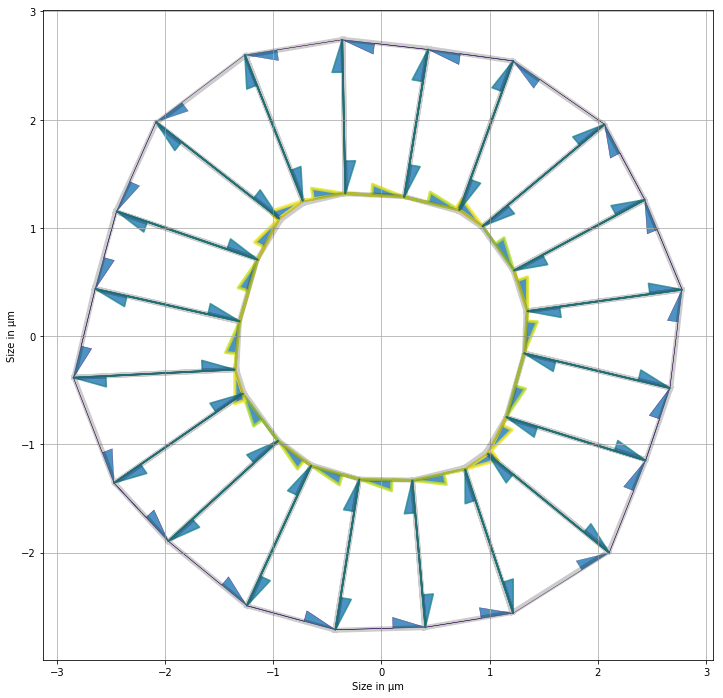

In [11]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = opt_mat_2_cst_organo.face_df.area + res_2_cst_areas.x[3*organo3.Nf:4*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

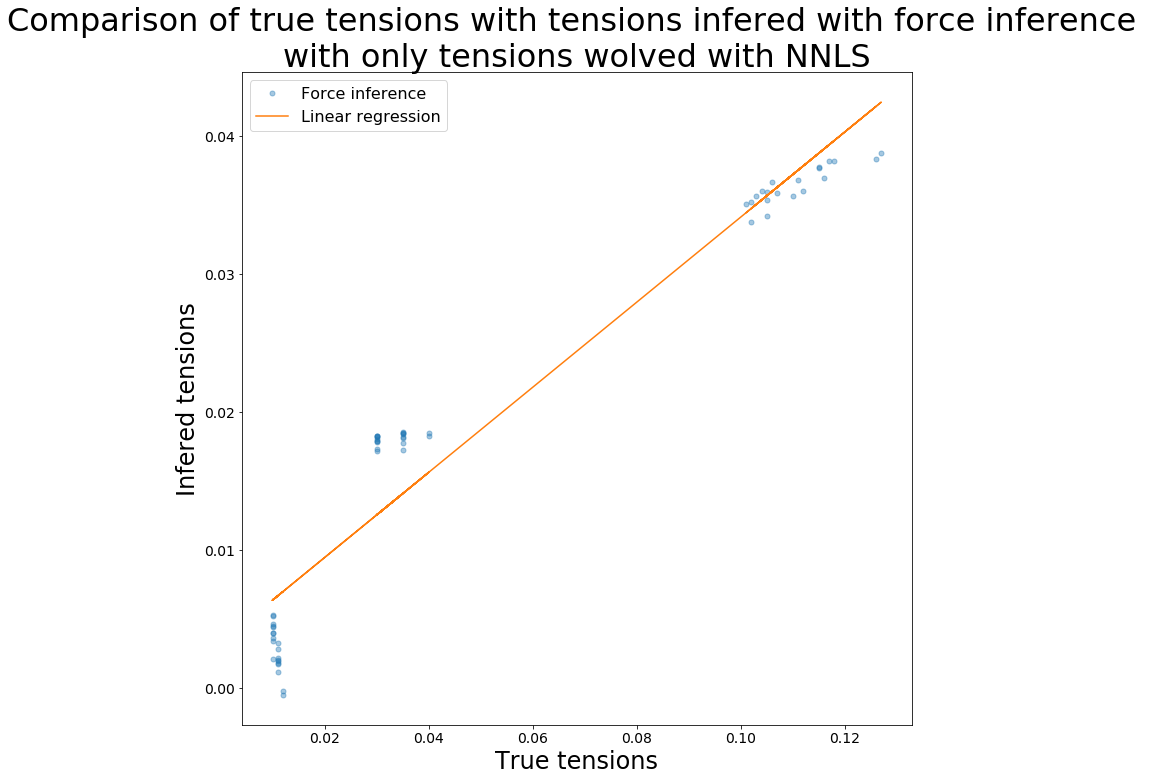

R value : 0.9630068472016589 
Standard error : 0.0032145592947003055


In [12]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

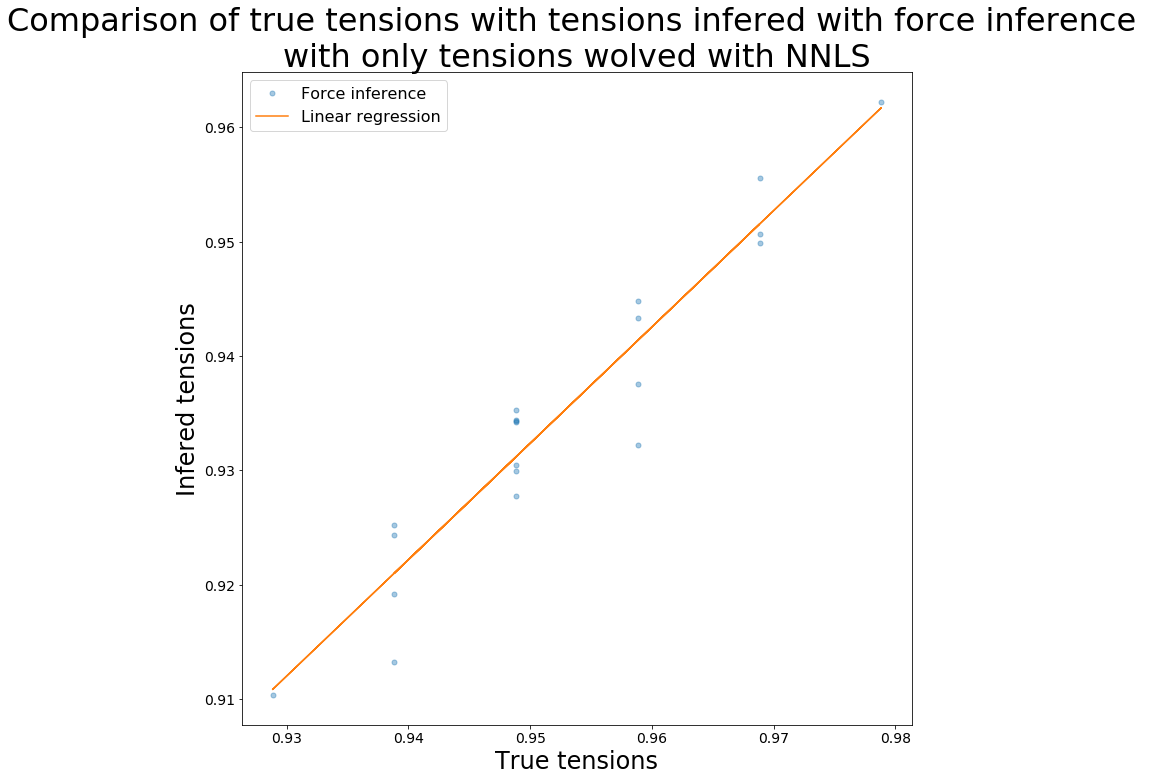

R value : 0.9577726014647161 
Standard error : 0.0018882987872307815


In [14]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))